# Introduction

This project uses the **Ames, Iowa Housing Dataset**, which contains information on home sales in Ames, Iowa, from 2006 to 2010, with nearly 3,000 instances.  

The project explores three machine learning tasks:

- **Classification:** Predict the neighborhood type of a home (e.g., rural, suburban, urban).  
- **Regression:** Predict the home sale price using the available features.  
- **Clustering:** Group homes by type (e.g., luxury, budget) based on their characteristics.

## Models Used

### Classification
- **K-Nearest Neighbors (KNN)** – A simple distance-based classifier  
- **Linear Discriminant Analysis (LDA)** – Projects data to maximize class separability  

### Regression
- **LASSO** – Linear model with L1 regularization to reduce overfitting and select features  
- **Elastic Net** – Combines L1 and L2 regularization for flexible feature selection  

### Clustering
- **K-Means** – Partition-based clustering algorithm  
- **Agglomerative Clustering** – Hierarchical clustering using a bottom-up approach

# Imports

In [ ]:
# Imports

# Analysis & Plotting
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import silhouette_score
from sklearn.metrics import make_scorer
from yellowbrick.cluster import SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform, pdist

# Spliting
from sklearn.model_selection import train_test_split

# Imputation
from sklearn.impute import SimpleImputer

# Encoding
from sklearn.preprocessing import OneHotEncoder

# Scaling
from sklearn.preprocessing import StandardScaler

# Fimensionality Reduction
from sklearn.decomposition import PCA

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Variables

In [ ]:
# Random state
RANDOM_STATE = 42

# CV
splits = 5
cv_classification = StratifiedKFold(n_splits=splits, shuffle=True, random_state=RANDOM_STATE)
cv_regression = KFold(n_splits=splits, shuffle=True, random_state=RANDOM_STATE)

# Helper Funcitons

In [ ]:
# List indices
GS_RESUTLS_NAME = 0
GS_SCORING_METHOD = 1
GS_RESUTLS_MEAN = 2
GS_RESUTLS_STD = 3
GS_RESUTLS_HYPERPARAMETERS = 4

# List to hold all results
gs_results = []

# Set formatting
format = "{:<30}{:<60}{:<35}{:<50}"

def print_gs_header():
  print(format
      .format(
        f'Model',
        f'Scoring metric',
        f'Mean ± Std',
        f'Chosen Hyperparameters'
        ))

# Prints grid search data from list
def print_gs_results(input_gs_results: []):
  print_gs_header()

  print(format
    .format(
      f'{input_gs_results[GS_RESUTLS_NAME]}',
      f'{input_gs_results[GS_SCORING_METHOD]}',
      f'{input_gs_results[GS_RESUTLS_MEAN]:.4f} ± {input_gs_results[GS_RESUTLS_STD]:.4f}',
      f'{input_gs_results[GS_RESUTLS_HYPERPARAMETERS]}'
      ))

# Prints table header for grid search data
def print_gs_table():
  print_gs_header()

  for result in gs_results:
    print(format
      .format(
        f'{result[GS_RESUTLS_NAME]}',
        f'{result[GS_SCORING_METHOD]}',
        f'{result[GS_RESUTLS_MEAN]:.4f} ± {result[GS_RESUTLS_STD]:.4f}',
        f'{result[GS_RESUTLS_HYPERPARAMETERS]}'
        ))

# Saves grid search data to list
def save_gs_results(gs: GridSearchCV):
  best_idx = gs.best_index_
  std = gs.cv_results_['std_test_score'][best_idx]

  current_gs_results = [None] * 5
  current_gs_results[GS_RESUTLS_NAME] = type(gs.best_estimator_).__name__
  current_gs_results[GS_SCORING_METHOD] = gs.scoring
  current_gs_results[GS_RESUTLS_MEAN] = gs.best_score_
  current_gs_results[GS_RESUTLS_STD] = std
  current_gs_results[GS_RESUTLS_HYPERPARAMETERS] = gs.best_params_
  gs_results.append(current_gs_results)

  print_gs_results(current_gs_results)

# Data Cleaning & Preprocessing

## Load the dataset

In [ ]:
# Load dataset
data = pd.read_csv('Ames_Housing.csv')

## Handle missing values and duplicates

### Handle duplicates

In summary, I found 7 duplicate rows which were dropped from our dataset. No duplicate features were found.

#### Duplicate rows

In [ ]:
# Check for duplicate rows
print('Number of duplicate rows: ', data.duplicated().sum())

Number of duplicate rows:  7


In [ ]:
# Drop the duplicate rows
data = data.drop_duplicates()

# Check again to make sure duplicated rows are removed
print('Number of duplicate rows: ', data.duplicated().sum())

Number of duplicate rows:  0


#### Duplicate features

In [ ]:
# Boolean mask of duplicate columns by content
duplicates_mask = data.T.duplicated()

# List of duplicate column names
duplicate_cols = data.columns[duplicates_mask]
print("Duplicate features: ", duplicate_cols.tolist())

Duplicate features:  []


### Handle missing values 30% rule

#### Discover missing values

In [ ]:
# Look for missing values
data.isnull().sum()

Order               0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Frontage      490
                 ... 
Mo Sold             0
Yr Sold             0
Sale Type           0
Sale Condition      0
SalePrice           0
Length: 82, dtype: int64

In [ ]:
# Percent of missing data
feature_missing_percent = data.isnull().mean() * 100
feature_missing_percent

Order              0.000000
PID                0.000000
MS SubClass        0.000000
MS Zoning          0.000000
Lot Frontage      16.723549
                    ...    
Mo Sold            0.000000
Yr Sold            0.000000
Sale Type          0.000000
Sale Condition     0.000000
SalePrice          0.000000
Length: 82, dtype: float64

In [ ]:
# Count number of features having more than 30% missing values
count = 0
for col, percent in feature_missing_percent.items():
    if percent > 30:
        print(col, percent)
        count += 1
print('Number of features with more than 30% missing values: ', count)

Alley 93.24232081911262
Mas Vnr Type 60.580204778157
Fireplace Qu 48.532423208191126
Pool QC 99.55631399317406
Fence 80.4778156996587
Misc Feature 96.38225255972696
Number of features with more than 30% missing values:  6


#### Dropping the feature that are missing more than 30% of values



I am dropping features that have more than 30% missing values.

In [ ]:
# Drop features that are missing more than 30% of their data
data = data.drop(labels=['Alley'], axis=1)
data = data.drop(labels=['Mas Vnr Type'], axis=1)
data = data.drop(labels=['Fireplace Qu'], axis=1)
data = data.drop(labels=['Pool QC'], axis=1)
data = data.drop(labels=['Fence'], axis=1)
data = data.drop(labels=['Misc Feature'], axis=1)

In [ ]:
# Check to make sure the features were removed
# Sum of missing values
data.isnull().sum()

Order               0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Frontage      490
                 ... 
Mo Sold             0
Yr Sold             0
Sale Type           0
Sale Condition      0
SalePrice           0
Length: 76, dtype: int64

In [ ]:
# Check to make sure the features were removed
# Percent of missing data
feature_missing_percent = data.isnull().mean() * 100
feature_missing_percent

Order              0.000000
PID                0.000000
MS SubClass        0.000000
MS Zoning          0.000000
Lot Frontage      16.723549
                    ...    
Mo Sold            0.000000
Yr Sold            0.000000
Sale Type          0.000000
Sale Condition     0.000000
SalePrice          0.000000
Length: 76, dtype: float64

In [ ]:
# Check to make sure the features were removed
# Count number of features having more than 30% missing values
count = 0
for col, percent in feature_missing_percent.items():
    if percent > 30:
        print(col, percent)
        count += 1
print('Number of features with more than 30% missing values: ', count)

Number of features with more than 30% missing values:  0


### Drop feature that are unique per row

In [ ]:
# Show top 5 rows of data
data.head()

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Lot Shape Land Contour Utilities  ... Enclosed Porch 3Ssn Porch  \
0       IR1          Lvl    AllPub  ...              0          0   
1       Reg          Lvl    AllPub  ...              0          0   
2       IR1          Lvl    AllPub  ...              0          0   
3       Reg          Lvl    AllPub  ...              0          0   
4       IR1          Lvl    AllPub  ...              0          0   

  Screen Porch Pool Area Misc Val Mo Sold Yr Sold  Sale Type  Sale Condition  \
0            0         0        0       5    2010        WD           Normal   
1          120         0        0       6    2010        WD           Normal   
2            0         0    12500       6    2010        WD           Normal   
3            0         0        0       4    2010        WD           Normal   
4            0         0        0       3    2010        WD           Normal   

   SalePrice  
0     215000  
1     105000  
2     172000  
3     244000  
4     189900  

[5 rows x 76 columns]

In [ ]:
# Scan for features that are unique per row
unique_features = [col for col in data.columns if data[col].nunique() == len(data)]
print("Features that are unique per row:", unique_features)

Features that are unique per row: ['Order', 'PID']


In [ ]:
# Drop features that are unique per row
data = data.drop(labels=['Order'], axis=1)
data = data.drop(labels=['PID'], axis=1)

In [ ]:
# Scan for features that are unique per row
# Ensure these features were removed
unique_features = [col for col in data.columns if data[col].nunique() == len(data)]
print("Features that are unique per row:", unique_features)

Features that are unique per row: []


In [ ]:
# Show top 5 rows of data
data.head()

MS SubClass MS Zoning  Lot Frontage  Lot Area Street Lot Shape  \
0           20        RL         141.0     31770   Pave       IR1   
1           20        RH          80.0     11622   Pave       Reg   
2           20        RL          81.0     14267   Pave       IR1   
3           20        RL          93.0     11160   Pave       Reg   
4           60        RL          74.0     13830   Pave       IR1   

  Land Contour Utilities Lot Config Land Slope  ... Enclosed Porch 3Ssn Porch  \
0          Lvl    AllPub     Corner        Gtl  ...              0          0   
1          Lvl    AllPub     Inside        Gtl  ...              0          0   
2          Lvl    AllPub     Corner        Gtl  ...              0          0   
3          Lvl    AllPub     Corner        Gtl  ...              0          0   
4          Lvl    AllPub     Inside        Gtl  ...              0          0   

  Screen Porch Pool Area Misc Val  Mo Sold  Yr Sold  Sale Type  \
0            0         0        0        5     2010        WD    
1          120         0        0        6     2010        WD    
2            0         0    12500        6     2010        WD    
3            0         0        0        4     2010        WD    
4            0         0        0        3     2010        WD    

   Sale Condition SalePrice  
0          Normal    215000  
1          Normal    105000  
2          Normal    172000  
3          Normal    244000  
4          Normal    189900  

[5 rows x 74 columns]

### Split into training and testing data

In [ ]:
# Splil data into training and testing
train_data, test_data = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)

# Print shape to visualize split
print("All data", data.shape)
print("Training data", train_data.shape)
print("Testing data", test_data.shape)

All data (2930, 74)
Training data (2344, 74)
Testing data (586, 74)


### Visualize missing values

<Axes: >

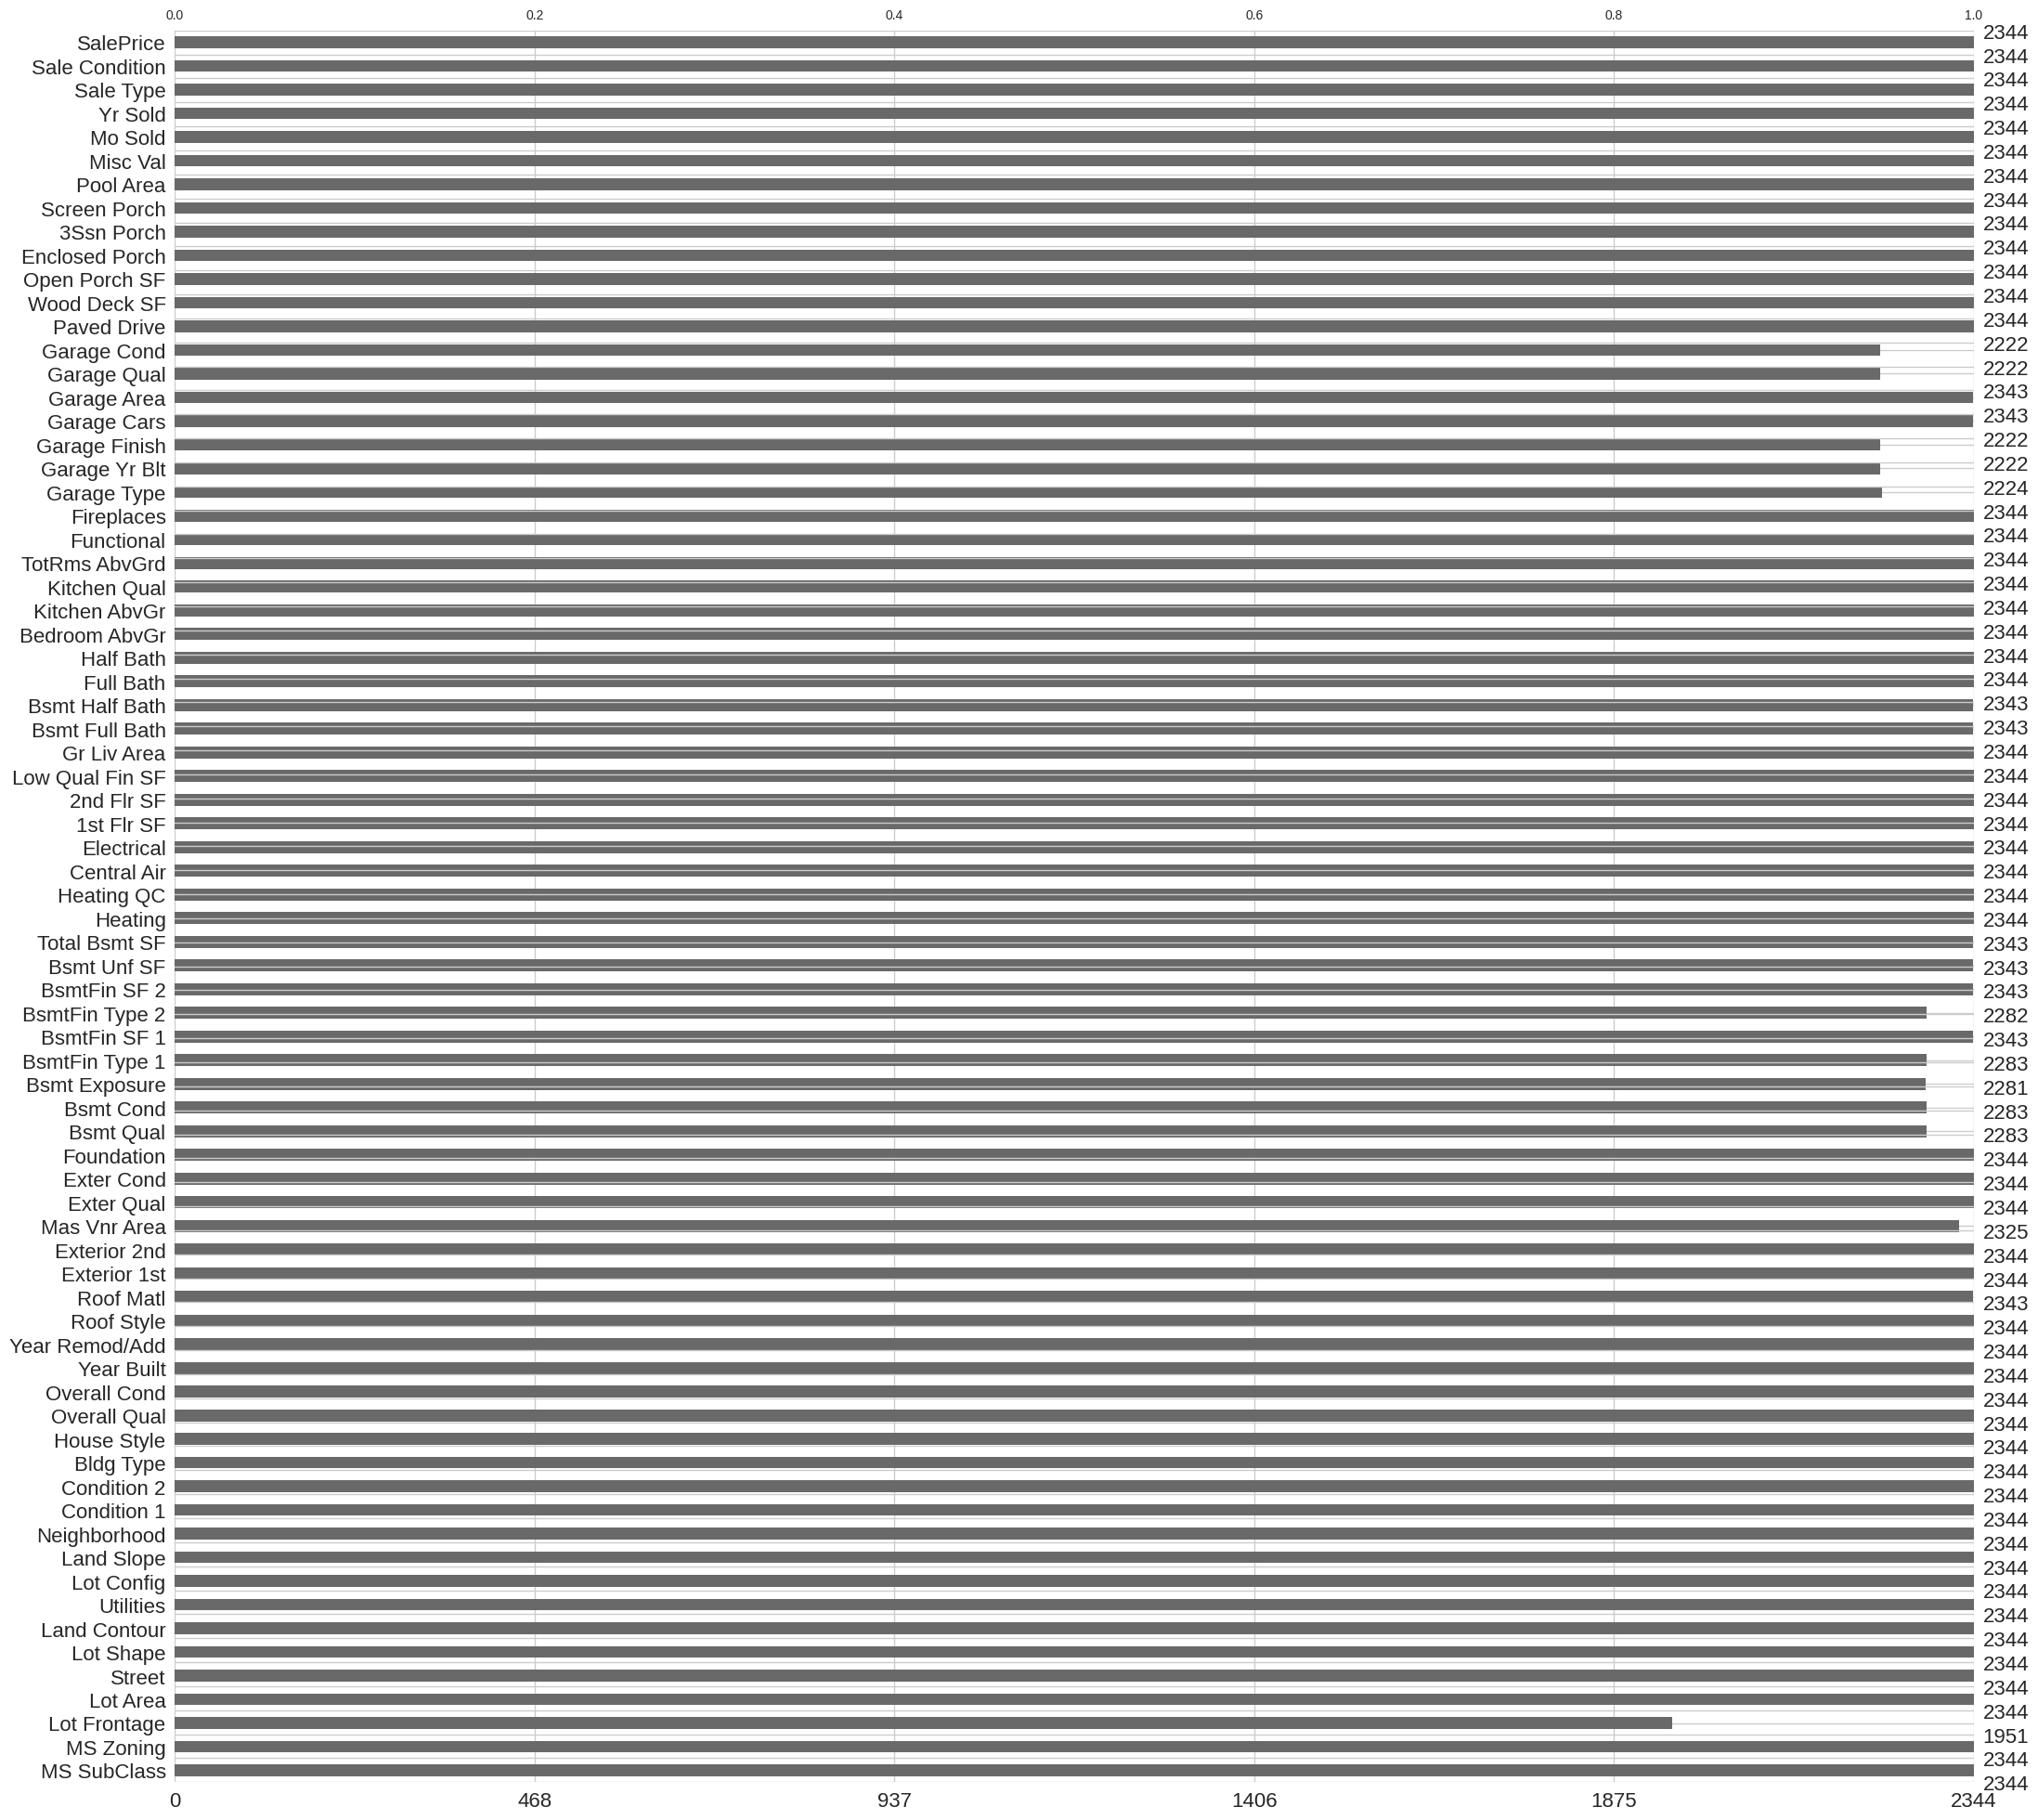

In [ ]:
# Create bar chart showing the number of non missing data for training data
msno.bar(train_data)

<Axes: >

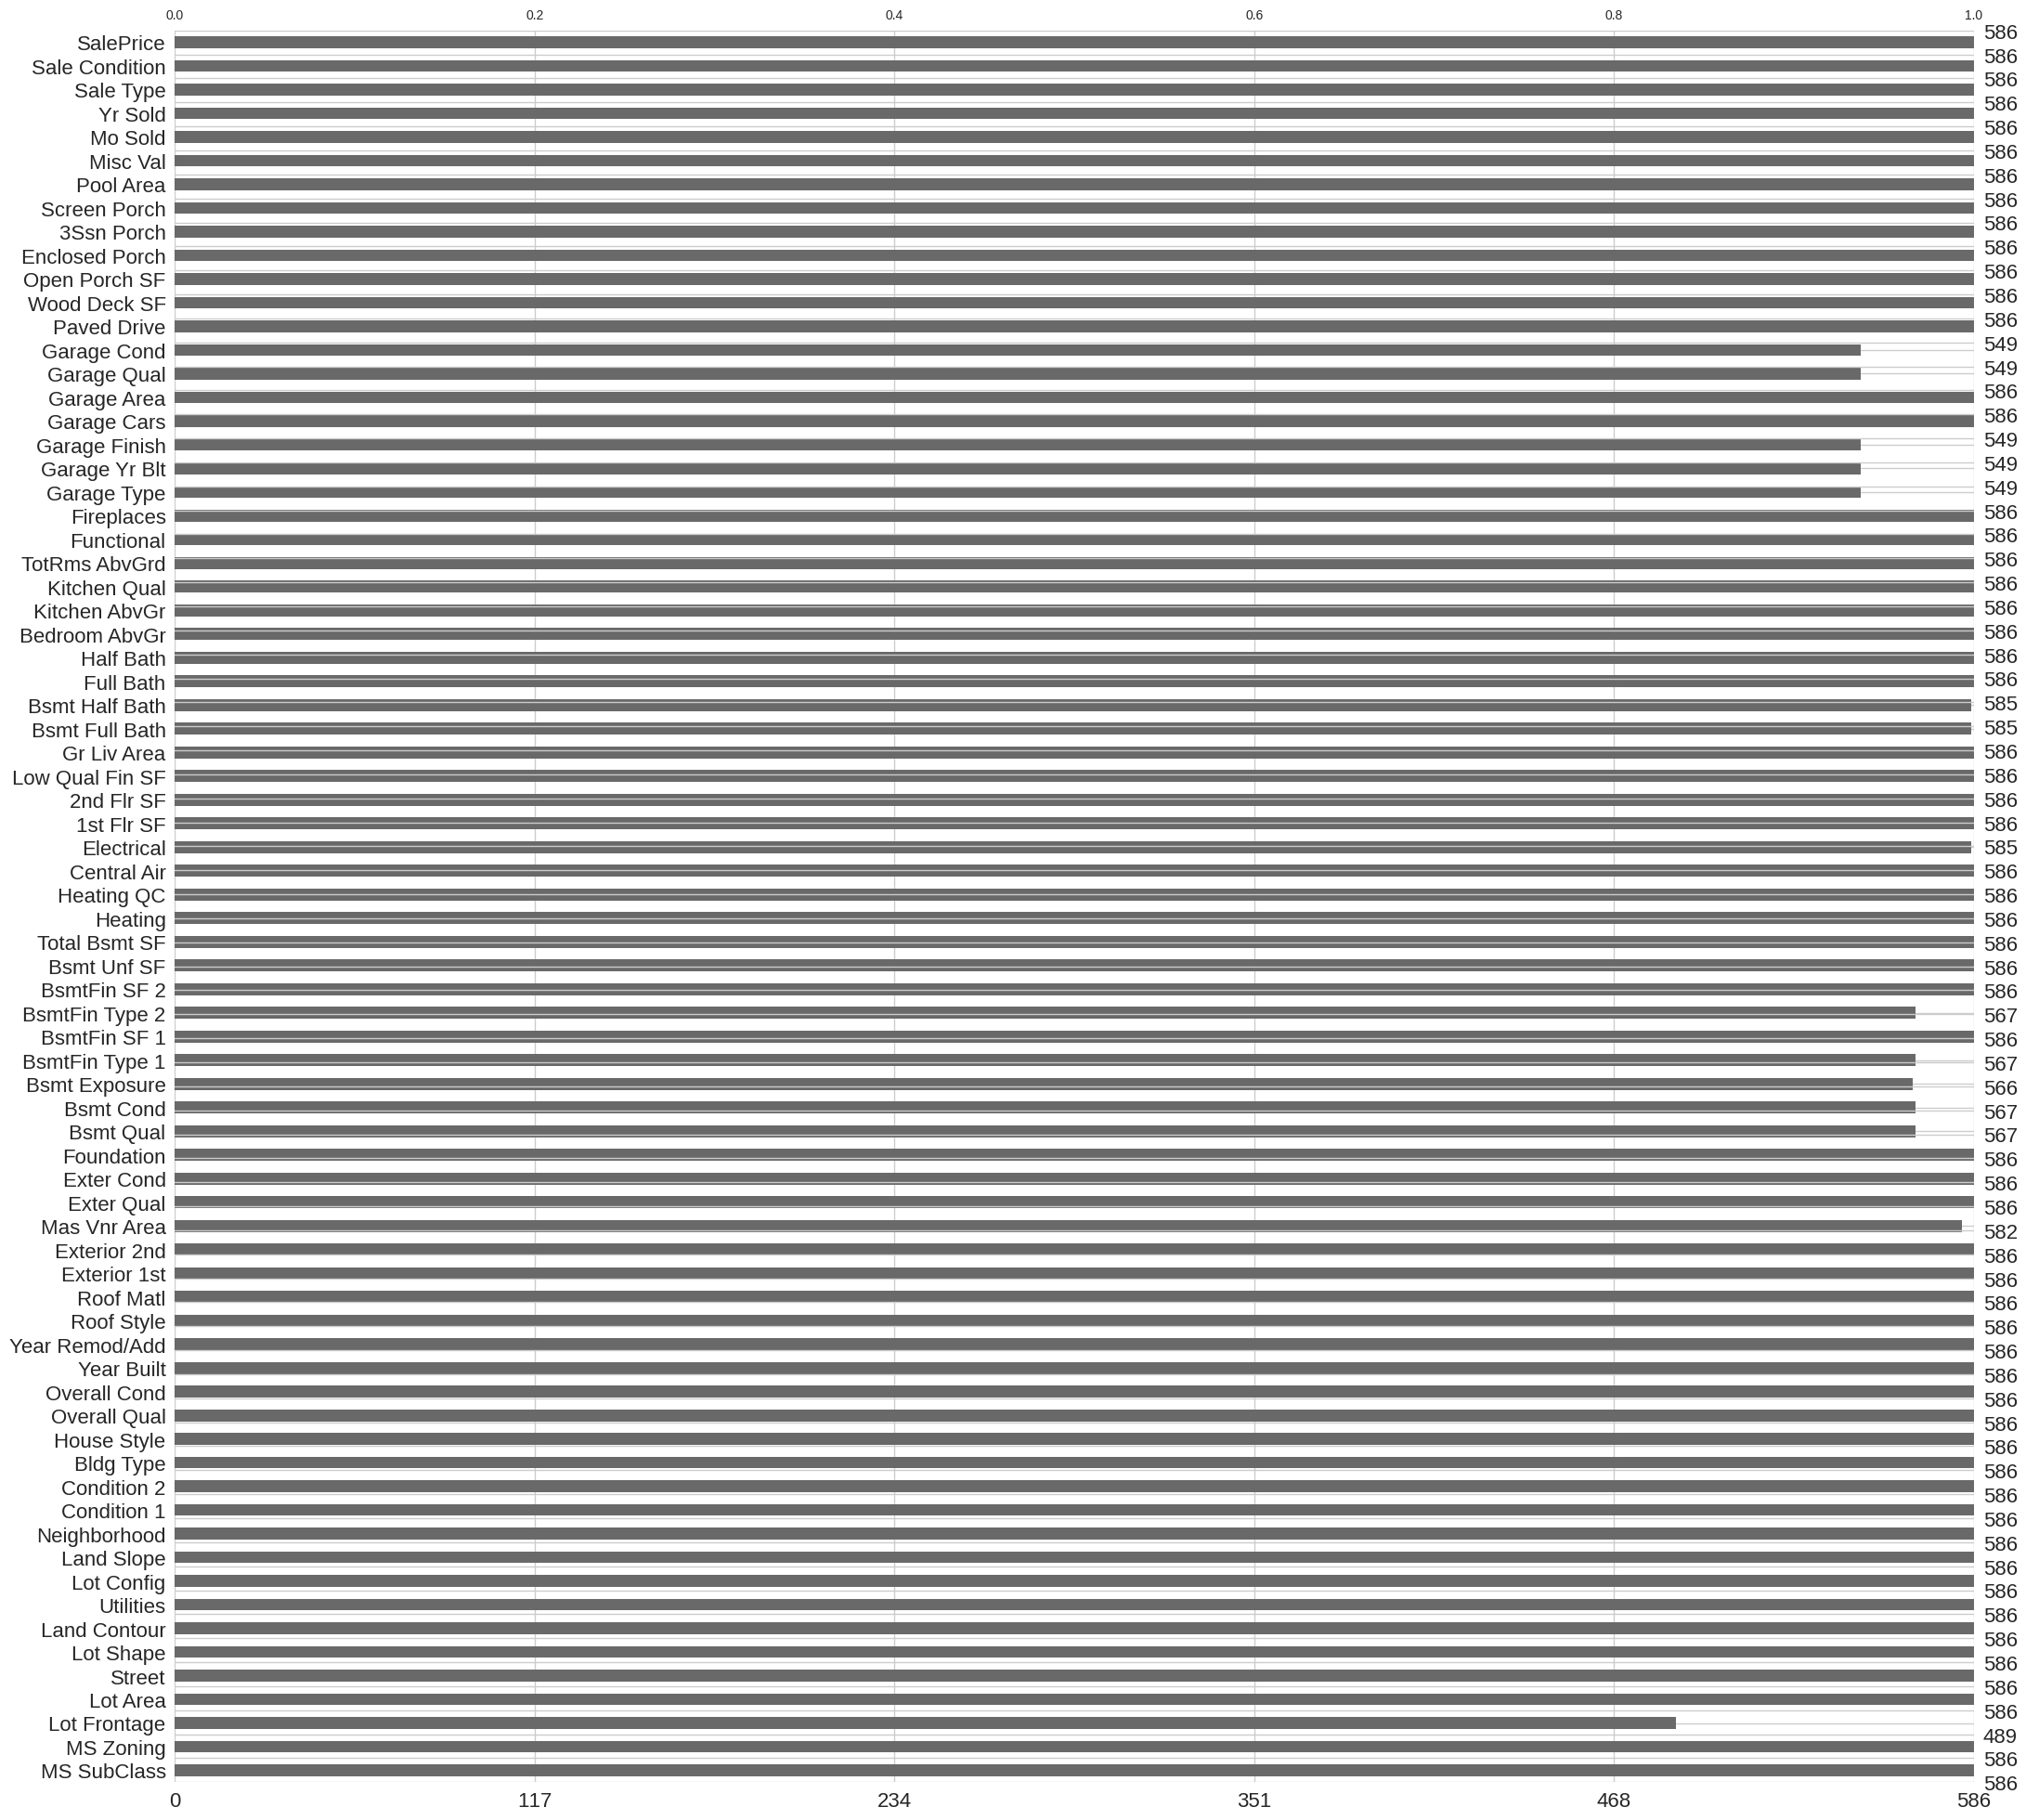

In [ ]:
# Create bar chart showing the number of non missing data for testing data
msno.bar(test_data)

The above bar chart is hard to see because it has so many features. I am using the below code block to remove features that are not missing any values.

<Axes: >

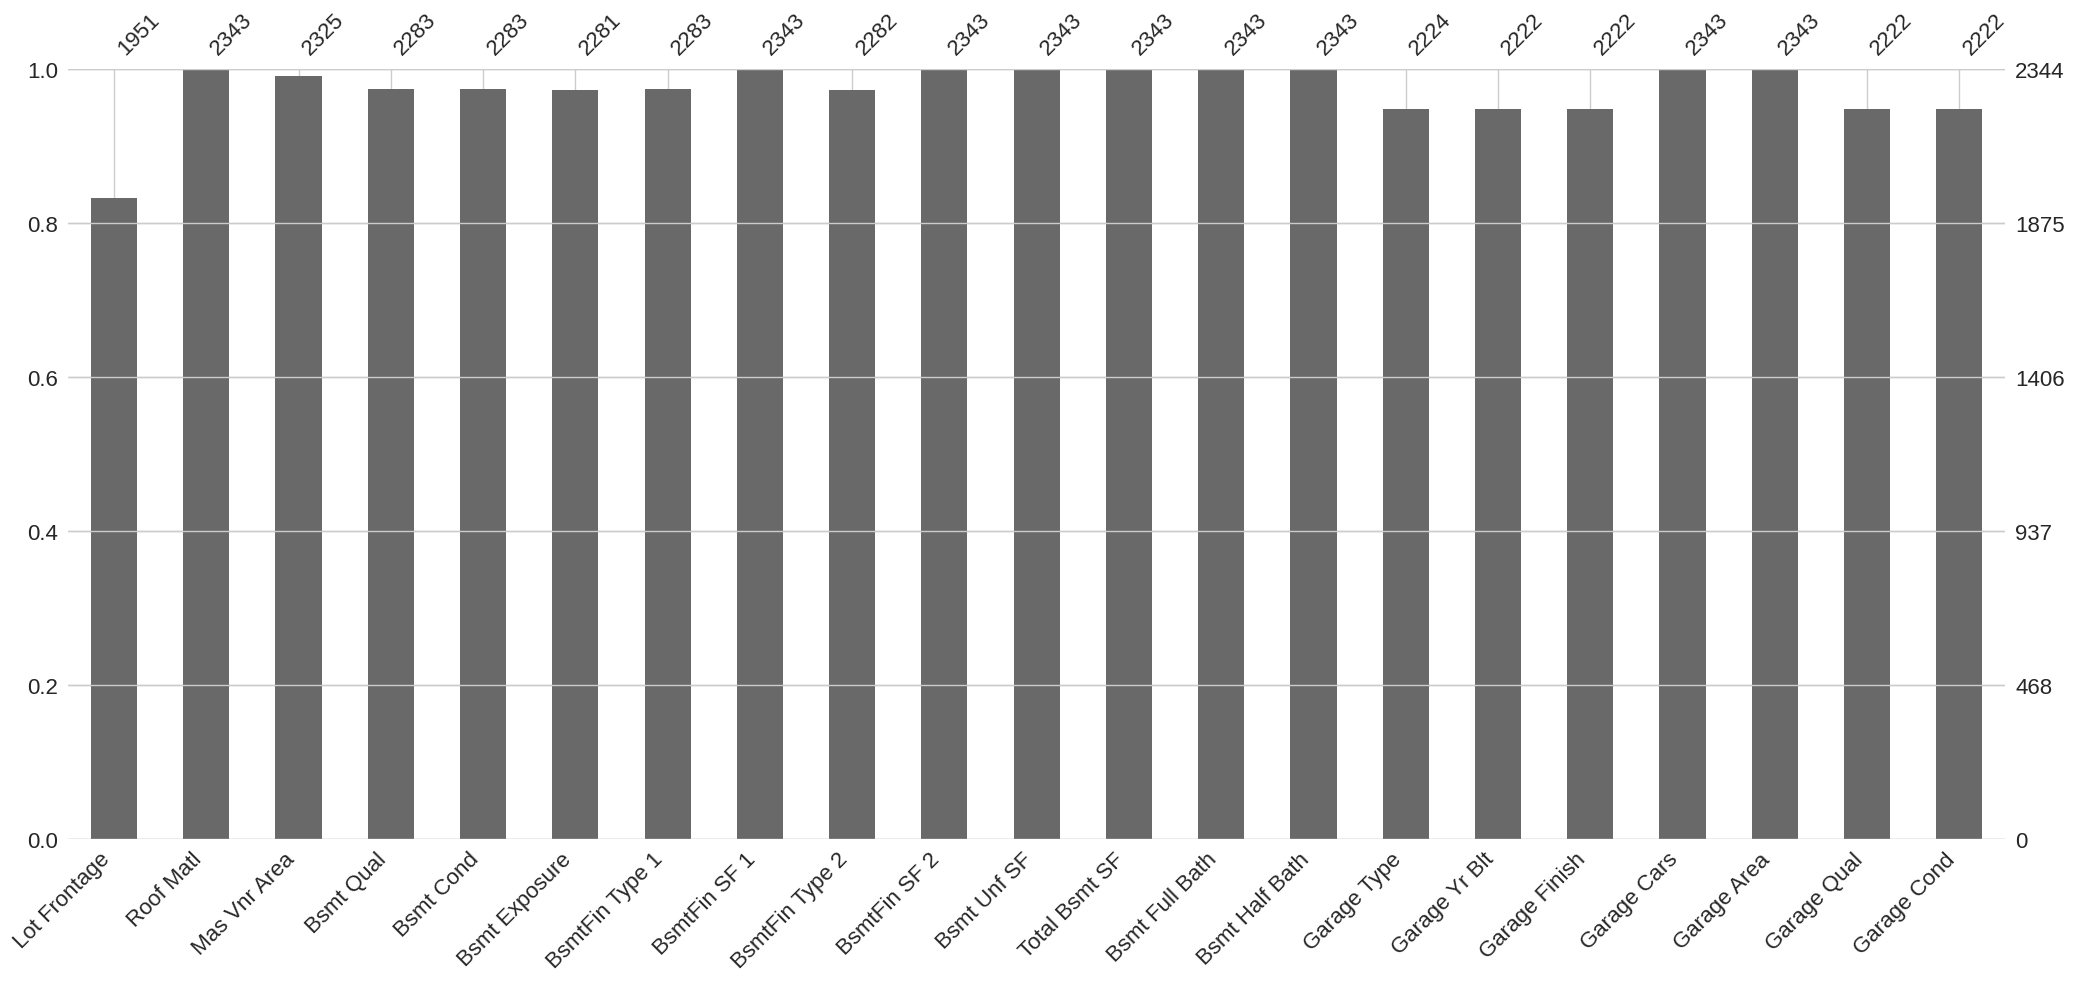

In [ ]:
# Find only features with missing values for better visualization
cols_with_missing = train_data.columns[train_data.isnull().any()]
# Create bar chart showing the number of non missing data for training data only for features with missing values
msno.bar(train_data[cols_with_missing])

<Axes: >

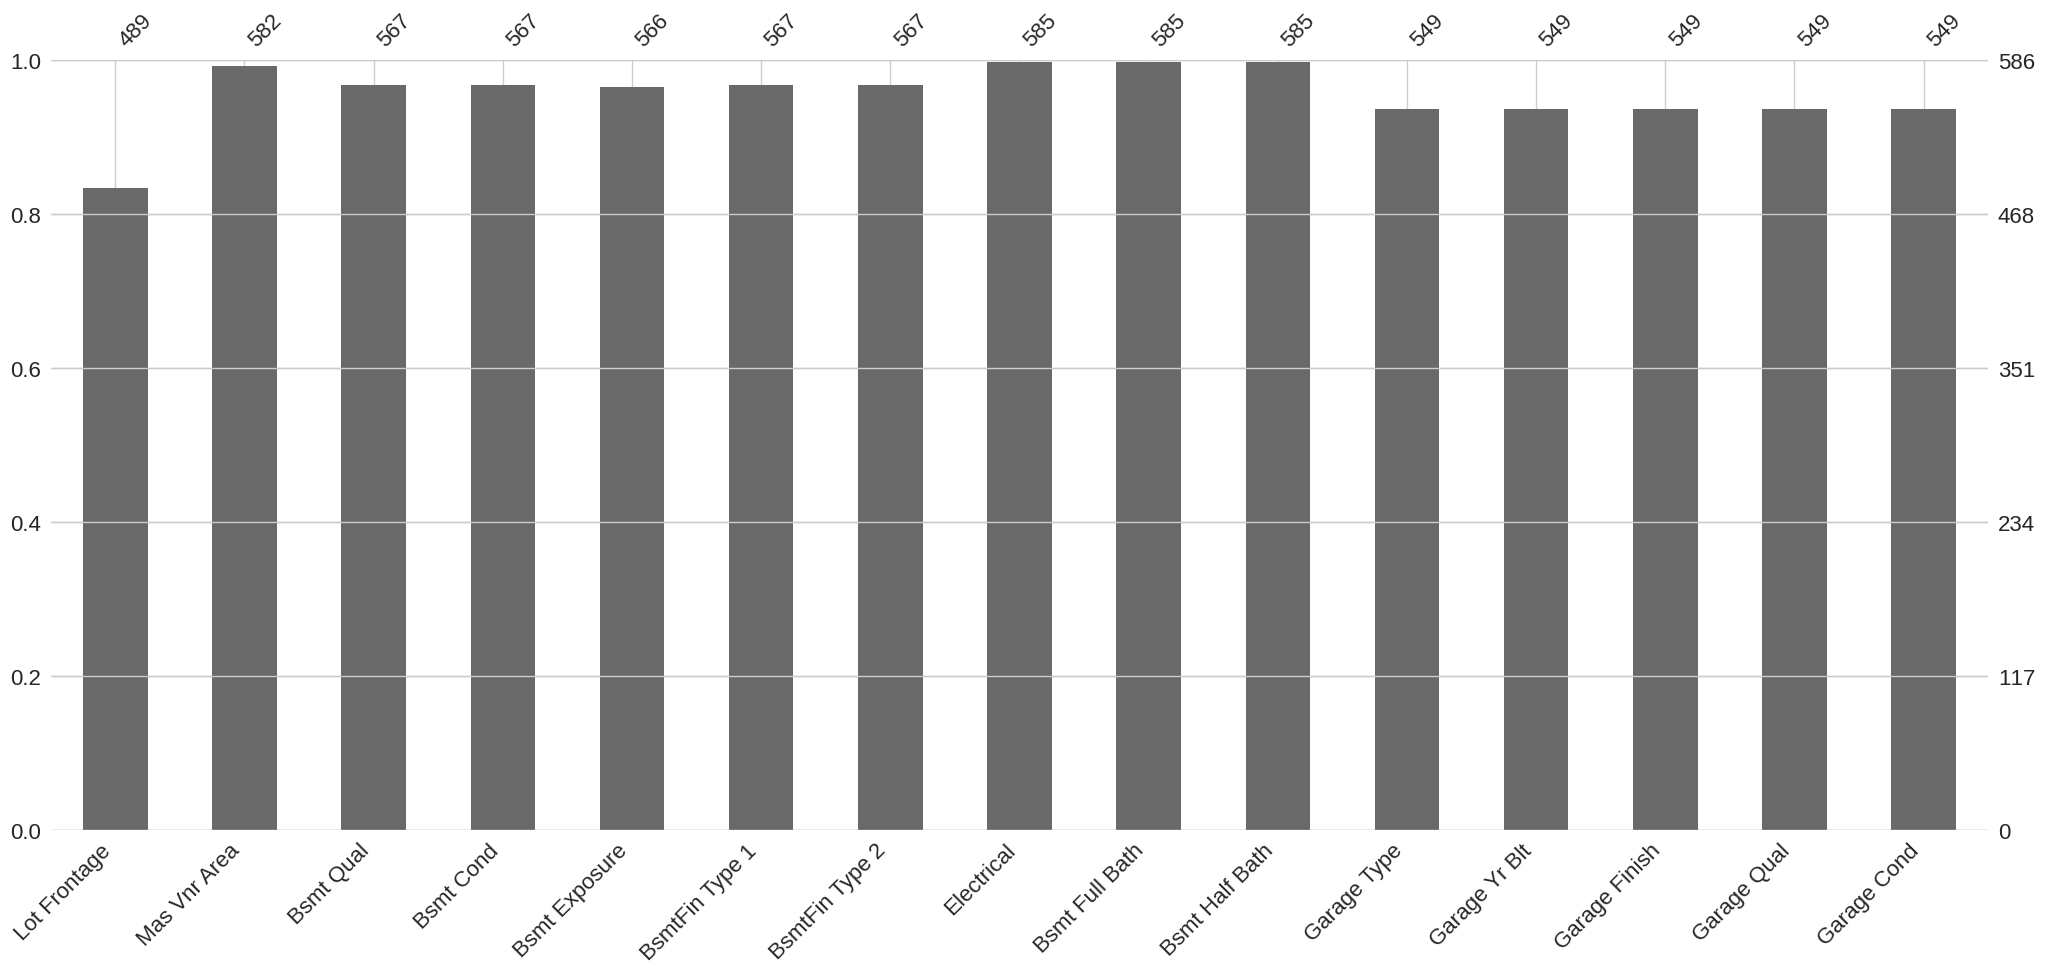

In [ ]:
# Find only features with missing values for better visualization
cols_with_missing = test_data.columns[test_data.isnull().any()]
# Create bar chart showing the number of non missing data for testing data only for features with missing values
msno.bar(test_data[cols_with_missing])

<Axes: >

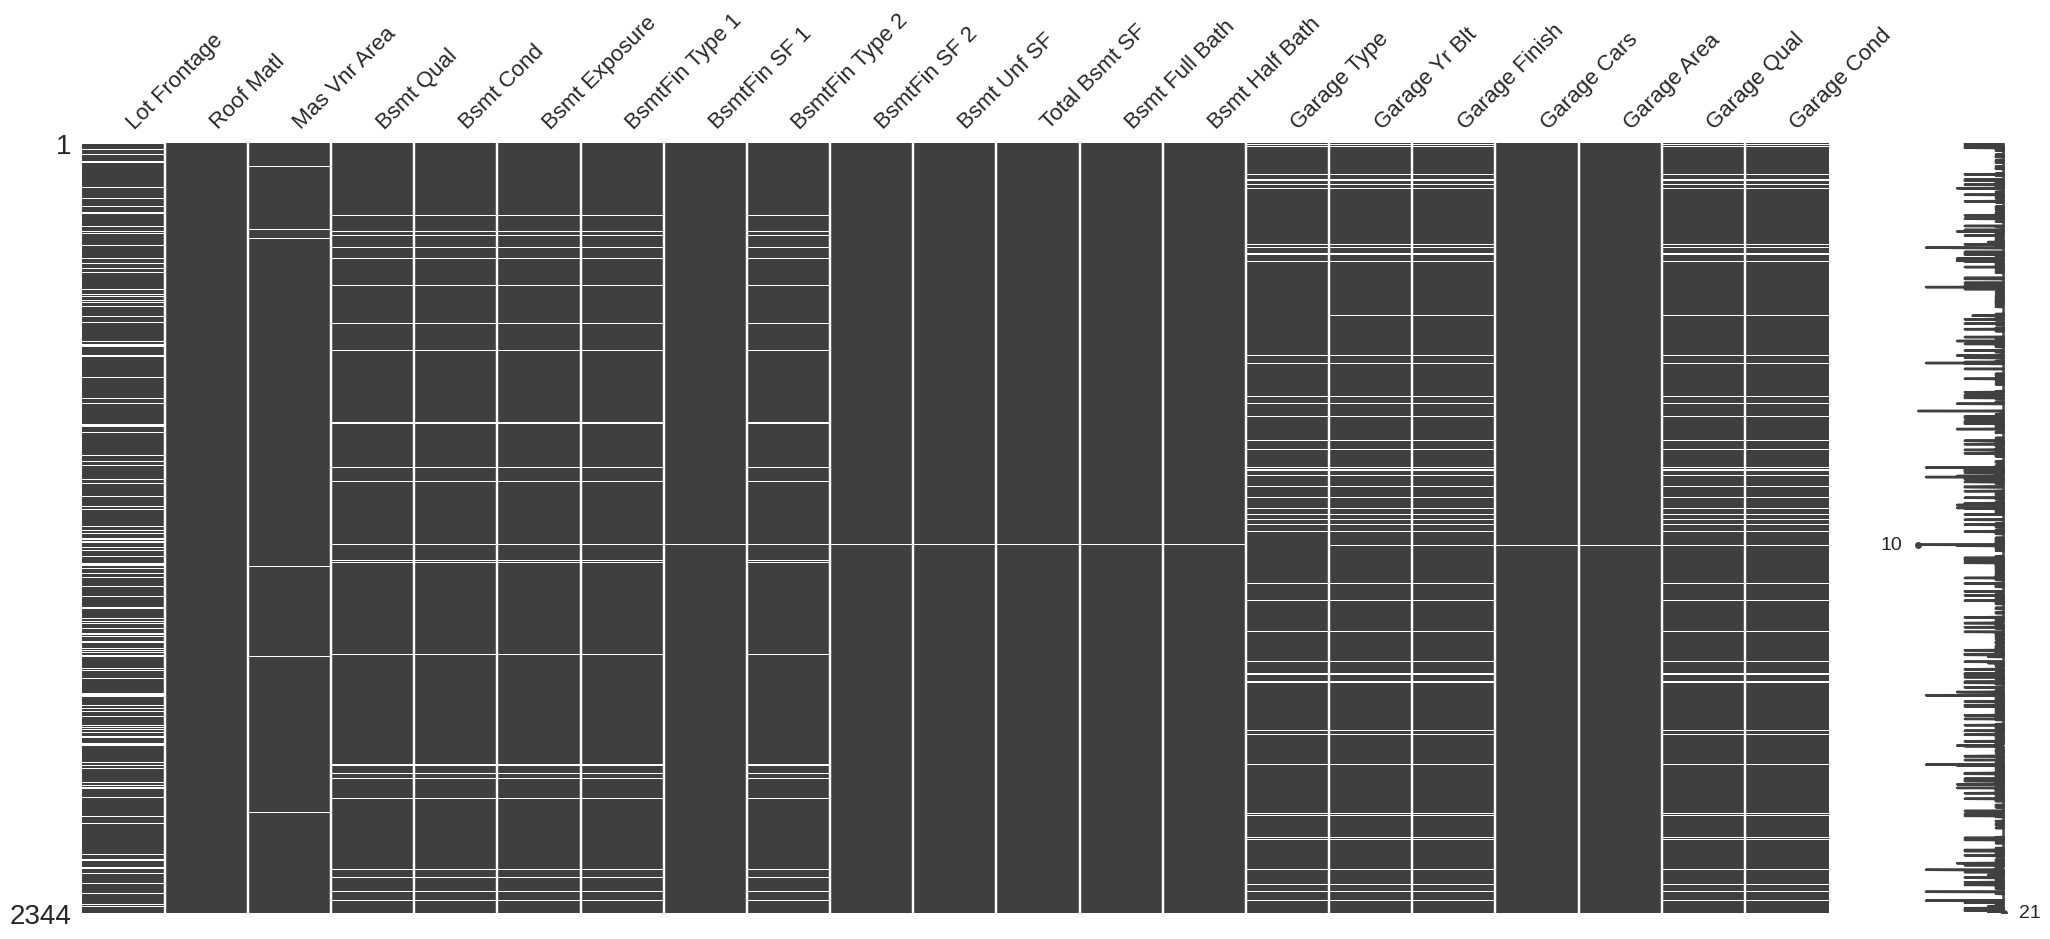

In [ ]:
# Find only features with missing values for better visualization
cols_with_missing = train_data.columns[train_data.isnull().any()]
# Create the matrix of features that have missing values for training data
msno.matrix(train_data[cols_with_missing])

<Axes: >

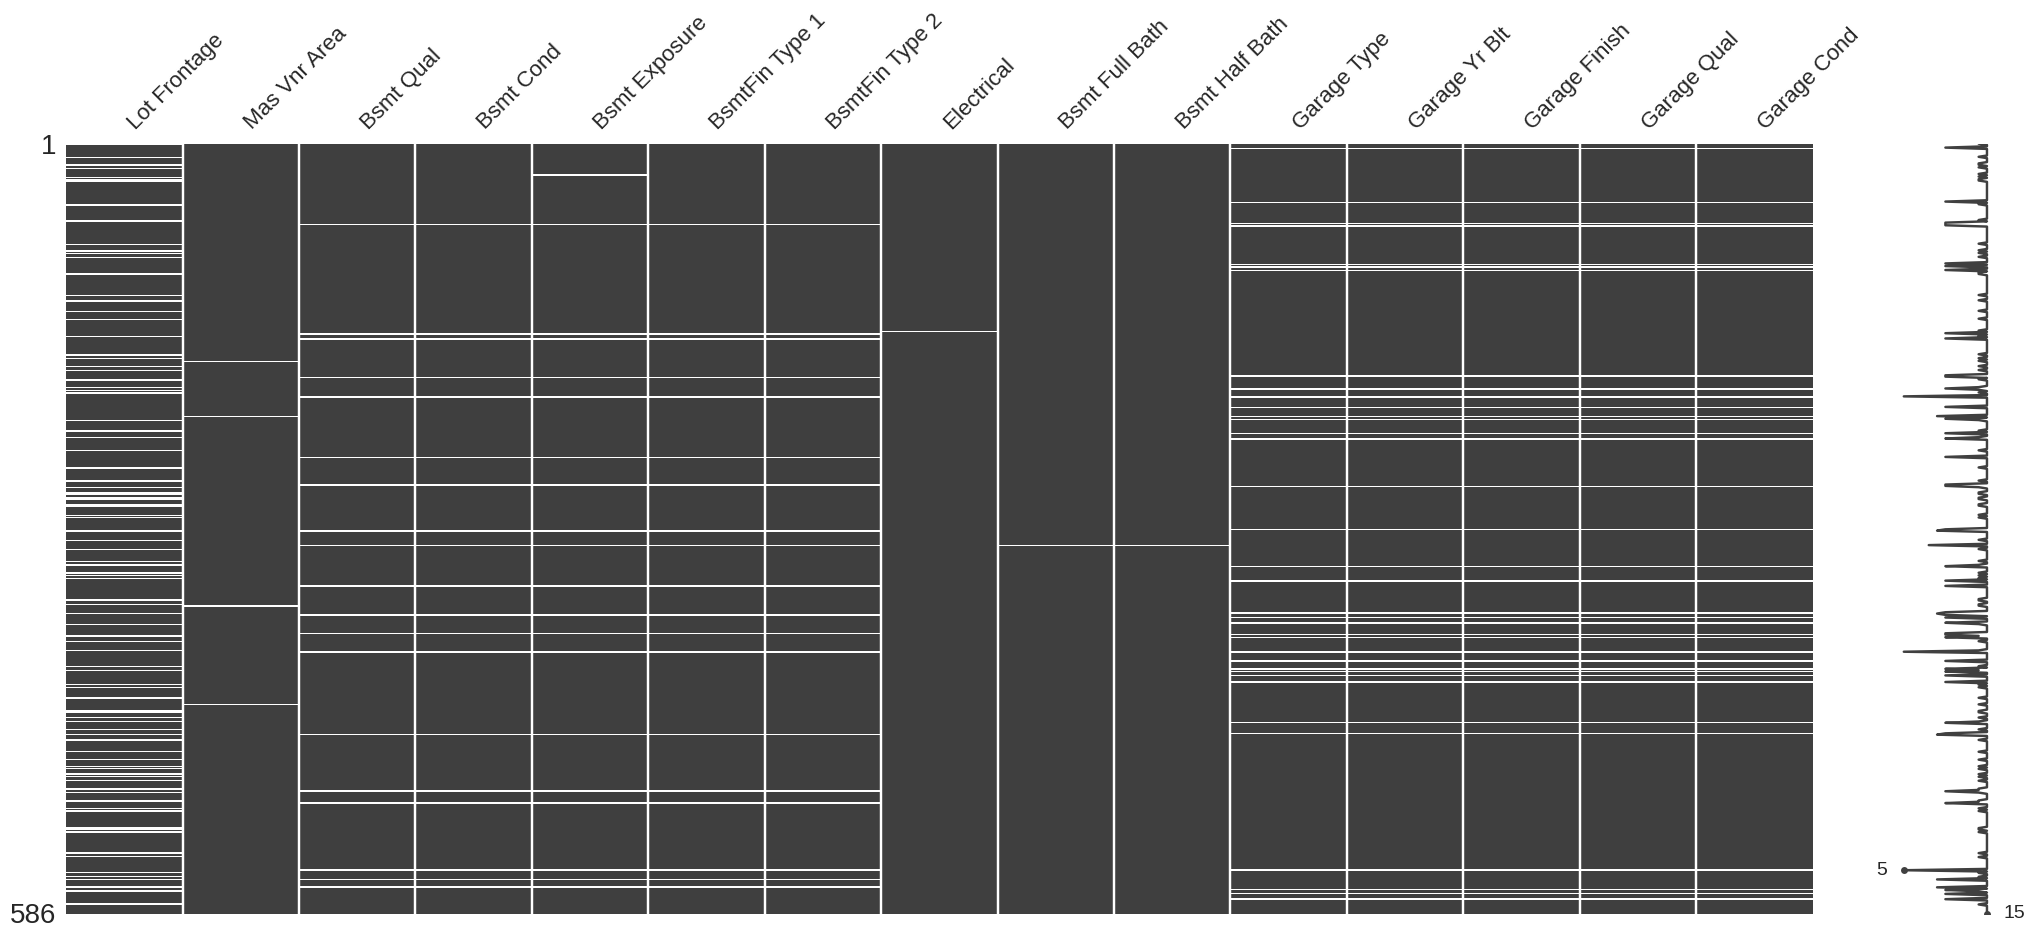

In [ ]:
# Find only features with missing values for better visualization
cols_with_missing = test_data.columns[test_data.isnull().any()]
# Create the matrix of features that have missing values for testing data
msno.matrix(test_data[cols_with_missing])

**Observations**

For "Lot Frontage", we have a lot more missing values compared to the others and it appears to be MCAR because no clear pattern can be seen.

For "Bsmt Qual", "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", and "BsmtFin Type 2" these appear to me MAR because clear patterns can be seen.

For "Garage Type", "Garage Yr Built", "Garage Finish", "Garage Qual", and "Garage Cond" these appear to be MAR because clear patterns can be seen.

The rest of features are missing a few values each and this appears to be MCAR because no clear pattern can be seen.

#### Basement missing features

In [ ]:
# Print number missing for each feature with keyword 'garage' TRAIN data
garage_features = [col for col in data.columns if "bsmt" in col.lower()]
train_data[garage_features].isna().sum().sort_values(ascending=False)

Bsmt Exposure     63
BsmtFin Type 2    62
Bsmt Qual         61
Bsmt Cond         61
BsmtFin Type 1    61
BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     1
Bsmt Half Bath     1
dtype: int64

In [ ]:
# See number of basements that have 0 square feet
(train_data['Total Bsmt SF'] == 0).sum()

np.int64(60)

In [ ]:
# Print number missing for each feature with keyword 'garage' TEST data
test_data[garage_features].isna().sum().sort_values(ascending=False)

Bsmt Exposure     20
Bsmt Qual         19
Bsmt Cond         19
BsmtFin Type 1    19
BsmtFin Type 2    19
Bsmt Full Bath     1
Bsmt Half Bath     1
BsmtFin SF 2       0
BsmtFin SF 1       0
Total Bsmt SF      0
Bsmt Unf SF        0
dtype: int64

In [ ]:
# See number of basements that have 0 square feet
(test_data['Total Bsmt SF'] == 0).sum()

np.int64(19)

The number of basements that have a total of 0 square foot space are matching up with the number of basements that have missing categorical data.

It is likely that if the home had no basement then they did not fill out any of the basement related features.

In [ ]:
# Print data types for 'bsmt' features
bsmt_features = [col for col in data.columns if "bsmt" in col.lower()]
missing_counts = train_data[bsmt_features].dtypes
print(missing_counts)

Bsmt Qual          object
Bsmt Cond          object
Bsmt Exposure      object
BsmtFin Type 1     object
BsmtFin SF 1      float64
BsmtFin Type 2     object
BsmtFin SF 2      float64
Bsmt Unf SF       float64
Total Bsmt SF     float64
Bsmt Full Bath    float64
Bsmt Half Bath    float64
dtype: object


#### Garage features missing

It seems that the reason this garage data is missing is because some homes do not have garages. If the home does not have a garage then they did not fill in the data for some features. We can see in the count plot for Garage Cars that about the same number of garages missing data have 0 for the number of cars it holds.

In [ ]:
# Print number missing for each feature with keyword 'garage' TRAIN data
garage_features = [col for col in data.columns if "garage" in col.lower()]
train_data[garage_features].isna().sum().sort_values(ascending=False)

Garage Yr Blt    122
Garage Finish    122
Garage Cond      122
Garage Qual      122
Garage Type      120
Garage Area        1
Garage Cars        1
dtype: int64

In [ ]:
# Print number missing for each feature with keyword 'garage' TEST data
test_data[garage_features].isna().sum().sort_values(ascending=False)

Garage Type      37
Garage Yr Blt    37
Garage Finish    37
Garage Cond      37
Garage Qual      37
Garage Area       0
Garage Cars       0
dtype: int64

Text(0.5, 1.0, 'Garage Cars Count')

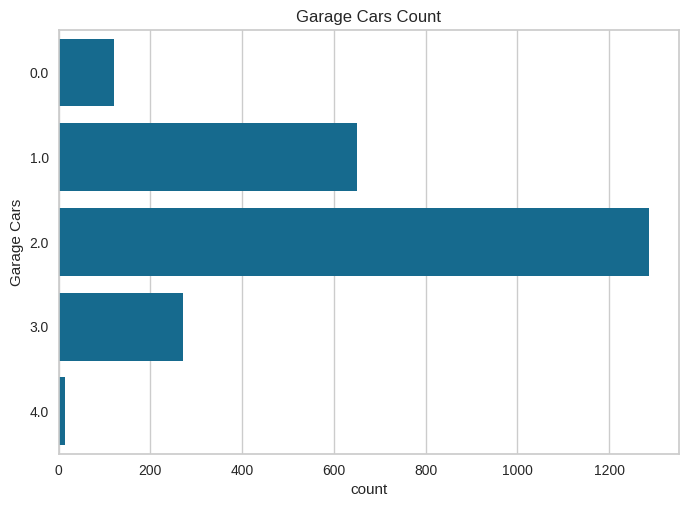

In [ ]:
# Plot count plot for Garage Cars feature
p = sns.countplot(y=train_data['Garage Cars'])
p.set_title('Garage Cars Count')

In [ ]:
# Print counts for Garage Cars data TRAIN data
train_data['Garage Cars'].value_counts()

Garage Cars
2.0    1287
1.0     651
3.0     272
0.0     120
4.0      13
Name: count, dtype: int64

In [ ]:
# Print counts for Garage Cars data TEST data
test_data['Garage Cars'].value_counts()

Garage Cars
2.0    316
1.0    127
3.0    102
0.0     37
4.0      3
5.0      1
Name: count, dtype: int64

In [ ]:
# Print data types for 'garage' features
garage_features = [col for col in data.columns if "garage" in col.lower()]
missing_counts = train_data[garage_features].dtypes
print(missing_counts)

Garage Type       object
Garage Yr Blt    float64
Garage Finish     object
Garage Cars      float64
Garage Area      float64
Garage Qual       object
Garage Cond       object
dtype: object


#### Lot frontage feature

<Axes: xlabel='Count', ylabel='Lot Frontage'>

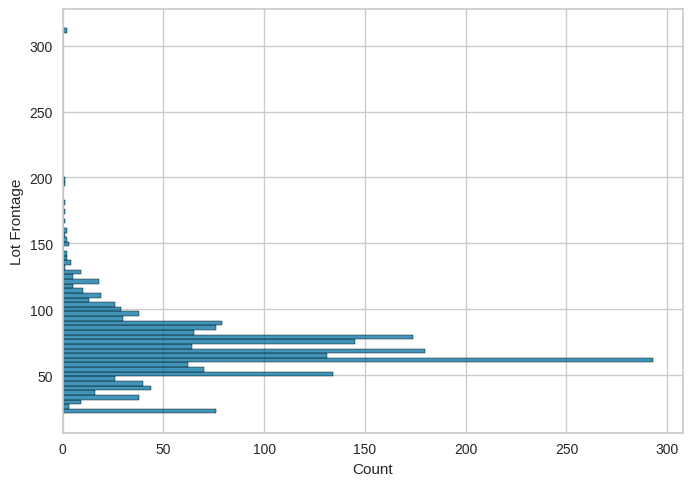

In [ ]:
sns.histplot(y=train_data['Lot Frontage'])

### Fill in missing values

#### Basement features

In [ ]:
# Impute missing basement categorical features as NO_BSMT is sqft is 0
bsmt_features_to_replace = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']
train_data.loc[train_data['Total Bsmt SF'] == 0, bsmt_features_to_replace] = train_data.loc[data['Total Bsmt SF'] == 0, bsmt_features_to_replace].fillna('NO_BSMT')
test_data.loc[test_data['Total Bsmt SF'] == 0, bsmt_features_to_replace] = test_data.loc[data['Total Bsmt SF'] == 0, bsmt_features_to_replace].fillna('NO_BSMT')

In [ ]:
# Print number missing for each feature with keyword 'garage' TRAIN data
garage_features = [col for col in data.columns if "bsmt" in col.lower()]
train_data[garage_features].isna().sum().sort_values(ascending=False)

Bsmt Exposure     3
BsmtFin Type 2    2
Bsmt Qual         1
Bsmt Cond         1
BsmtFin Type 1    1
BsmtFin SF 1      1
BsmtFin SF 2      1
Bsmt Unf SF       1
Total Bsmt SF     1
Bsmt Full Bath    1
Bsmt Half Bath    1
dtype: int64

In [ ]:
# Print number missing for each feature with keyword 'garage' TEST data
test_data[garage_features].isna().sum().sort_values(ascending=False)

Bsmt Exposure     1
Bsmt Half Bath    1
Bsmt Full Bath    1
Bsmt Cond         0
Bsmt Qual         0
BsmtFin Type 1    0
BsmtFin SF 1      0
BsmtFin SF 2      0
BsmtFin Type 2    0
Total Bsmt SF     0
Bsmt Unf SF       0
dtype: int64

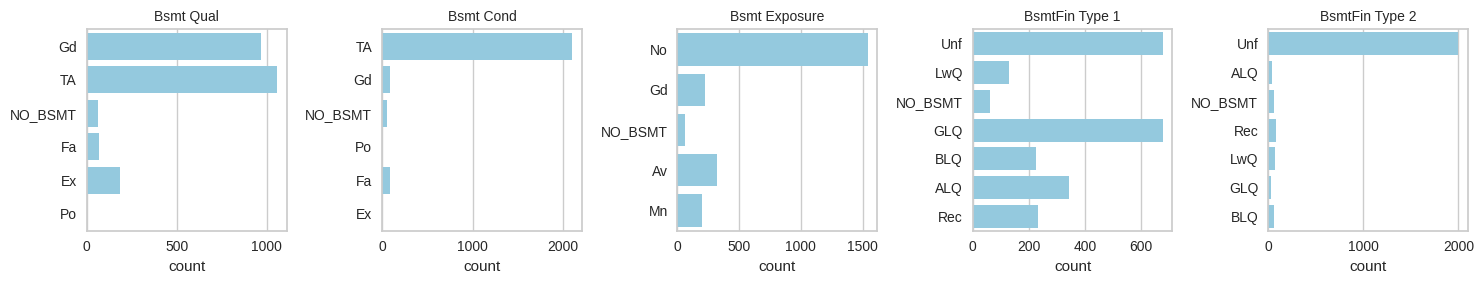

In [ ]:
# Make count plot for each basement feature that was replaced TRAIN data

# Determine grid size
import math
n_cols = 5
n_rows = math.ceil(len(bsmt_features_to_replace) / n_cols)

# Entire plot
plt.figure(figsize=(n_cols*3, n_rows*3))

# Subplots
for i, col in enumerate(bsmt_features_to_replace):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(y=train_data[col], color='skyblue')
    plt.title(col, fontsize=10)
    plt.ylabel('')

plt.tight_layout()
plt.show()

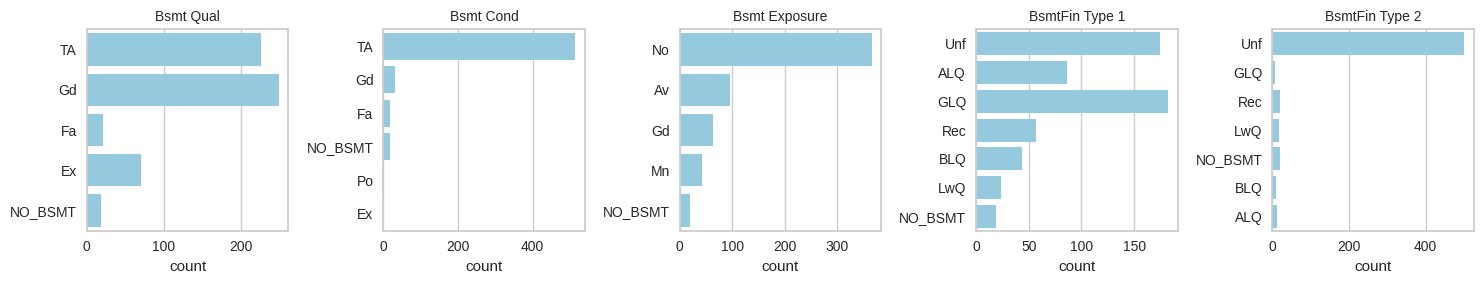

In [ ]:
# Make count plot for each basement feature that was replaced TEST data

# Determine grid size
import math
n_cols = 5
n_rows = math.ceil(len(bsmt_features_to_replace) / n_cols)

# Entire plot
plt.figure(figsize=(n_cols*3, n_rows*3))

# Subplots
for i, col in enumerate(bsmt_features_to_replace):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(y=test_data[col], color='skyblue')
    plt.title(col, fontsize=10)
    plt.ylabel('')

plt.tight_layout()
plt.show()

<Axes: >

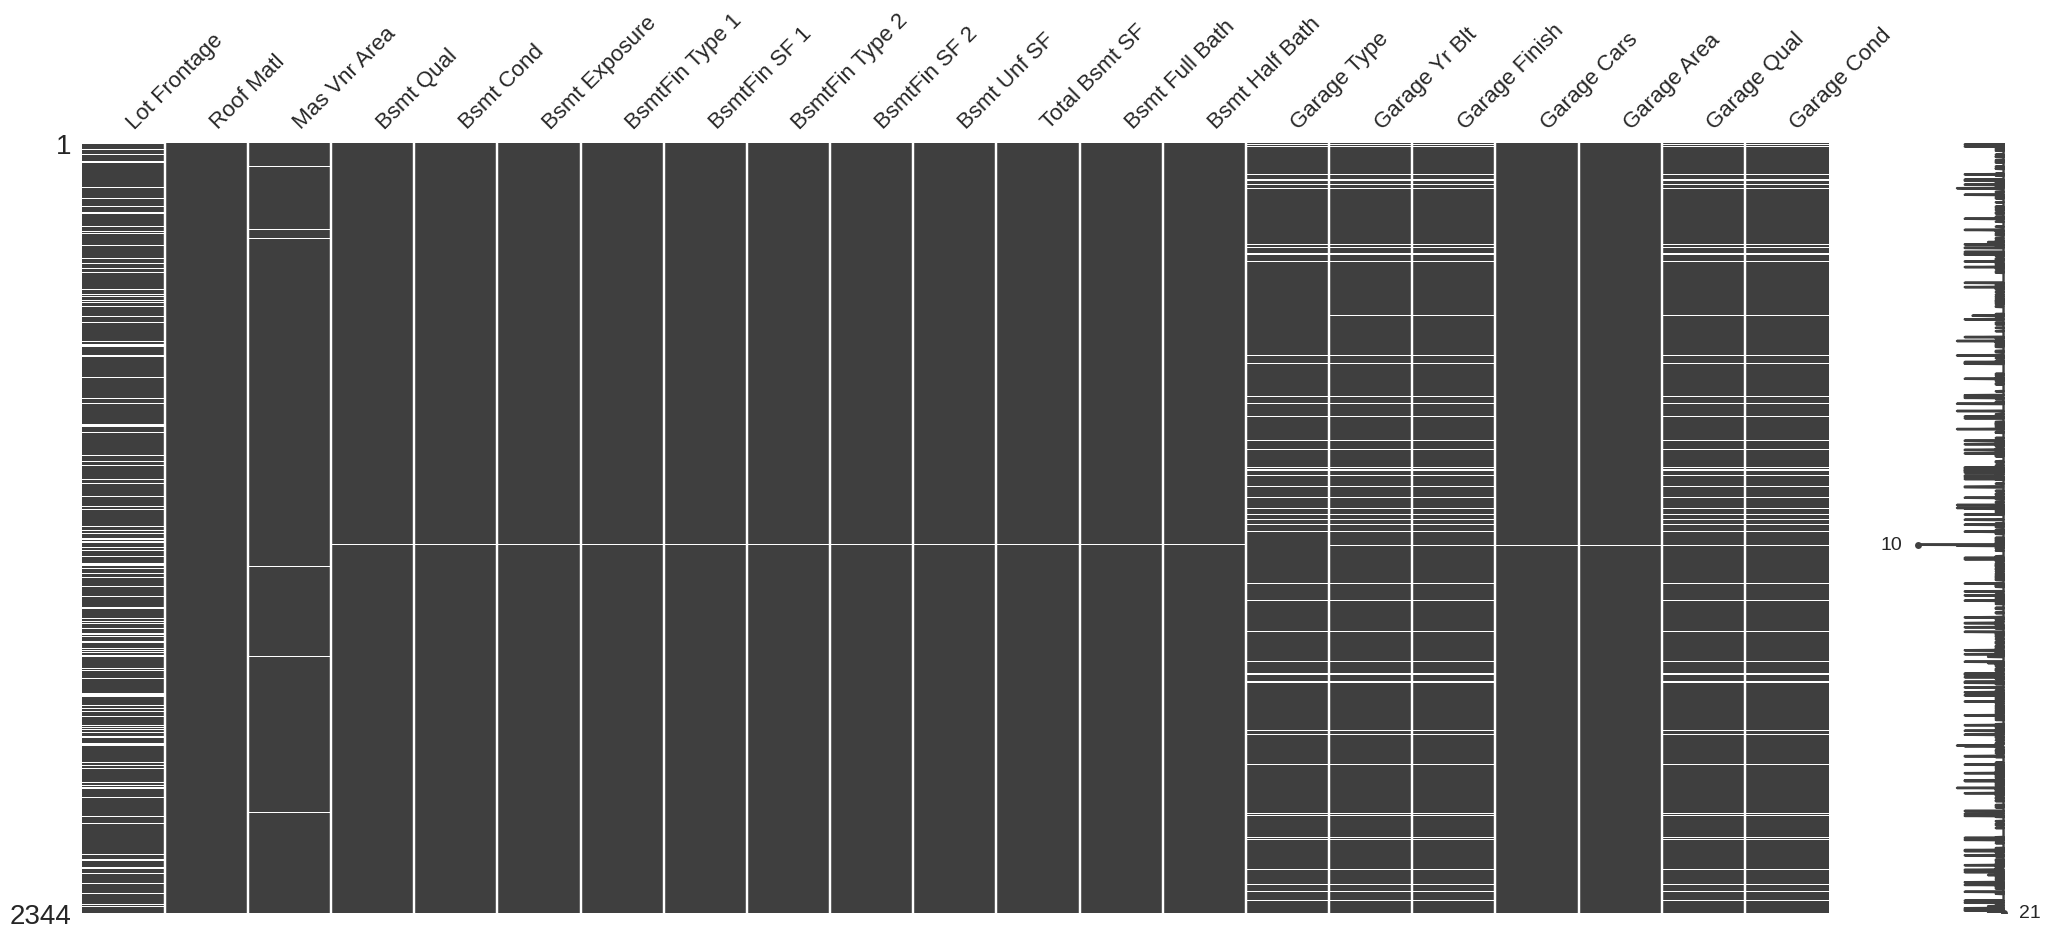

In [ ]:
# Find only features with missing values for better visualization
cols_with_missing = train_data.columns[train_data.isnull().any()]
# Create the matrix of features that have missing values for training data
msno.matrix(train_data[cols_with_missing])

<Axes: >

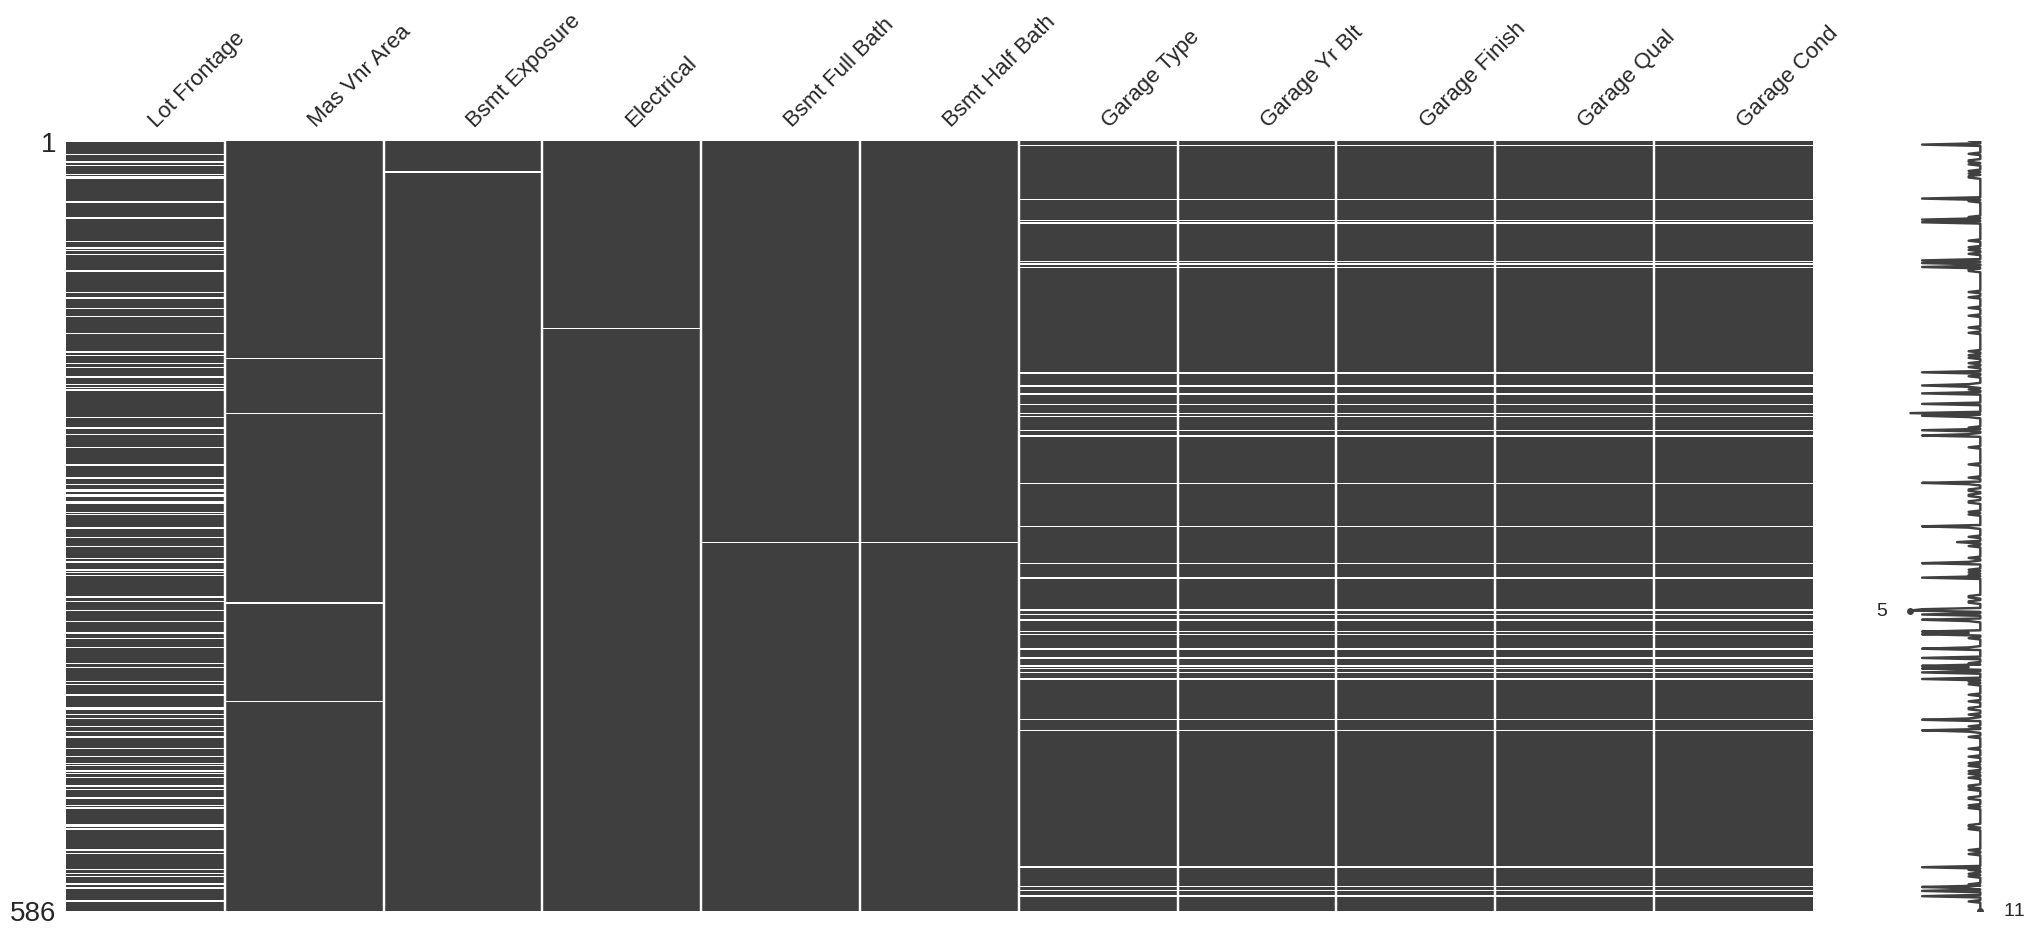

In [ ]:
# Find only features with missing values for better visualization
cols_with_missing = test_data.columns[test_data.isnull().any()]
# Create the matrix of features that have missing values for test data
msno.matrix(test_data[cols_with_missing])

#### Garage features

In [ ]:
# Impute missing garage categorical features as NO_GARAGE
garage_features_to_replace = ['Garage Type', 'Garage Qual', 'Garage Cond', 'Garage Finish']
train_data.loc[train_data['Garage Cars'] == 0, garage_features_to_replace] = train_data.loc[data['Garage Cars'] == 0, garage_features_to_replace].fillna('NO_GARAGE')
test_data.loc[test_data['Garage Cars'] == 0, garage_features_to_replace] = test_data.loc[data['Garage Cars'] == 0, garage_features_to_replace].fillna('NO_GARAGE')

In [ ]:
# Print number missing for each feature with keyword 'garage' TRAIN data
garage_features = [col for col in data.columns if "garage" in col.lower()]
train_data[garage_features].isna().sum().sort_values(ascending=False)

Garage Yr Blt    122
Garage Finish      2
Garage Cond        2
Garage Qual        2
Garage Area        1
Garage Cars        1
Garage Type        0
dtype: int64

In [ ]:
# Print number missing for each feature with keyword 'garage' TEST data
test_data[garage_features].isna().sum().sort_values(ascending=False)

Garage Yr Blt    37
Garage Type       0
Garage Finish     0
Garage Cars       0
Garage Area       0
Garage Qual       0
Garage Cond       0
dtype: int64

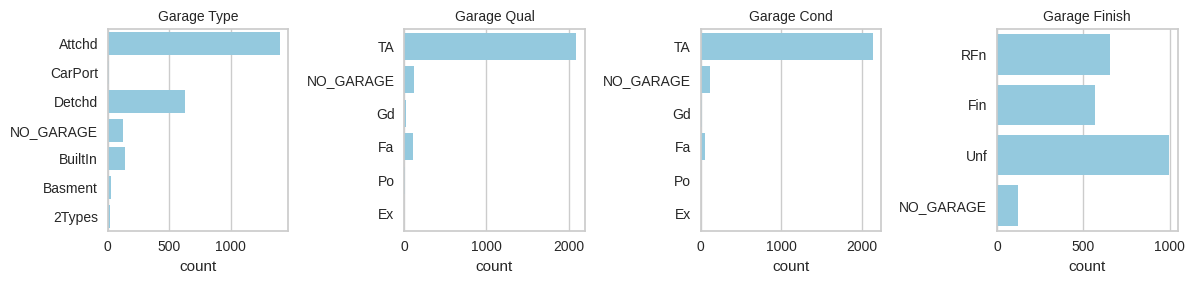

In [ ]:
# Make count plot for each garage feature that was replaced TRAIN data

# Determine grid size
import math
n_cols = 5
n_rows = math.ceil(len(garage_features_to_replace) / n_cols)

# Entire plot
plt.figure(figsize=(n_cols*3, n_rows*3))

# Subplots
for i, col in enumerate(garage_features_to_replace):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(y=train_data[col], color='skyblue')
    plt.title(col, fontsize=10)
    plt.ylabel('')

plt.tight_layout()
plt.show()

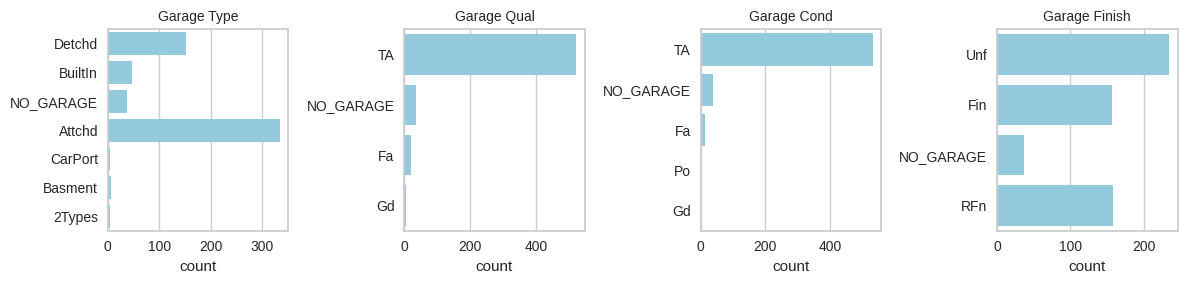

In [ ]:
# Make count plot for each garage feature that was replaced TEST data

# Determine grid size
import math
n_cols = 5
n_rows = math.ceil(len(garage_features_to_replace) / n_cols)

# Entire plot
plt.figure(figsize=(n_cols*3, n_rows*3))

# Subplots
for i, col in enumerate(garage_features_to_replace):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(y=test_data[col], color='skyblue')
    plt.title(col, fontsize=10)
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
# Impute garage year built as 0 if no garage present
train_data.loc[train_data['Garage Cars'] == 0, 'Garage Yr Blt'] = train_data.loc[data['Garage Cars'] == 0, 'Garage Yr Blt'].fillna(0)
test_data.loc[data['Garage Cars'] == 0, 'Garage Yr Blt'] = test_data.loc[data['Garage Cars'] == 0, 'Garage Yr Blt'].fillna(0)

In [ ]:
# Print number missing for each feature with keyword 'garage' TRAIN data
garage_features = [col for col in data.columns if "garage" in col.lower()]
train_data[garage_features].isna().sum().sort_values(ascending=False)

Garage Yr Blt    2
Garage Finish    2
Garage Cond      2
Garage Qual      2
Garage Area      1
Garage Cars      1
Garage Type      0
dtype: int64

In [ ]:
# Print number missing for each feature with keyword 'garage' TEST data
test_data[garage_features].isna().sum().sort_values(ascending=False)

Garage Type      0
Garage Yr Blt    0
Garage Finish    0
Garage Cars      0
Garage Area      0
Garage Qual      0
Garage Cond      0
dtype: int64

<Axes: >

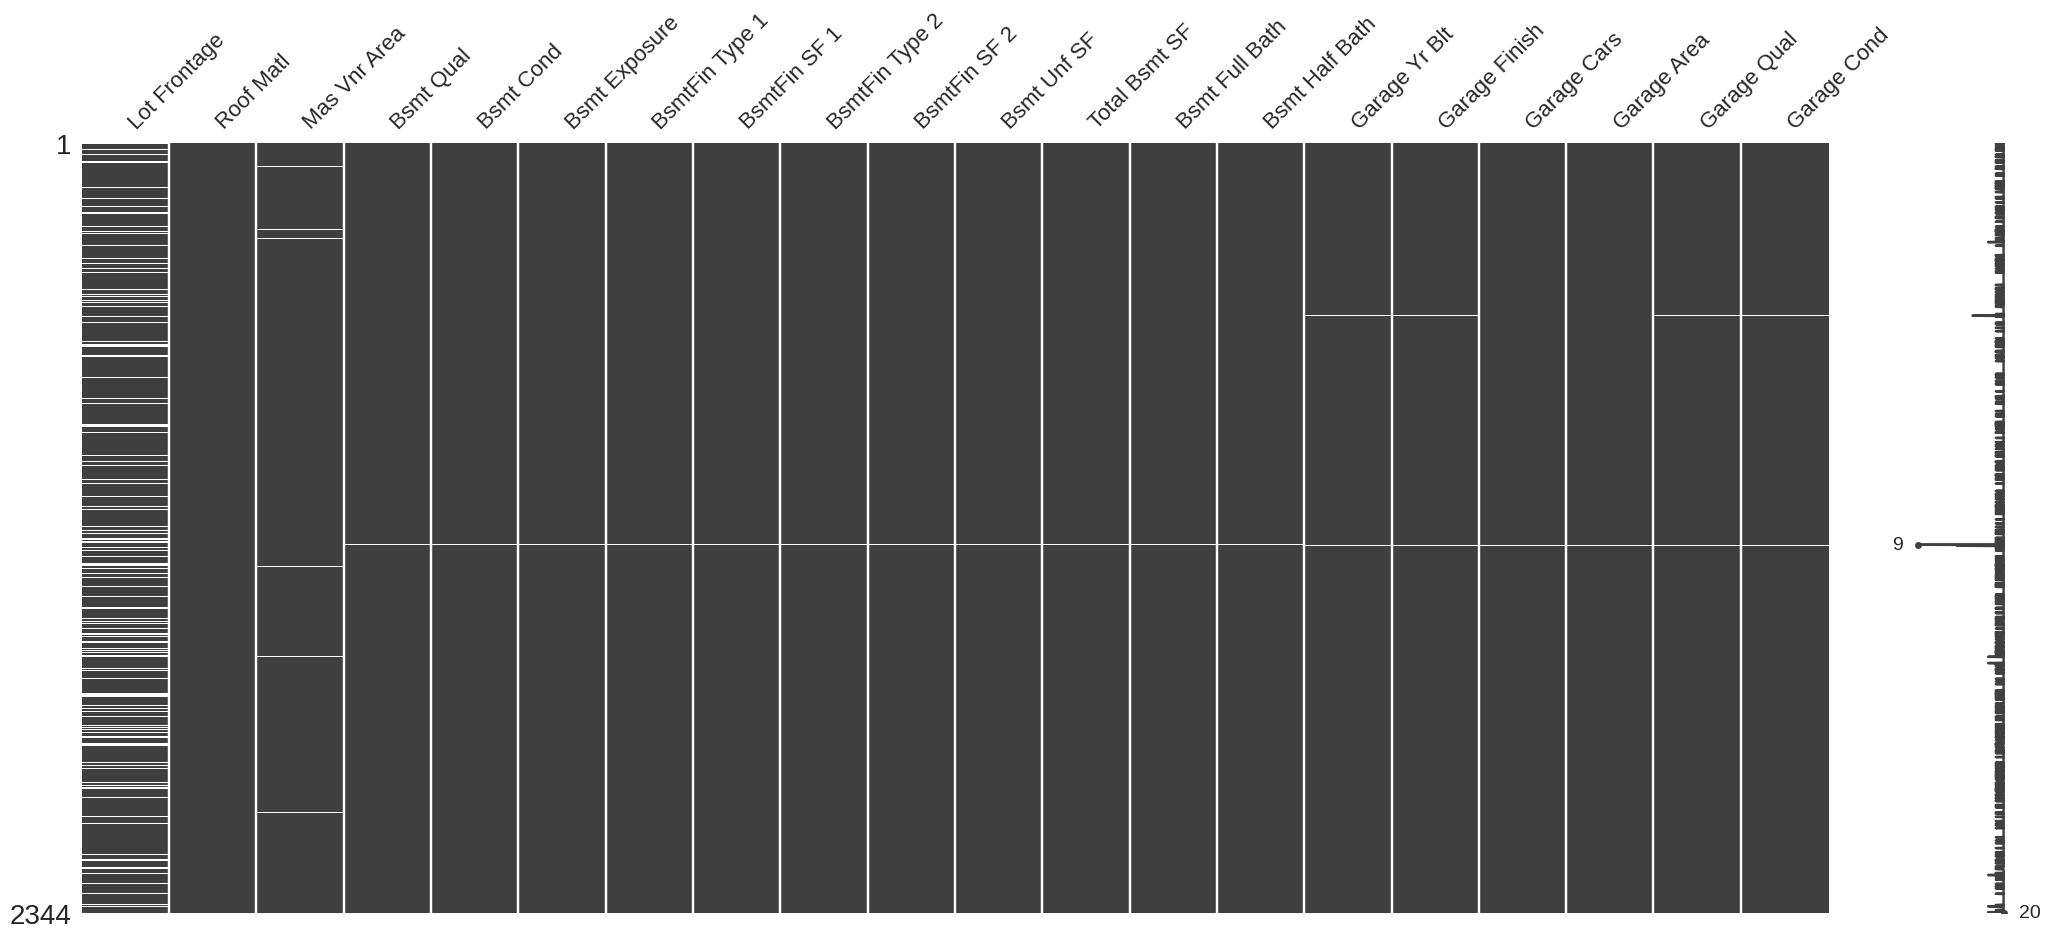

In [ ]:
# Find only features with missing values for better visualization
cols_with_missing = train_data.columns[train_data.isnull().any()]
# Create the matrix of features that have missing values for training data
msno.matrix(train_data[cols_with_missing])

<Axes: >

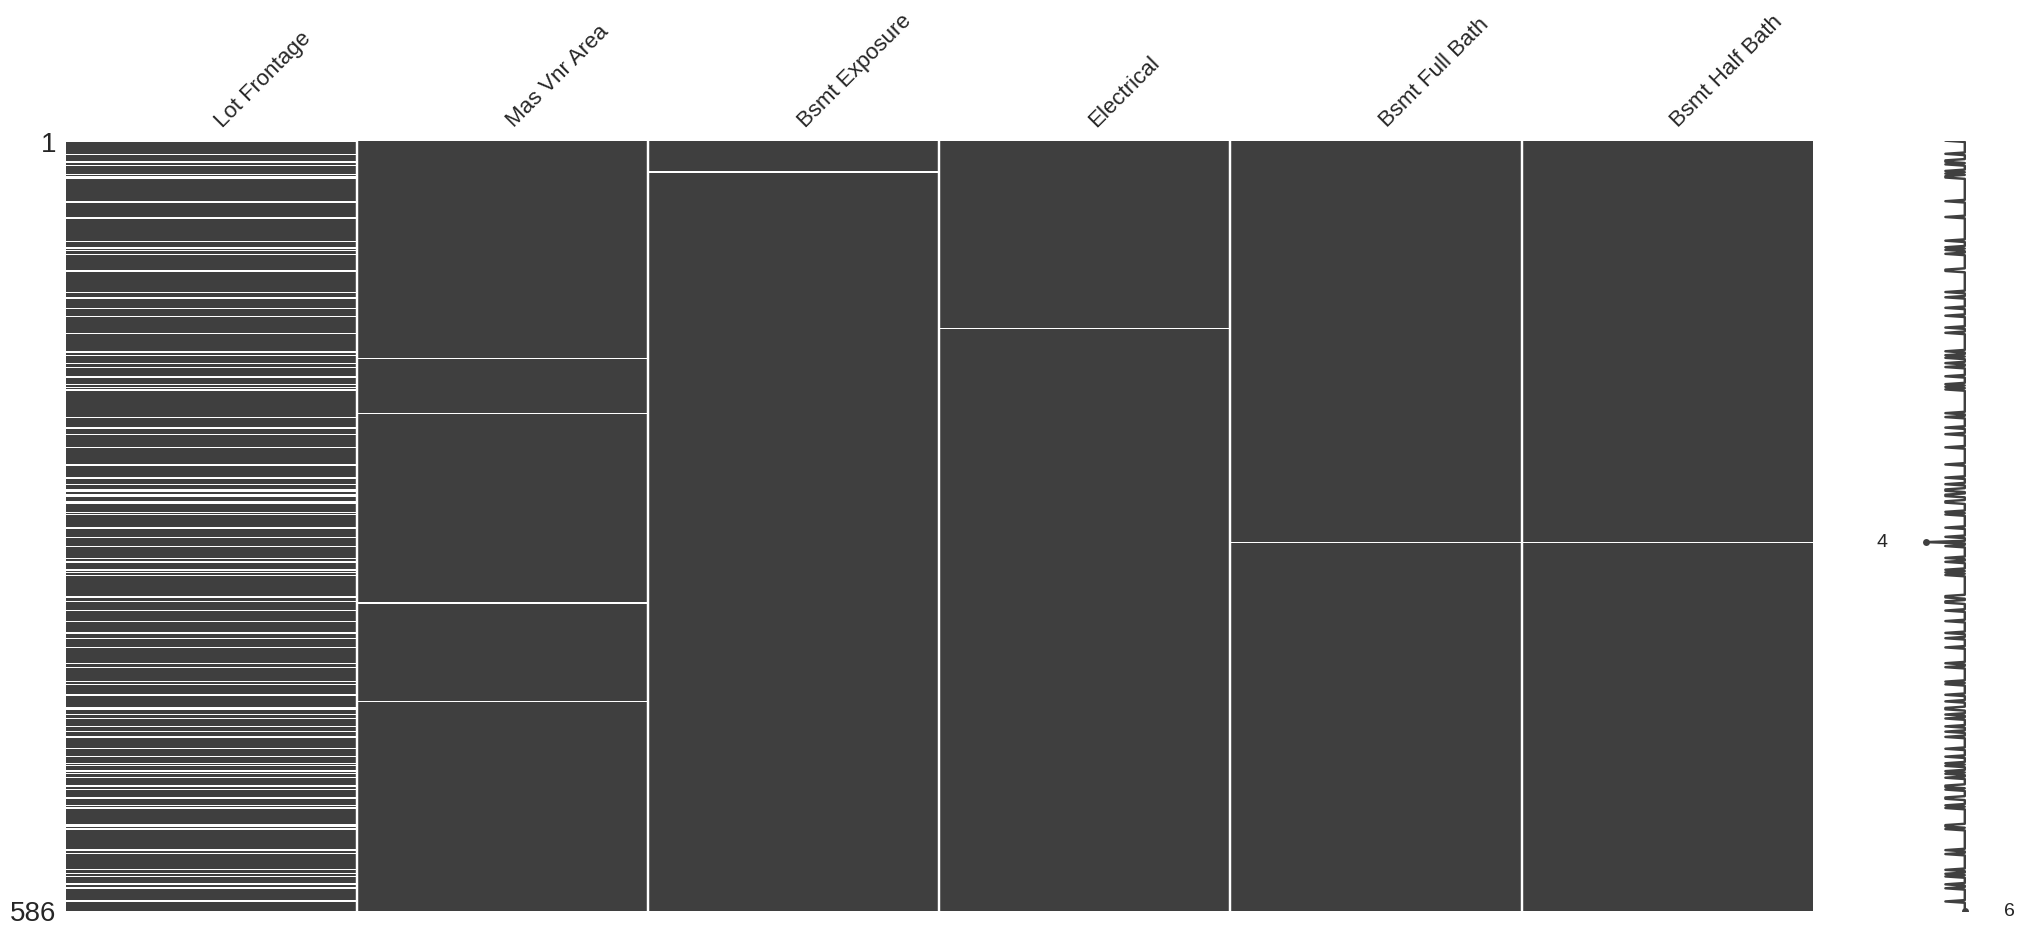

In [ ]:
# Find only features with missing values for better visualization
cols_with_missing = test_data.columns[test_data.isnull().any()]
# Create the matrix of features that have missing values for test data
msno.matrix(test_data[cols_with_missing])

#### Lot frontage feature

This is a tough feature to deal with the missingness. This is missing 16% of the data so I can't drop them. I am imputing 0 for the missing values and creating a binary missing flag.

In [ ]:
# Impute 0 for missing LotFrontage
train_data['Lot Frontage'] = train_data['Lot Frontage'].fillna(0)

# Create a missing indicator
train_data['LotFrontage_missing'] = train_data['Lot Frontage'].isnull().astype(int)

In [ ]:
# Impute 0 for missing LotFrontage
test_data['Lot Frontage'] = test_data['Lot Frontage'].fillna(0)

# Create a missing indicator
test_data['LotFrontage_missing'] = test_data['Lot Frontage'].isnull().astype(int)

<Axes: >

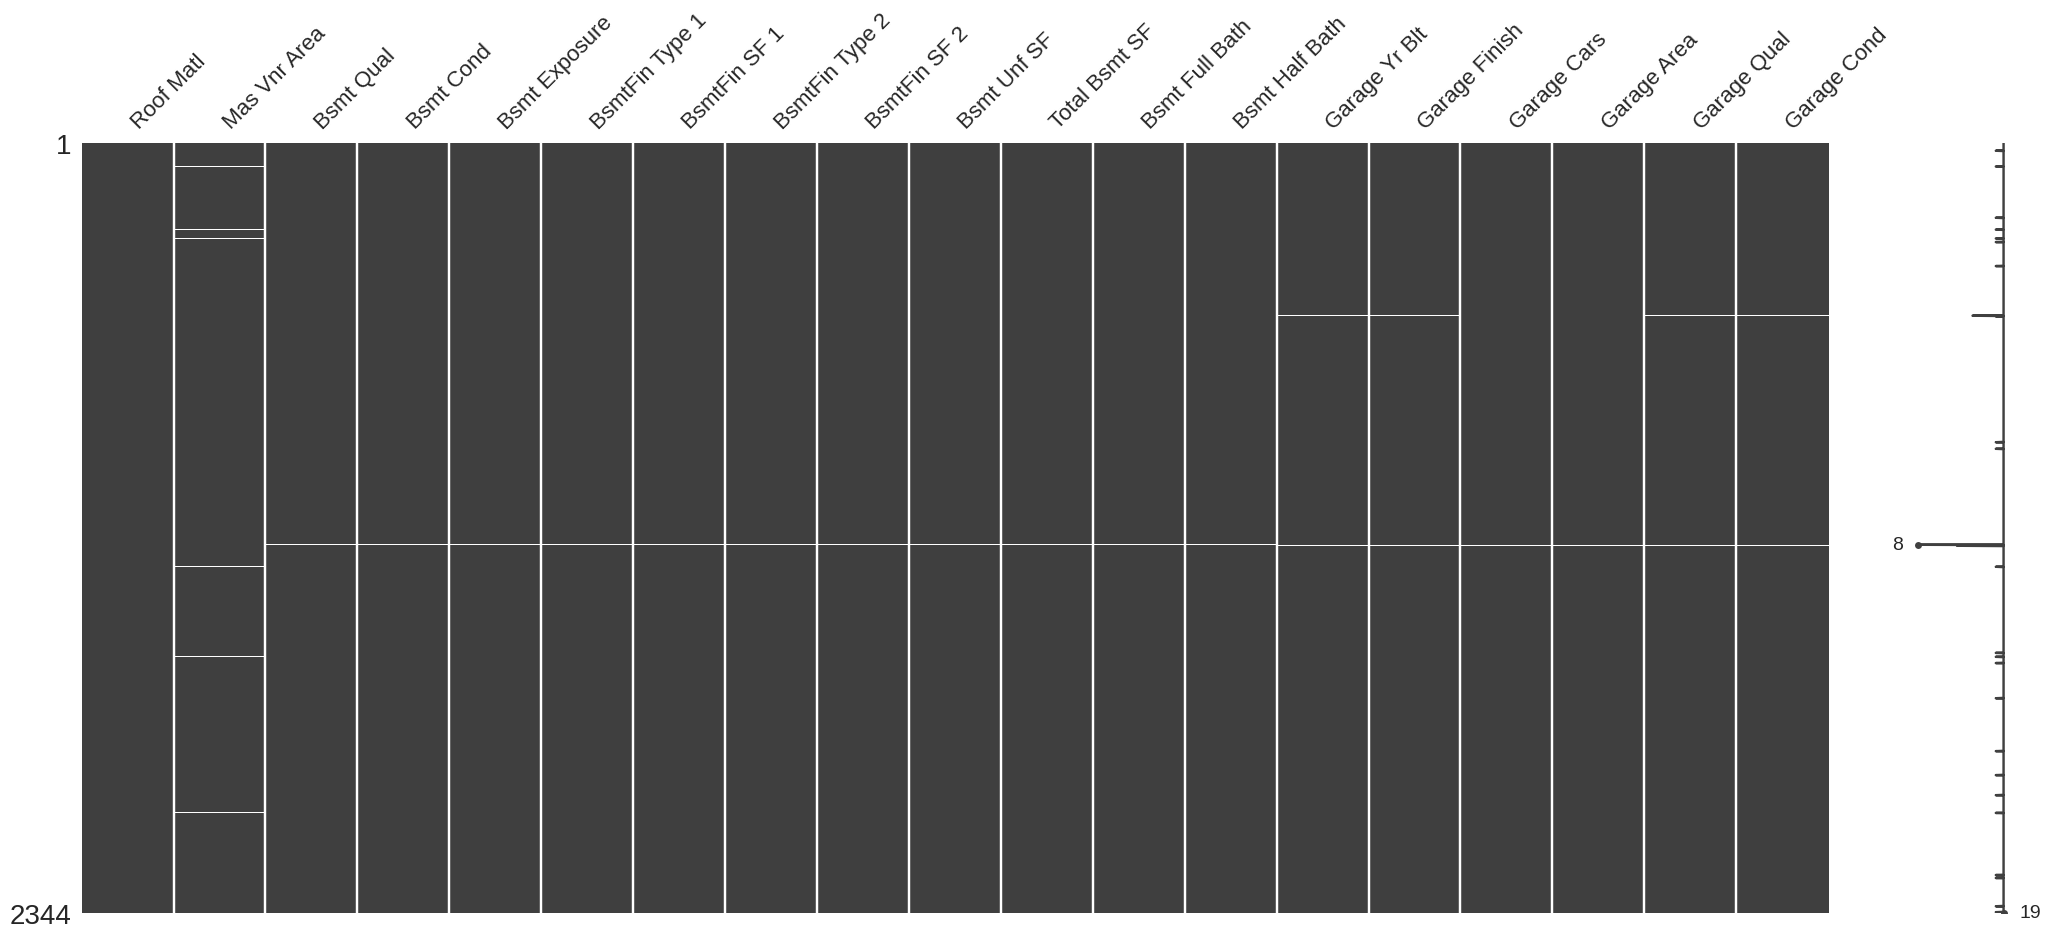

In [ ]:
# Find only features with missing values for better visualization
cols_with_missing = train_data.columns[train_data.isnull().any()]
# Create the matrix of features that have missing values for training data
msno.matrix(train_data[cols_with_missing])

<Axes: >

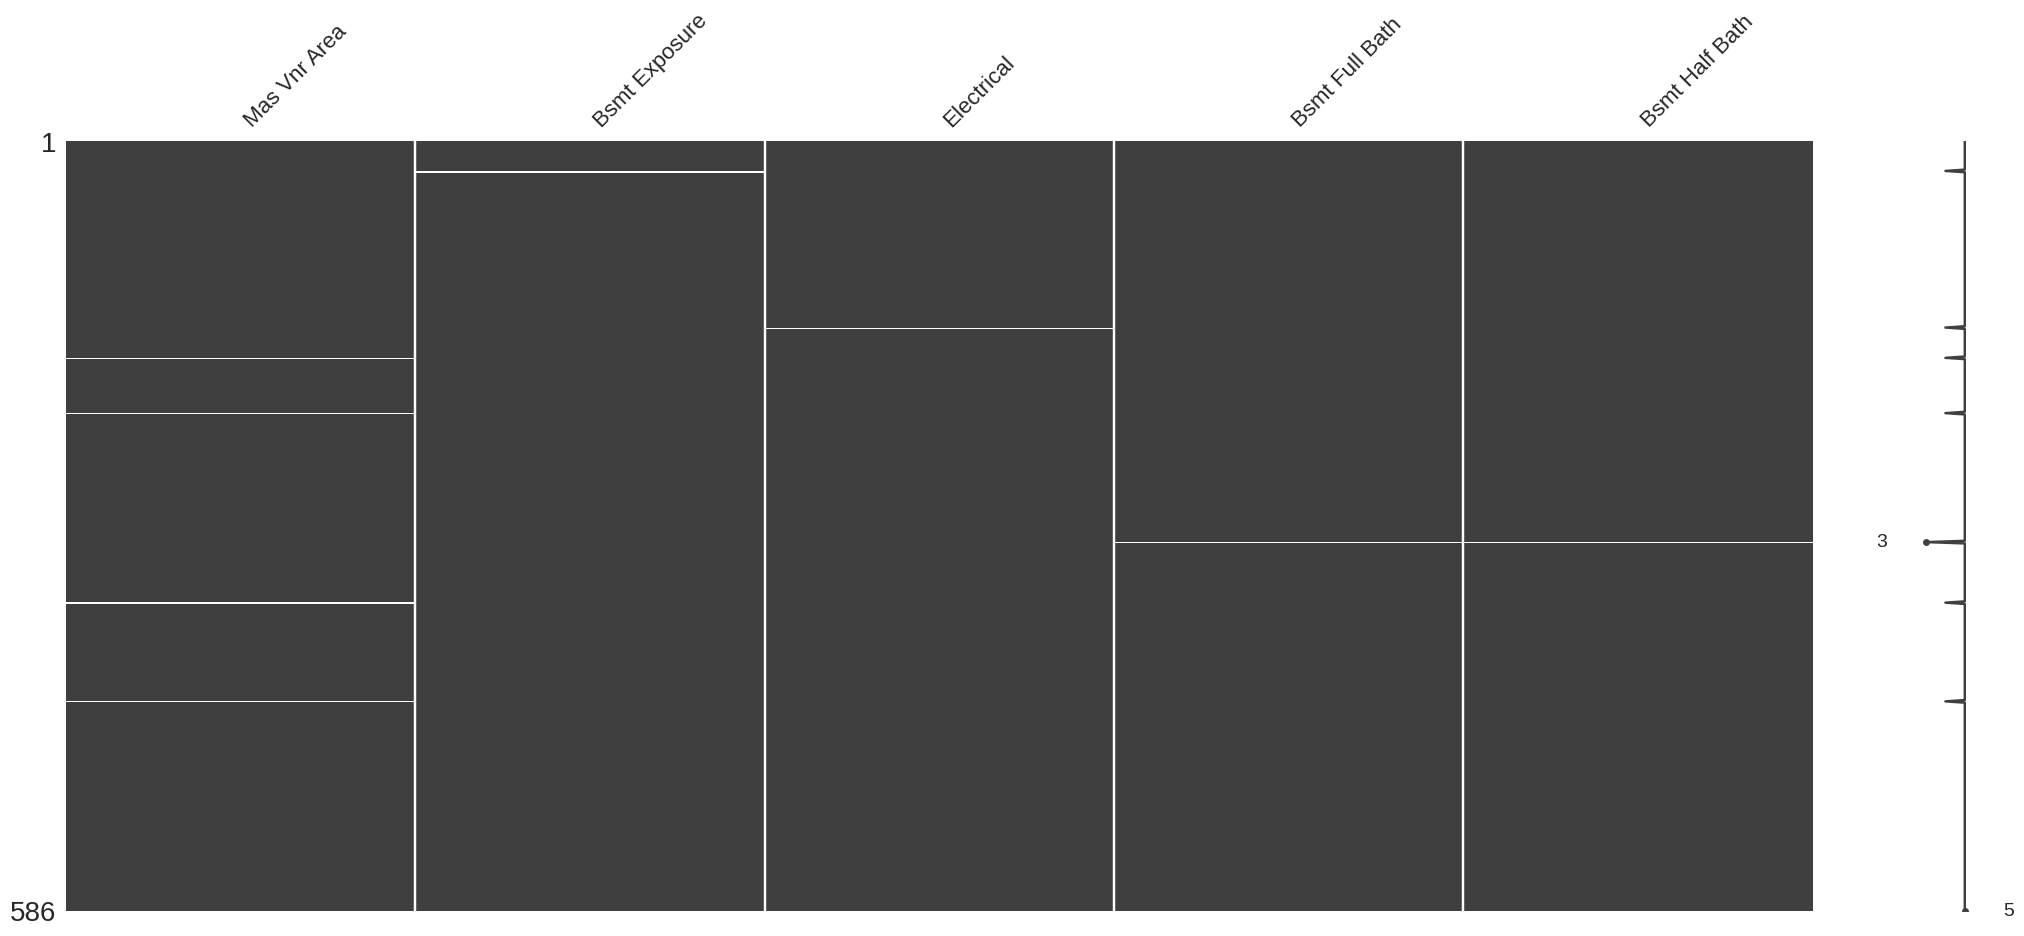

In [ ]:
# Find only features with missing values for better visualization
cols_with_missing = test_data.columns[test_data.isnull().any()]
# Create the matrix of features that have missing values for training data
msno.matrix(test_data[cols_with_missing])

#### Remove single instance with missing features

Remove remaining missing values are about 1% of the data. I will drop the remaining missing data.

In [ ]:
# Remove any remaining missing value that could not be imputed

<Axes: >

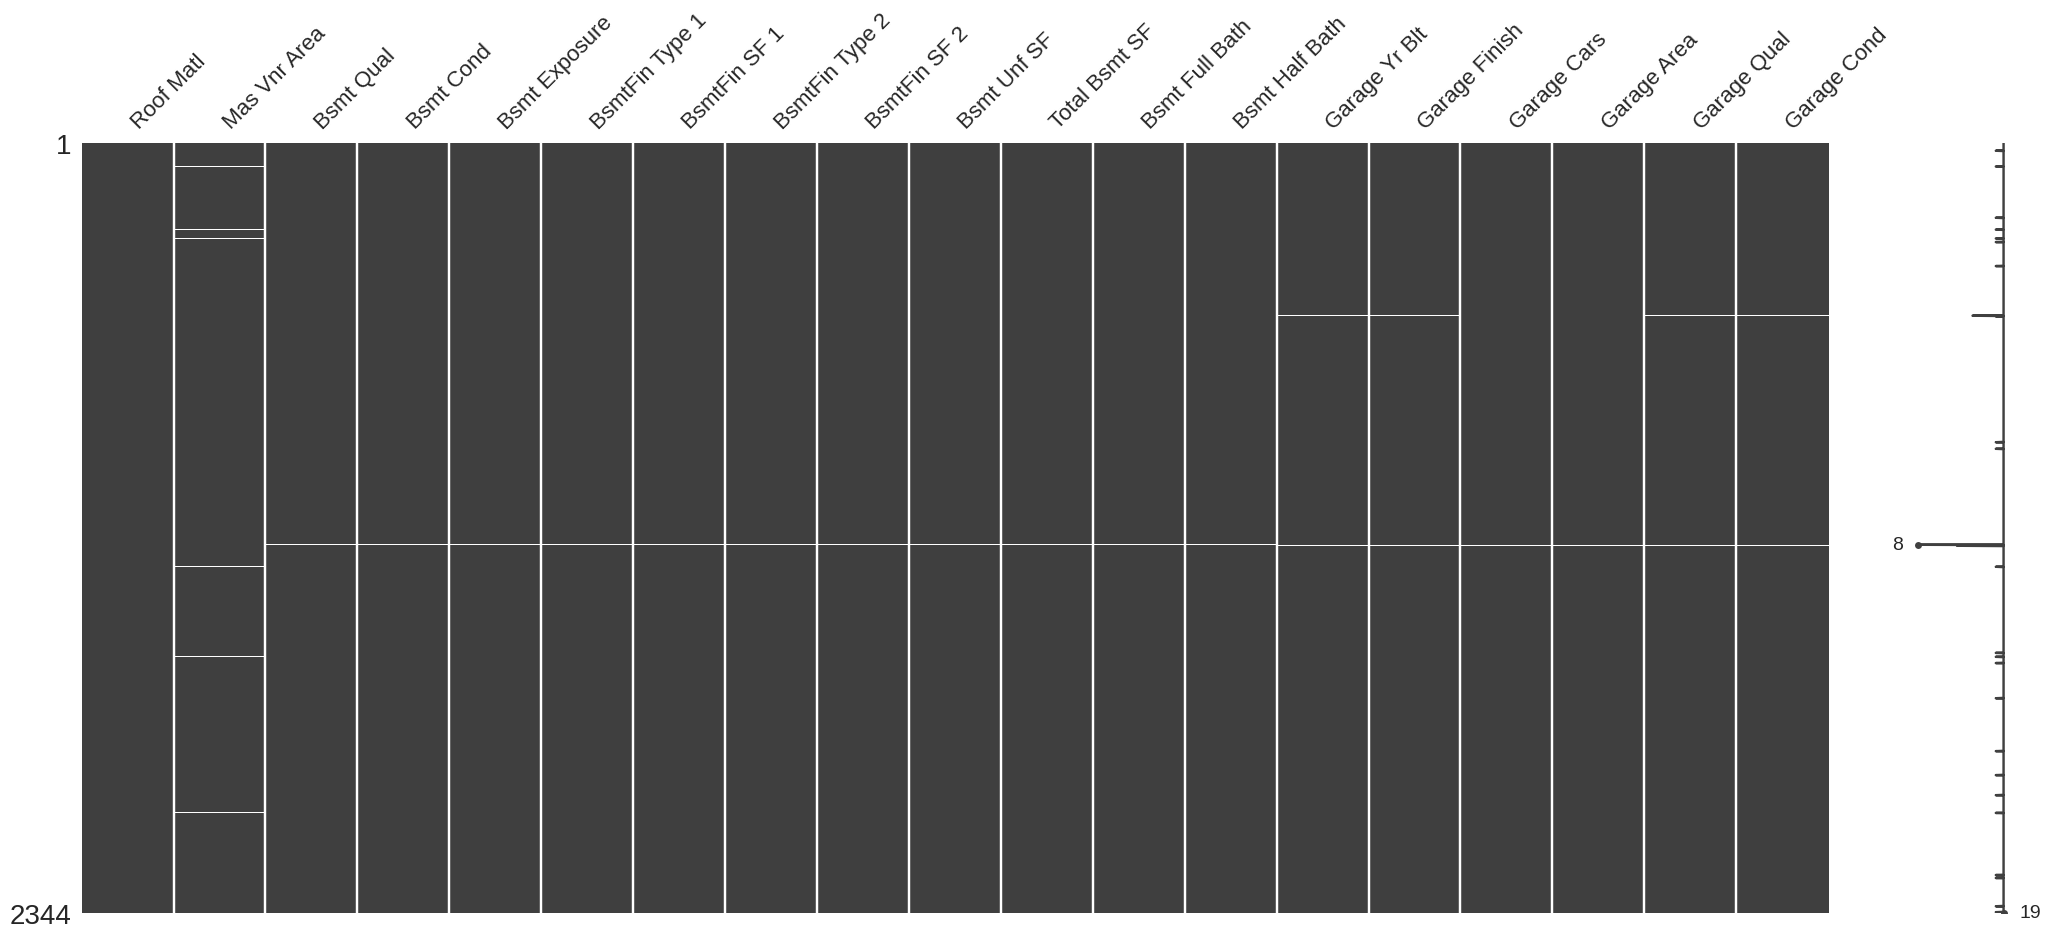

In [ ]:
# Find only features with missing values for better visualization
cols_with_missing = train_data.columns[train_data.isnull().any()]
# Create the matrix of features that have missing values for training data
msno.matrix(train_data[cols_with_missing])

<Axes: >

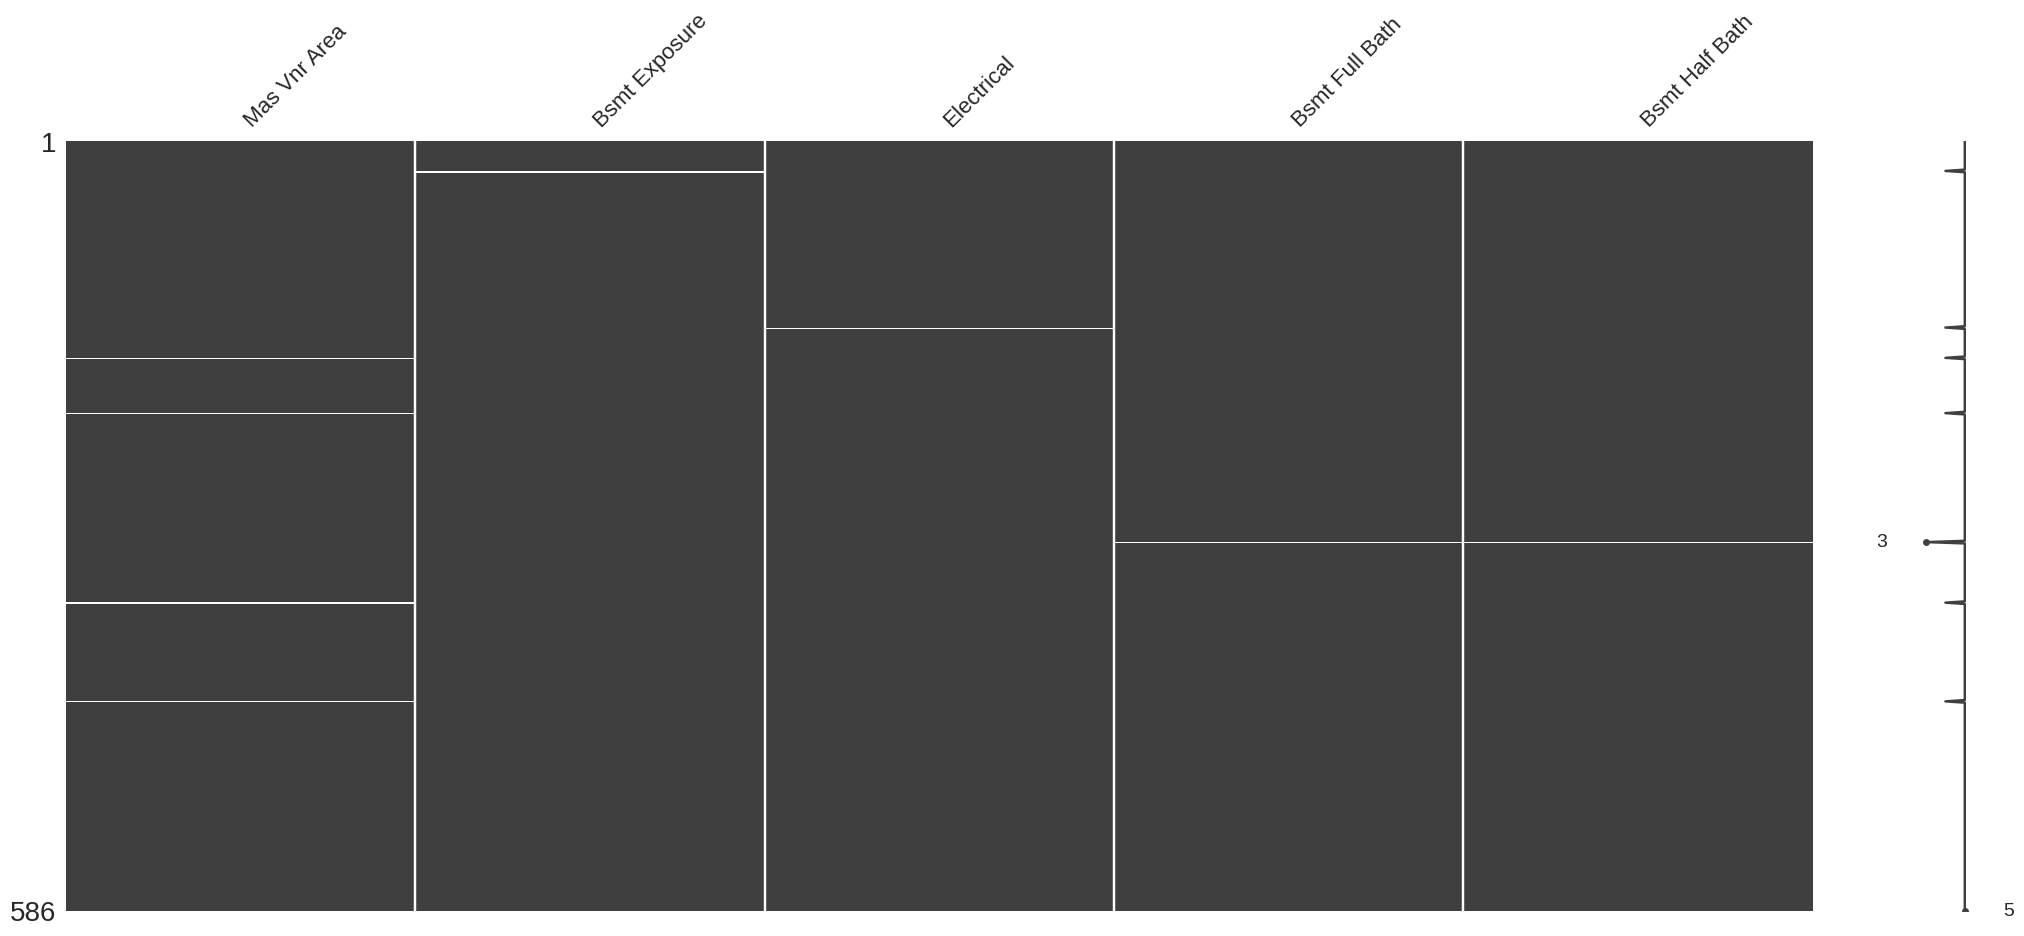

In [ ]:
# Find only features with missing values for better visualization
cols_with_missing = test_data.columns[test_data.isnull().any()]
# Create the matrix of features that have missing values for training data
msno.matrix(test_data[cols_with_missing])

In [ ]:
# Drop rows with missing values remaining
train_data = train_data.dropna()
test_data = test_data.dropna()

<Axes: >

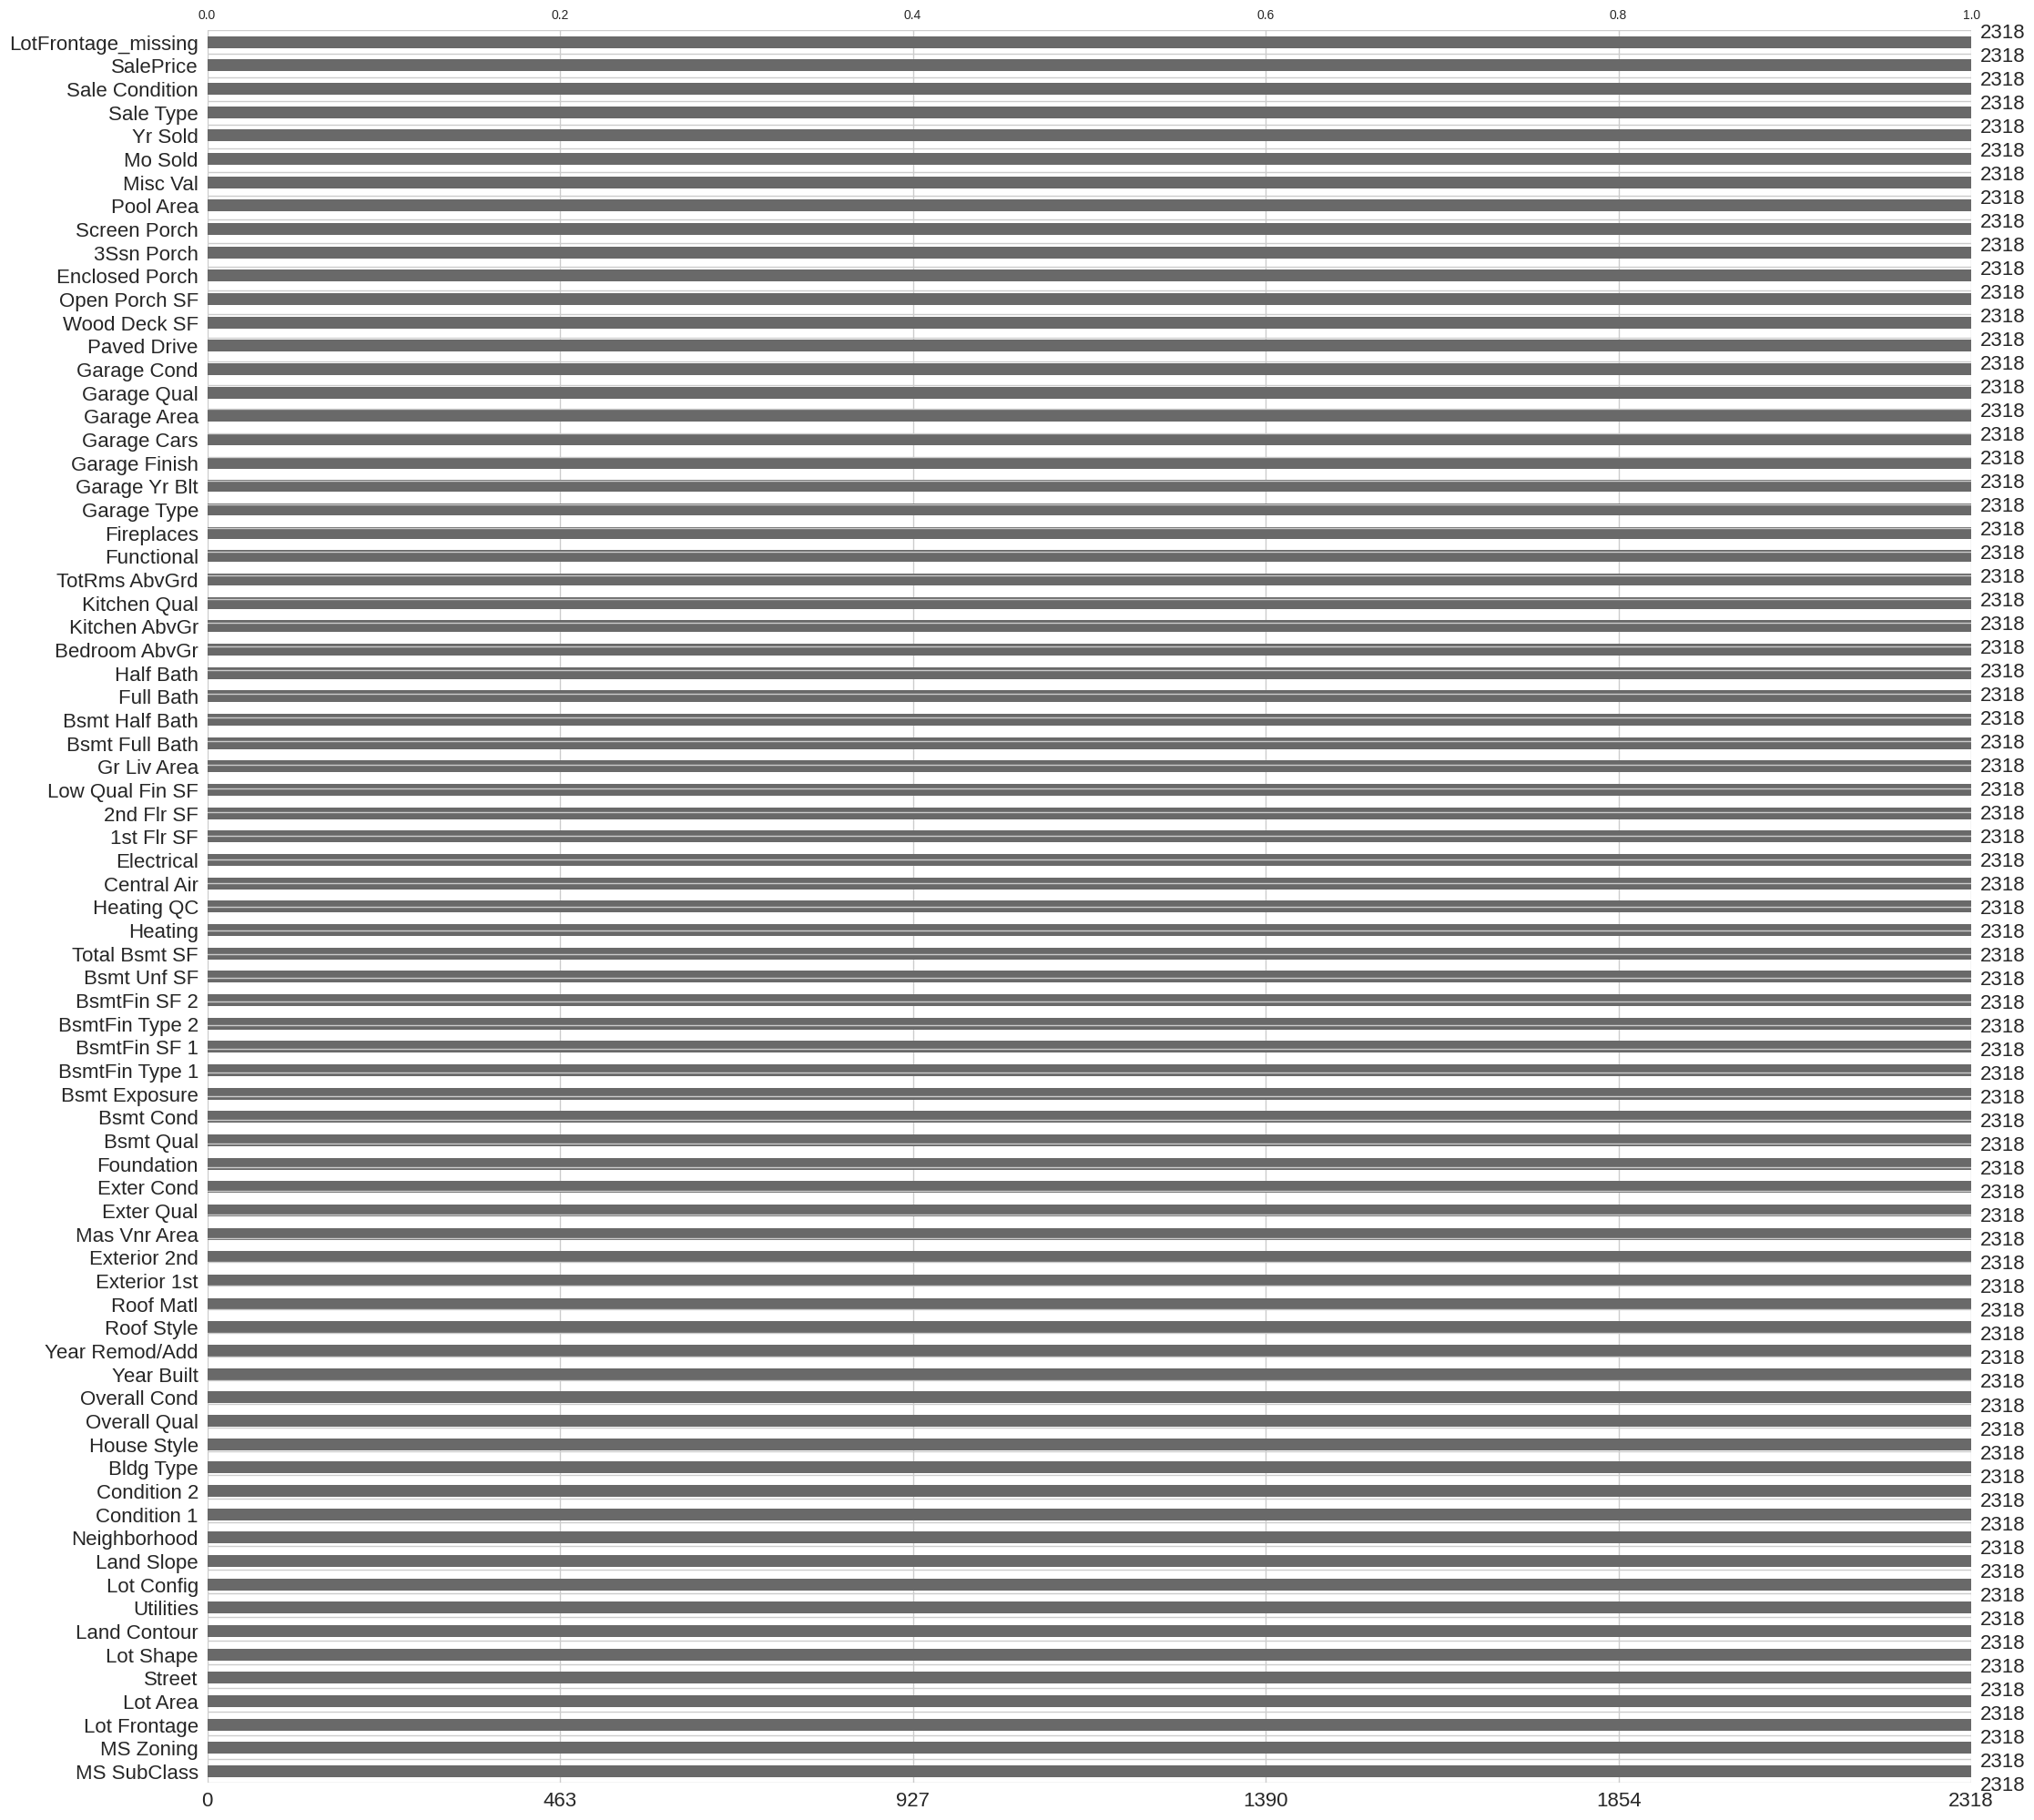

In [ ]:
# Create the matrix of features that have missing values for training data
msno.bar(train_data)

<Axes: >

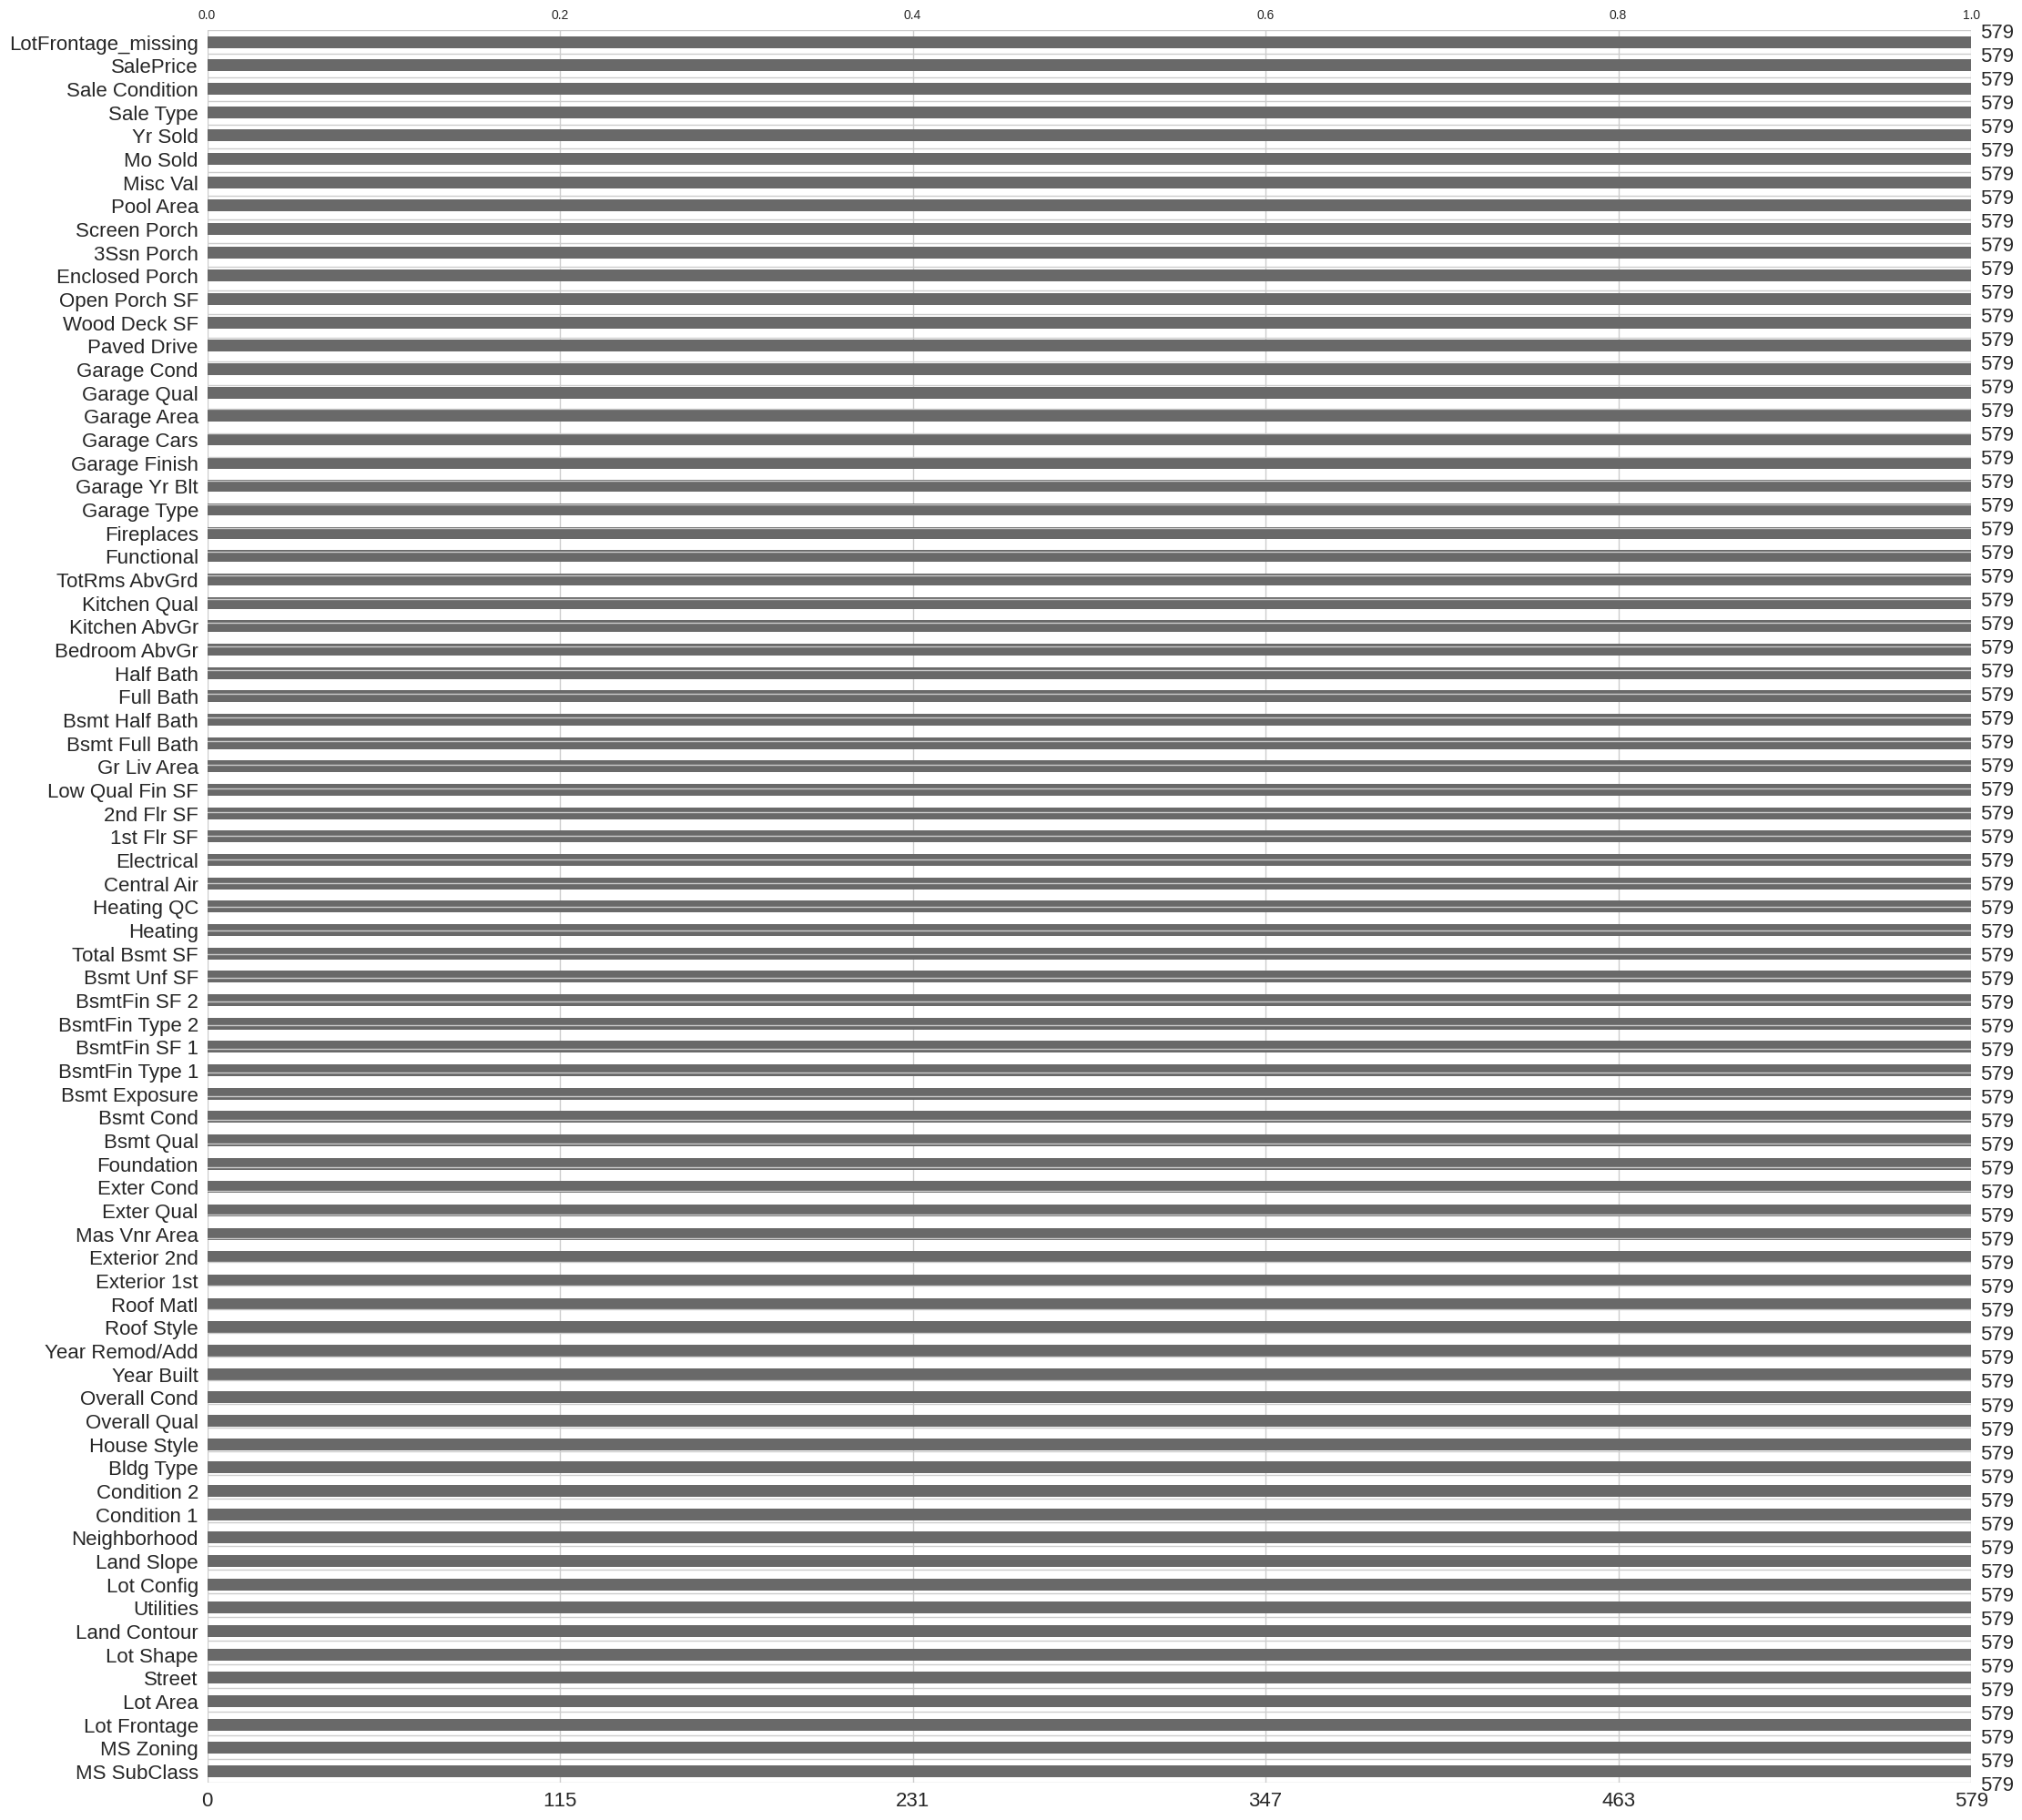

In [ ]:
# Create the matrix of features that have missing values for training data
msno.bar(test_data)

In [ ]:
train_data.shape

(2318, 75)

In [ ]:
test_data.shape

(579, 75)

## Outliers

#### Training data

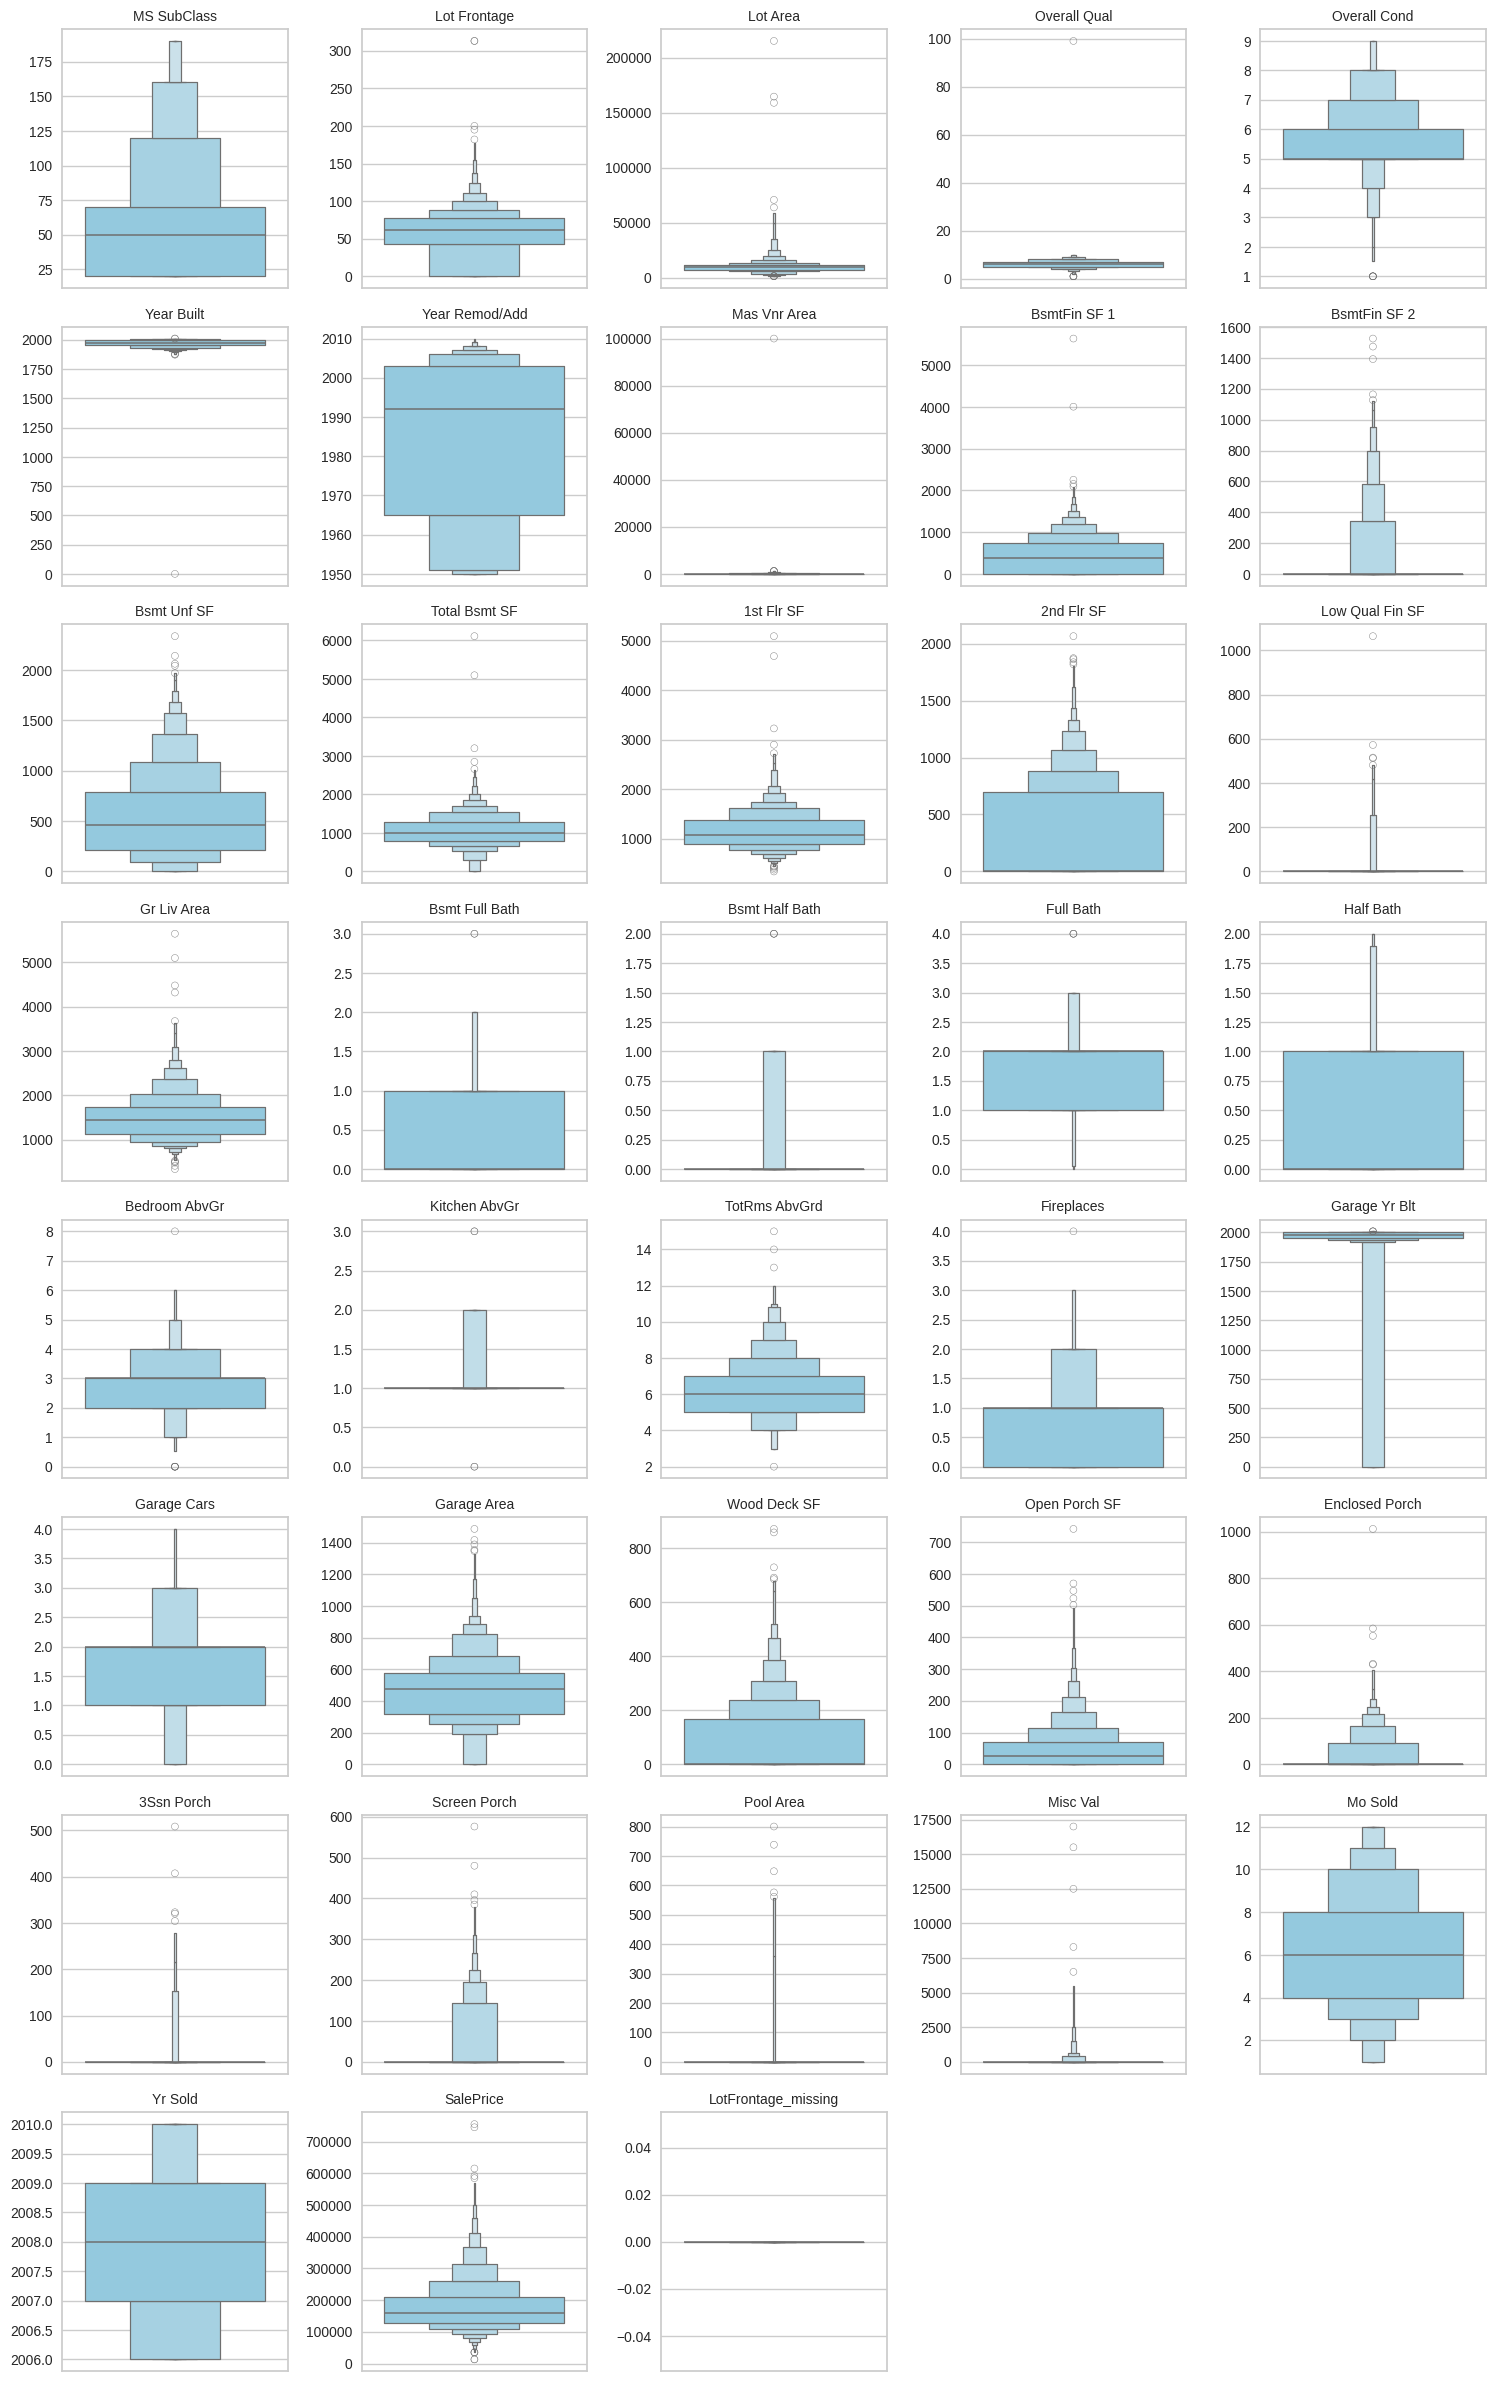

In [ ]:
# Make box plot for each numeric feature
# Select only numeric columns
numeric_cols = train_data.select_dtypes(include='number').columns

# Determine grid size
import math
n_cols = 5
n_rows = math.ceil(len(numeric_cols) / n_cols)

# Entire plot
plt.figure(figsize=(n_cols*3, n_rows*3))

# Subplots
for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxenplot(y=train_data[col], color='skyblue')
    plt.title(col, fontsize=10)
    plt.ylabel('')

plt.tight_layout()
plt.show()

I want to investigate

'Overall Qual'

'Mas Vnr Area'

'Year Built'

##### Overall Qual

<Axes: xlabel='Overall Qual'>

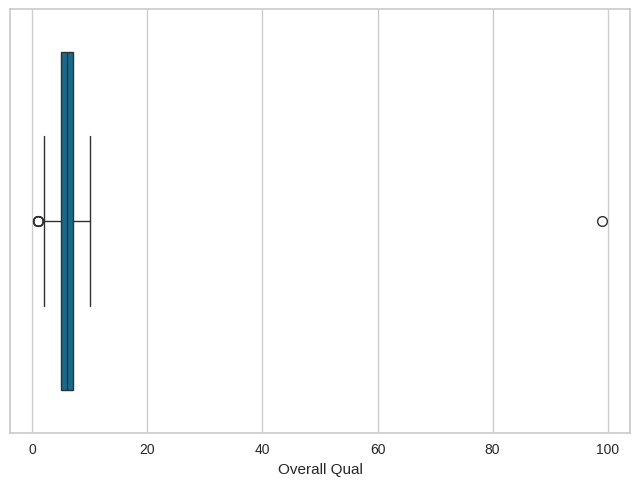

In [ ]:
# Make box plot for overall qual
sns.boxplot(x=train_data['Overall Qual'])

In [ ]:
# Look into max val
overall_qual_max_index = train_data.loc[train_data['Overall Qual'].idxmax()]
overall_qual_max_index

MS SubClass                20
MS Zoning                  RL
Lot Frontage              0.0
Lot Area                 9200
Street                   Pave
                        ...  
Yr Sold                  2008
Sale Type                 WD 
Sale Condition         Normal
SalePrice              130250
LotFrontage_missing         0
Name: 1444, Length: 75, dtype: object

In [ ]:
# Chack describe for feature excluding max val
overall_qual_temp = (train_data['Overall Qual'][train_data['Overall Qual'] != train_data['Overall Qual'].max()])
overall_qual_temp.describe()

count    2317.000000
mean        6.053949
std         1.386503
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: Overall Qual, dtype: float64

<Axes: xlabel='Overall Qual', ylabel='Count'>

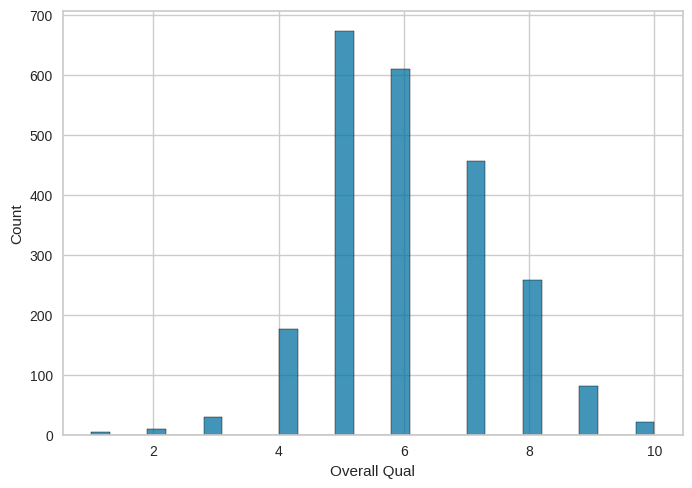

In [ ]:
# Check distribution
sns.histplot(x=overall_qual_temp)

In [ ]:
# Remove max val outlier
train_data.loc[train_data['Overall Qual'].idxmax(), 'Overall Qual'] = np.nan

In [ ]:
# Create and fit a mean imputer
mean_imputer = SimpleImputer(strategy='mean')
train_data['Overall Qual'] = mean_imputer.fit_transform(train_data[['Overall Qual']])

<Axes: xlabel='Overall Qual', ylabel='Count'>

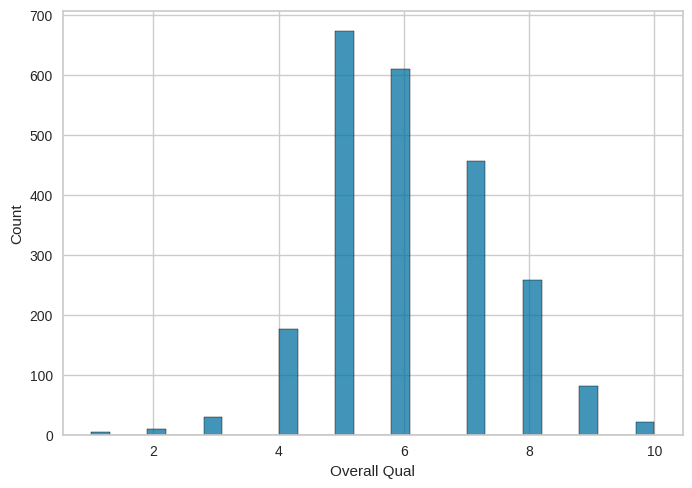

In [ ]:
# Check distribution after imputation
sns.histplot(x=overall_qual_temp)

In [ ]:
# Chack describe for feature
train_data['Overall Qual'].max()

10.0

In [ ]:
# Show stats
train_data['Overall Qual'].describe()

count    2318.000000
mean        6.053949
std         1.386204
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: Overall Qual, dtype: float64

<Axes: xlabel='Overall Qual'>

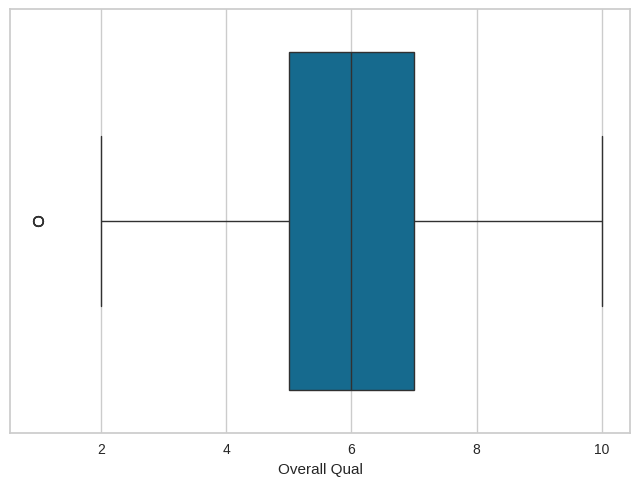

In [ ]:
# Make box plot for overall qual
sns.boxplot(x=train_data['Overall Qual'])

##### Mas Vrn Area

<Axes: xlabel='Mas Vnr Area'>

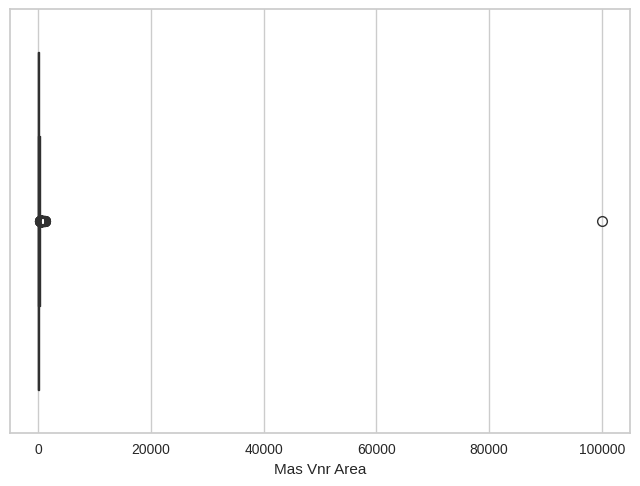

In [ ]:
# Make box plot for mas vrn area
sns.boxplot(x=train_data['Mas Vnr Area'])

In [ ]:
# Look into max val
overall_qual_max_index = train_data.loc[train_data['Mas Vnr Area'].idxmax()]
overall_qual_max_index

MS SubClass                 50
MS Zoning                   RL
Lot Frontage              80.0
Lot Area                  9600
Street                    Pave
                        ...   
Yr Sold                   2008
Sale Type                  WD 
Sale Condition         Abnorml
SalePrice               119000
LotFrontage_missing          0
Name: 1224, Length: 75, dtype: object

In [ ]:
# Chack describe for feature excluding max val
mas_vrn_area_temp = (train_data['Mas Vnr Area'][train_data['Mas Vnr Area'] != train_data['Mas Vnr Area'].max()])
mas_vrn_area_temp.describe()

count    2317.000000
mean       98.453604
std       172.237232
min         0.000000
25%         0.000000
50%         0.000000
75%       158.000000
max      1290.000000
Name: Mas Vnr Area, dtype: float64

<Axes: xlabel='Mas Vnr Area', ylabel='Count'>

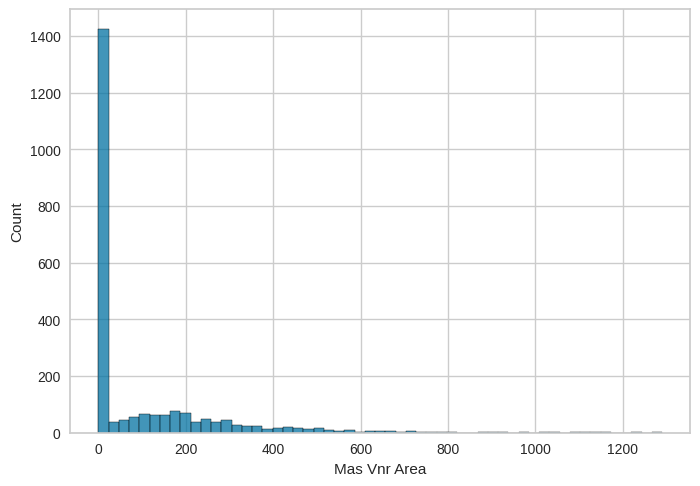

In [ ]:
# Check distribution
sns.histplot(x=mas_vrn_area_temp)

This feature has a lot of 0 values. This instance had an entry but it is an outlier so we can say that this should have a non 0 value. I want to remove the 0 values then train the imputer.

In [ ]:
# Remove 0 values
mas_vrn_area_temp= mas_vrn_area_temp[mas_vrn_area_temp != 0]

<Axes: xlabel='Mas Vnr Area', ylabel='Count'>

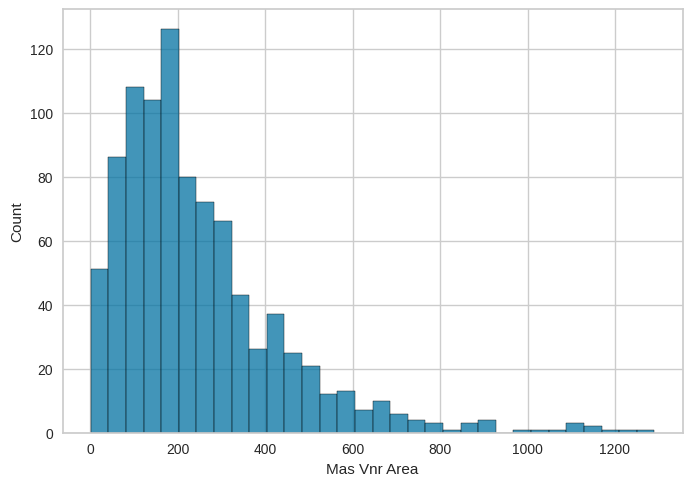

In [ ]:
# Check distribution
sns.histplot(x=mas_vrn_area_temp)

In [ ]:
# Remove max val outlier
train_data.loc[train_data['Mas Vnr Area'].idxmax(), 'Mas Vnr Area'] = np.nan

In [ ]:
# Create and fit a mean imputer
mean_imputer = SimpleImputer(strategy='median')
train_data['Mas Vnr Area'] = mean_imputer.fit_transform(train_data[['Mas Vnr Area']])

<Axes: xlabel='Mas Vnr Area'>

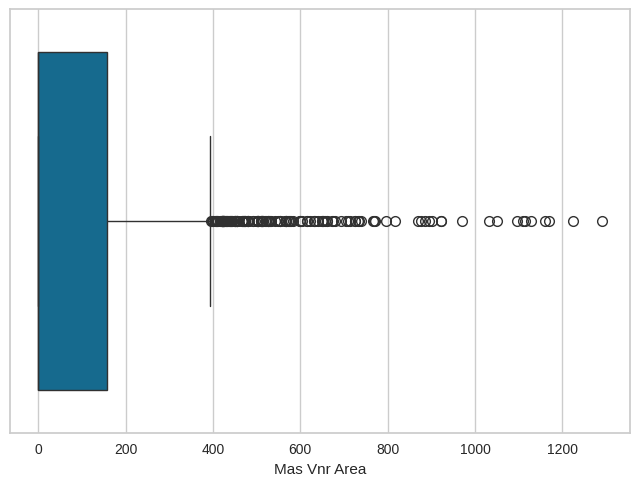

In [ ]:
# Make box plot for mas vrn area
sns.boxplot(x=train_data['Mas Vnr Area'])

##### Year Built

I am dropping the single outlier in this feature.

In [ ]:
# Check shape
train_data.shape

(2318, 75)

In [ ]:
# Print min val
train_data['Year Built'].min()

1

In [ ]:
# Drop min val
train_data = train_data.drop(train_data['Year Built'].idxmin())

In [ ]:
# Check shape
train_data.shape

(2317, 75)

In [ ]:
# Print min val
train_data['Year Built'].min()

1872

<Axes: ylabel='Year Built'>

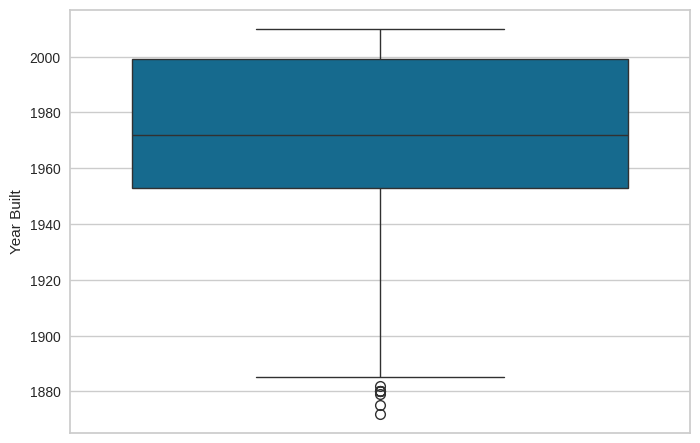

In [ ]:
sns.boxplot(y=train_data['Year Built'])

## Encode categorical features

In [ ]:
# View categorical features
categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()
categorical_features

['MS Zoning',
 'Street',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Exter Qual',
 'Exter Cond',
 'Foundation',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating',
 'Heating QC',
 'Central Air',
 'Electrical',
 'Kitchen Qual',
 'Functional',
 'Garage Type',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Paved Drive',
 'Sale Type',
 'Sale Condition']

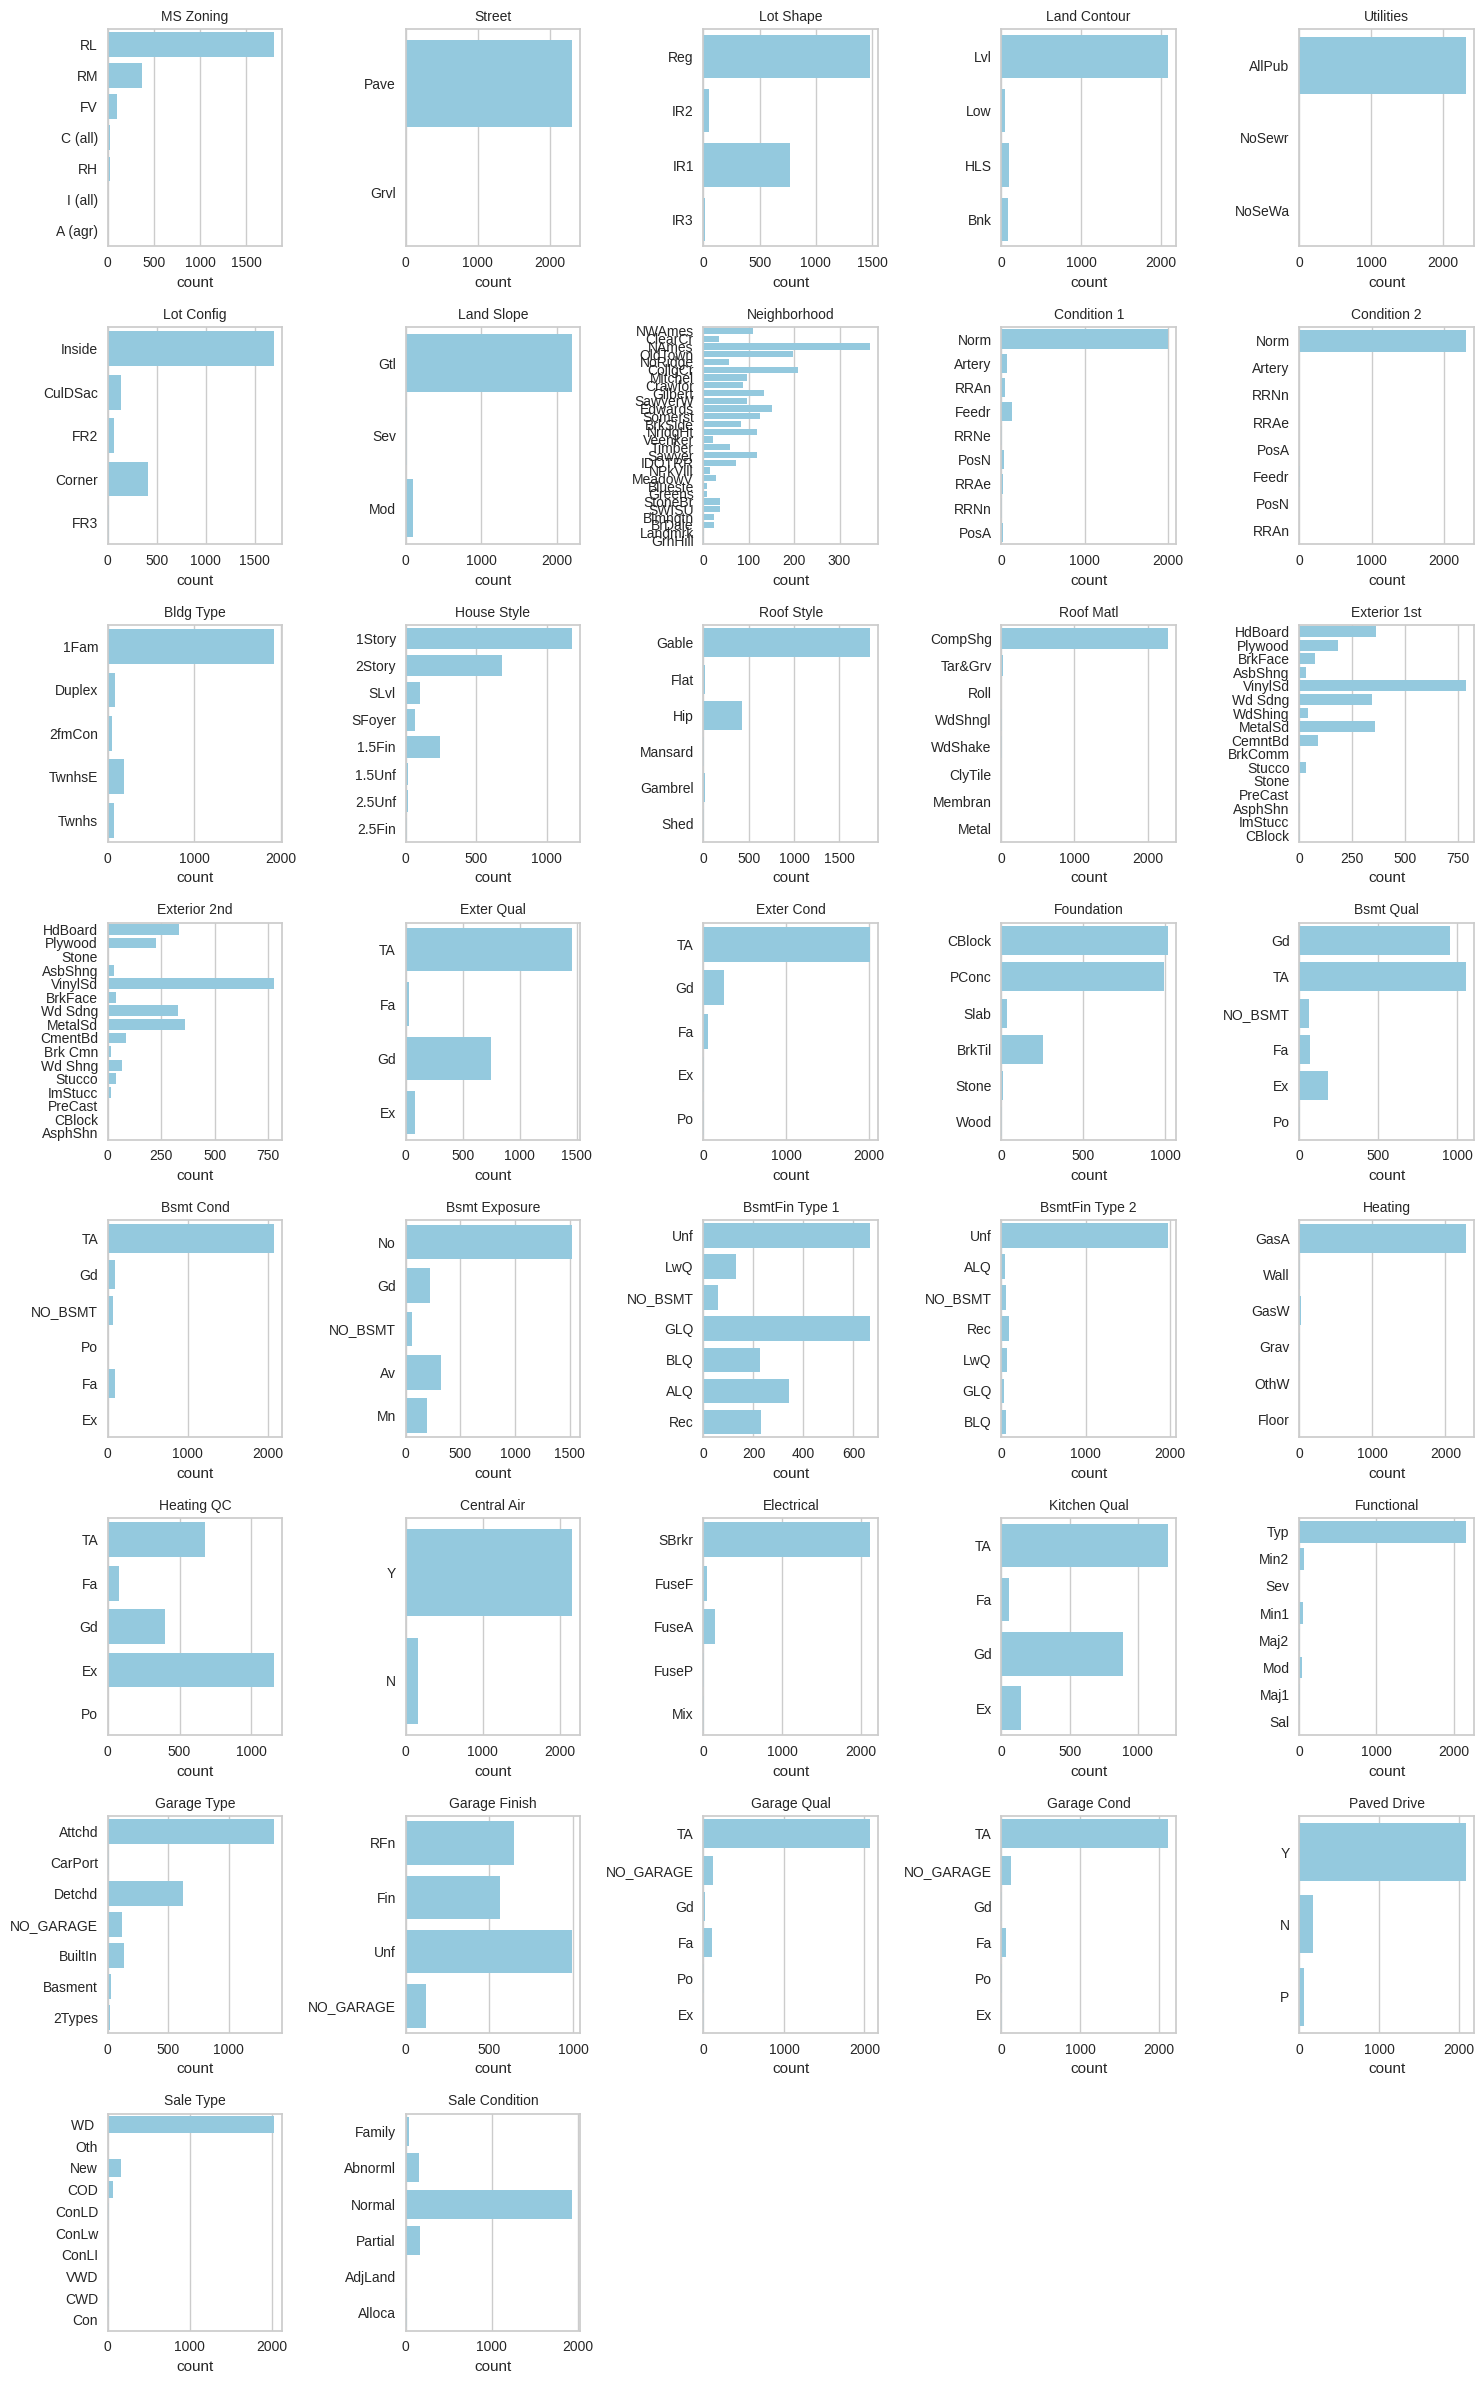

In [ ]:
# Make count plot for each categorical feature

# Determine grid size
import math
n_cols = 5
n_rows = math.ceil(len(categorical_features) / n_cols)

# Entire plot
plt.figure(figsize=(n_cols*3, n_rows*3))

# Subplots
for i, col in enumerate(categorical_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(y=train_data[col], color='skyblue')
    plt.title(col, fontsize=10)
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
# Declare lists
# List for ordinal features only
ordinal_features = [
    'Exter Qual',
    'Exter Cond',
    'Bsmt Qual',
    'Bsmt Cond',
    'Heating QC',
    'Kitchen Qual',
    'Garage Qual',
    'Garage Cond'
]

# list for mapping
quality_mapping = {
    'Ex':         5,  # Excellent
    'Gd':         4,  # Good
    'TA':         3,  # Typical/Average
    'Fa':         2,  # Fair
    'Po':         1,  # Poor
    'NO_GARAGE':  0,  # No garage
    'NO_BSMT':    0,  # No basement
}

In [ ]:
# Apply mapping to train_data
for col in ordinal_features:
    train_data[col + ' -enc'] = train_data[col].map(quality_mapping)

# Apply mapping to test_data
for col in ordinal_features:
    test_data[col + ' -enc'] = test_data[col].map(quality_mapping)

In [ ]:
# See first 5 rows of data
train_data.head()

MS SubClass MS Zoning  Lot Frontage  Lot Area Street Lot Shape  \
381            20        RL          80.0     10400   Pave       Reg   
834            60        RL           0.0     28698   Pave       IR2   
1898           90        RL          70.0      9842   Pave       Reg   
678            90        RL          60.0      7200   Pave       Reg   
700           190        RM          63.0      7627   Pave       Reg   

     Land Contour Utilities Lot Config Land Slope  ... SalePrice  \
381           Lvl    AllPub     Inside        Gtl  ...    152000   
834           Low    AllPub    CulDSac        Sev  ...    185000   
1898          Lvl    AllPub        FR2        Gtl  ...    101800   
678           Lvl    AllPub     Inside        Gtl  ...     90000   
700           Lvl    AllPub     Corner        Gtl  ...     94550   

     LotFrontage_missing Exter Qual -enc Exter Cond -enc Bsmt Qual -enc  \
381                    0               3               3              4   
834                    0               3               3              3   
1898                   0               3               3              0   
678                    0               3               3              0   
700                    0               2               3              2   

      Bsmt Cond -enc  Heating QC -enc  Kitchen Qual -enc  Garage Qual -enc  \
381                3                3                  3                 3   
834                4                3                  3                 3   
1898               0                3                  3                 3   
678                0                2                  3                 3   
700                1                4                  2                 0   

     Garage Cond -enc  
381                 3  
834                 3  
1898                3  
678                 3  
700                 0  

[5 rows x 83 columns]

In [ ]:
# Show shape
train_data.shape

(2317, 83)

In [ ]:
# See first 5 rows of data
test_data.head()

MS SubClass MS Zoning  Lot Frontage  Lot Area Street Lot Shape  \
1357           70        RM           0.0      5100   Pave       Reg   
2374          160        RM          21.0      1890   Pave       Reg   
2829           60        RL          62.0      7162   Pave       Reg   
2126           20        RL          60.0      8070   Pave       Reg   
1544           30        RM          50.0      7000   Pave       Reg   

     Land Contour Utilities Lot Config Land Slope  ... SalePrice  \
1357          Lvl    AllPub     Inside        Gtl  ...    161000   
2374          Lvl    AllPub     Inside        Gtl  ...    116000   
2829          Lvl    AllPub     Inside        Gtl  ...    196500   
2126          Lvl    AllPub     Inside        Gtl  ...    123600   
1544          Lvl    AllPub     Inside        Gtl  ...    126000   

     LotFrontage_missing Exter Qual -enc Exter Cond -enc Bsmt Qual -enc  \
1357                   0               3               4              3   
2374                   0               3               3              3   
2829                   0               4               3              4   
2126                   0               3               3              4   
1544                   0               3               4              3   

      Bsmt Cond -enc  Heating QC -enc  Kitchen Qual -enc  Garage Qual -enc  \
1357               3                2                  4                 3   
2374               3                5                  3                 3   
2829               3                5                  4                 3   
2126               3                5                  3                 0   
1544               3                3                  3                 3   

     Garage Cond -enc  
1357                3  
2374                3  
2829                3  
2126                0  
1544                3  

[5 rows x 83 columns]

In [ ]:
# Show shape
test_data.shape

(579, 83)

In [ ]:
# Drop categorical feature origional columns
train_data.drop(columns=ordinal_features, inplace=True)
test_data.drop(columns=ordinal_features, inplace=True)

In [ ]:
# Show shape
train_data.shape

(2317, 75)

In [ ]:
# Show shape
test_data.shape

(579, 75)

In [ ]:
# One hot encoding for the other features

# Save the original neighborhood column for later use becasue this encoding deletes the origional column
train_data['Neighborhood-orig'] = train_data['Neighborhood']
test_data['Neighborhood-orig'] = test_data['Neighborhood']

# Save origional columns
original_cols = train_data.columns.tolist()

# Remove ordinal features (already encoded)
nominal_features = [col for col in categorical_features if col not in ordinal_features]

# Apply one-hot encoding to train_data
train_data = pd.get_dummies(train_data, columns=nominal_features, drop_first=False)

# Apply one-hot encoding to test_data
# To make sure train and test have the same columns, we align them after encoding
test_data = pd.get_dummies(test_data, columns=nominal_features, drop_first=False)

# Align train and test columns (add missing columns as 0)
train_data, test_data = train_data.align(test_data, join='outer', axis=1, fill_value=0)

# identify new columns
one_hot_cols = [col for col in train_data.columns if col not in original_cols]

# Convert all object/bool dummies to int
for col in one_hot_cols:
    train_data[col] = train_data[col].astype(int)
    test_data[col] = test_data[col].astype(int)


In [ ]:
# Print nominal features
nominal_features

['MS Zoning',
 'Street',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating',
 'Central Air',
 'Electrical',
 'Functional',
 'Garage Type',
 'Garage Finish',
 'Paved Drive',
 'Sale Type',
 'Sale Condition']

In [ ]:
# Show first 5 rows
train_data.head()

1st Flr SF  2nd Flr SF  3Ssn Porch  Bedroom AbvGr  Bldg Type_1Fam  \
381         1370           0           0              3               1   
834         1160         966           0              3               1   
1898        1224           0           0              2               0   
678         1040           0           0              2               0   
700         1101         600           0              4               0   

      Bldg Type_2fmCon  Bldg Type_Duplex  Bldg Type_Twnhs  Bldg Type_TwnhsE  \
381                  0                 0                0                 0   
834                  0                 0                0                 0   
1898                 0                 1                0                 0   
678                  0                 1                0                 0   
700                  1                 0                0                 0   

      Bsmt Cond -enc  ...  Street_Pave  TotRms AbvGrd  Total Bsmt SF  \
381                3  ...            1              6         1090.0   
834                4  ...            1              7         1013.0   
1898               0  ...            1              6            0.0   
678                0  ...            1              6            0.0   
700                1  ...            1              8          600.0   

      Utilities_AllPub  Utilities_NoSeWa  Utilities_NoSewr  Wood Deck SF  \
381                  1                 0                 0             0   
834                  1                 0                 0           486   
1898                 1                 0                 0             0   
678                  1                 0                 0             0   
700                  1                 0                 0             0   

      Year Built  Year Remod/Add  Yr Sold  
381         1976            1976     2009  
834         1967            1967     2009  
1898        1962            1962     2007  
678         1949            1950     2009  
700         1920            1950     2009  

[5 rows x 256 columns]

In [ ]:
# Show shape
train_data.shape

(2317, 256)

In [ ]:
# Show first 5 rows
test_data.head()

1st Flr SF  2nd Flr SF  3Ssn Porch  Bedroom AbvGr  Bldg Type_1Fam  \
1357         833         833           0              3               1   
2374         494         536           0              3               0   
2829         806         918           0              3               1   
2126         990           0           0              3               1   
1544         919           0           0              2               1   

      Bldg Type_2fmCon  Bldg Type_Duplex  Bldg Type_Twnhs  Bldg Type_TwnhsE  \
1357                 0                 0                0                 0   
2374                 0                 0                1                 0   
2829                 0                 0                0                 0   
2126                 0                 0                0                 0   
1544                 0                 0                0                 0   

      Bsmt Cond -enc  ...  Street_Pave  TotRms AbvGrd  Total Bsmt SF  \
1357               3  ...            1              7          588.0   
2374               3  ...            1              6          494.0   
2829               3  ...            1              8          796.0   
2126               3  ...            1              5          990.0   
1544               3  ...            1              5          894.0   

      Utilities_AllPub  Utilities_NoSeWa  Utilities_NoSewr  Wood Deck SF  \
1357                 1                 0                 0           192   
2374                 1                 0                 0             0   
2829                 1                 0                 0           168   
2126                 1                 0                 0             0   
1544                 1                 0                 0             0   

      Year Built  Year Remod/Add  Yr Sold  
1357        1925            1996     2008  
2374        1972            1972     2006  
2829        2003            2004     2006  
2126        1994            1995     2007  
1544        1926            1998     2008  

[5 rows x 256 columns]

In [ ]:
# Show shape
test_data.shape

(579, 256)

## Scale features

In [ ]:
# Select numeric columns
numeric_cols = train_data.select_dtypes(include='number').columns.tolist()

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler only on training data
scaler.fit(train_data[numeric_cols])

# Transform train and test data separately
scaled_train_array = scaler.transform(train_data[numeric_cols])
scaled_test_array = scaler.transform(test_data[numeric_cols])

# Replace only numeric columns in original DataFrames
scaled_train_data = train_data.copy()
scaled_train_data[numeric_cols] = scaled_train_array

scaled_test_data = test_data.copy()
scaled_test_data[numeric_cols] = scaled_test_array

# ⬇ Modeling ⬇

# Classification

In [ ]:
# Define input features
X_cols = ['Lot Area', 'SalePrice', 'Lot Frontage', 'Year Built']

In [ ]:
# Neighborhood categories
rural_neighborhoods = ['MeadowV', 'Greens', 'GrnHill', 'Landmrk']
urban_neighborhoods = ['IDOTRR', 'SWISU', 'OldTown', 'BrkSide']
suburban_neighborhoods = [
    'NAmes', 'CollgCr', 'Somerst', 'NridgHt', 'Gilbert', 'NWAmes', 'SawyerW',
    'Mitchel', 'NoRidge', 'StoneBr', 'ClearCr', 'Blmngtn', 'NPkVill', 'Timber',
    'Edwards', 'Sawyer', 'Crawfor'
]

In [ ]:
# Make new feature for neighborhood category
def categorize_neighborhood(name):
    if name in rural_neighborhoods:
        return "Rural Ames"
    elif name in urban_neighborhoods:
        return "Urban Ames"
    else:
        return "Suburban Ames"

train_data["Neighborhood-Groups"] = train_data["Neighborhood-orig"].apply(categorize_neighborhood)
test_data["Neighborhood-Groups"] = test_data["Neighborhood-orig"].apply(categorize_neighborhood)

In [ ]:
# Set X and y, train and test
X_train = scaled_train_data[X_cols]
y_train = train_data[['Neighborhood-Groups']]

X_test = scaled_test_data[X_cols]
y_test = test_data[['Neighborhood-Groups']]

## Model 1 KNN

In [ ]:
# Define parameters
knn_parameters = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'metric': ['euclidean', 'manhattan', 'cosine', 'minkowski']
}

# Create test model
knn_test_model = KNeighborsClassifier()

# Set up grid search
search_results = GridSearchCV(
    knn_test_model,
    knn_parameters,
    scoring='accuracy',
    cv=cv_classification)

# Fit grid search
search_results.fit(X_train, np.ravel(y_train))

# Save results
save_gs_results(search_results)

Model                         Scoring metric                                              Mean ± Std                         Chosen Hyperparameters                            
KNeighborsClassifier          accuracy                                                    0.9322 ± 0.0049                    {'metric': 'manhattan', 'n_neighbors': 5}         


In [ ]:
# Initialize a model
knn_model = KNeighborsClassifier(n_neighbors=5, metric='manhattan')

# Fit the model
knn_model.fit(X_train, np.ravel(y_train))

# Calculate the predictions for each instance in X
knn_pred = knn_model.predict(X_test)

In [ ]:
# Show report of metrics
print("=== Classification Report: KNN Model ===")
labels = np.unique(y_test)
print(classification_report(np.ravel(y_test), np.ravel(knn_pred), target_names=labels))

=== Classification Report: KNN Model ===
               precision    recall  f1-score   support

   Rural Ames       0.83      0.50      0.62        10
Suburban Ames       0.96      0.98      0.97       474
   Urban Ames       0.90      0.84      0.87        95

     accuracy                           0.95       579
    macro avg       0.90      0.77      0.82       579
 weighted avg       0.95      0.95      0.95       579



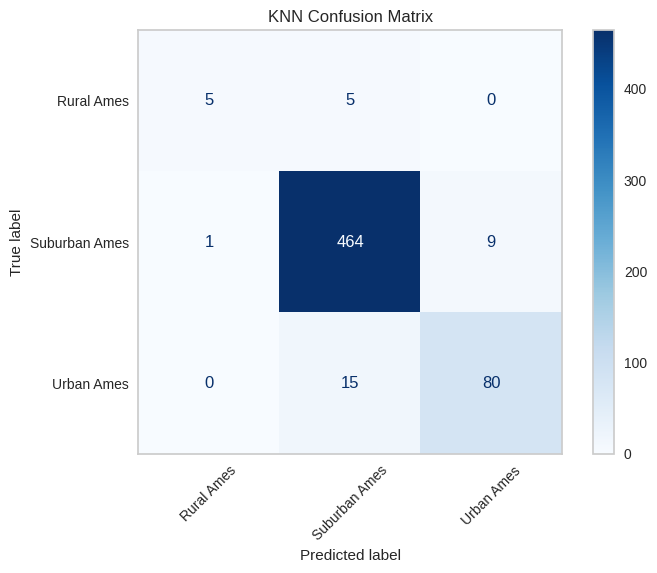

In [ ]:
# Create confusion matrix
cm = confusion_matrix(np.ravel(y_test), knn_pred)
labels = np.unique(y_test)
display = ConfusionMatrixDisplay(cm, display_labels=labels)
display.plot(cmap='Blues', xticks_rotation=45)
plt.title('KNN Confusion Matrix')
plt.grid(False)
plt.show()

## Model 2 LDA

In [ ]:
# Define parameters
lda_parameters = {
  'solver': ['svd', 'lsqr', 'eigen'],
  'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]
}

# Create test model
lda_test_model = LinearDiscriminantAnalysis()

# Set up grid search
search_results = GridSearchCV(
    lda_test_model,
    lda_parameters,
    scoring='accuracy',
    cv=cv_classification)

# Fit grid search
search_results.fit(X_train, np.ravel(y_train))

# Save results
save_gs_results(search_results)

Model                         Scoring metric                                              Mean ± Std                         Chosen Hyperparameters                            
LinearDiscriminantAnalysis    accuracy                                                    0.9102 ± 0.0089                    {'shrinkage': 0.9, 'solver': 'lsqr'}              


In [ ]:
# Initialize a linear discriminant model
LDA_model = LinearDiscriminantAnalysis(n_components=2, store_covariance=True, shrinkage=0.9, solver='lsqr')

# Fit the model
LDA_model.fit(X_train, np.ravel(y_train))

# Calculate predictions
LDA_pred = LDA_model.predict(X_test)

In [ ]:
# Show report of metrics
print("=== Classification Report: LDA Model ===")
labels = np.unique(y_test)
print(classification_report(np.ravel(y_test), np.ravel(LDA_pred), target_names=labels))

=== Classification Report: LDA Model ===
               precision    recall  f1-score   support

   Rural Ames       0.00      0.00      0.00        10
Suburban Ames       0.92      0.98      0.95       474
   Urban Ames       0.86      0.71      0.77        95

     accuracy                           0.92       579
    macro avg       0.59      0.56      0.57       579
 weighted avg       0.90      0.92      0.90       579



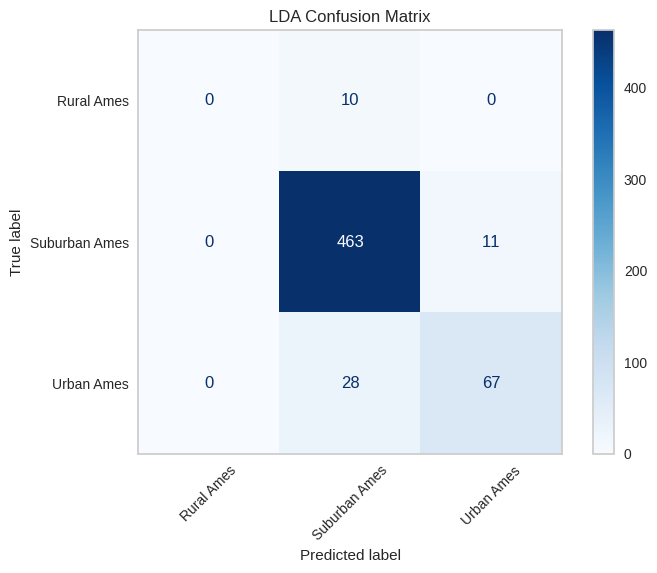

In [ ]:
# Create confusion matrix
cm = confusion_matrix(np.ravel(y_test), LDA_pred)
labels = np.unique(y_test)
display = ConfusionMatrixDisplay(cm, display_labels=labels)
display.plot(cmap='Blues', xticks_rotation=45)
plt.title('LDA Confusion Matrix')
plt.grid(False)
plt.show()

# Regression

In [ ]:
# Define input and output features
X_train = scaled_train_data.select_dtypes(include=[np.number]).drop(columns=['SalePrice'])
y_train = train_data['SalePrice'].values

X_test = scaled_test_data.select_dtypes(include=[np.number]).drop(columns=['SalePrice'])
y_test = test_data['SalePrice'].values

## Model 1 LASSO

In [ ]:
# Define parameters
lasso_parameters = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1_000, 10_000, 100_000]
}

# Create test model
lasso_test_model = Lasso(random_state=RANDOM_STATE)

# Set up grid search
search_results = GridSearchCV(
    lasso_test_model,
    lasso_parameters,
    scoring='neg_mean_squared_error',
    cv=cv_regression)

# Fit grid search
search_results.fit(X_train, y_train)

# Save results
save_gs_results(search_results)

Model                         Scoring metric                                              Mean ± Std                         Chosen Hyperparameters                            
Lasso                         neg_mean_squared_error                                      -844313203.2492 ± 286898504.6398   {'alpha': 1000}                                   


In [ ]:
# Create the LassoCV model
lasso_model = Lasso(alpha=1_000, random_state=RANDOM_STATE)

# Fit the model
lasso_model.fit(X_train, y_train)

# Get predictions
lasso_pred = lasso_model.predict(X_test)

In [ ]:
# Calculate MSE
mse = mean_squared_error(y_test, lasso_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

# Print RMSE
print(f"RMSE: {rmse:.2f}")

# Calculate MAE
mae = mean_absolute_error(y_test, lasso_pred)

# Print MAE
print("MAE:", mae)

# Print R2
print('R²:', lasso_model.score(X_test, y_test))

RMSE: 30627.61
MAE: 17847.792992102502
R²: 0.8833757268551032


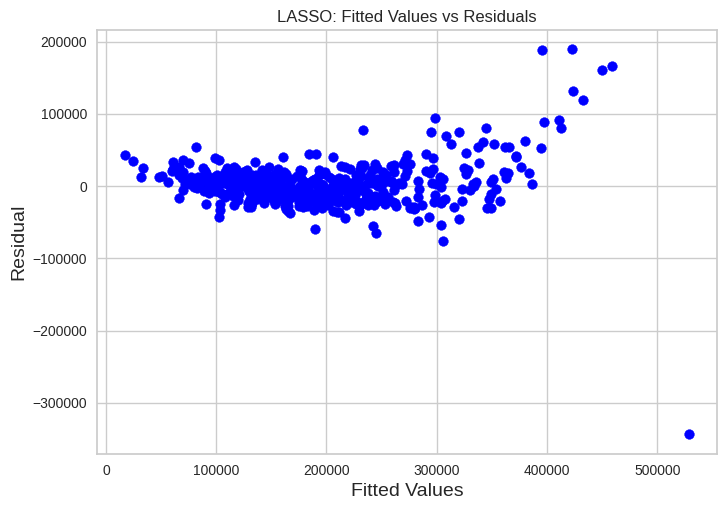

In [ ]:
# Residuals plot for test data

# Find predicted values
yPredicted = lasso_model.predict(X_test)

# Find residuals
residuals = y_test.flatten() - yPredicted.flatten()

# Plot
plt.scatter(yPredicted, residuals, color='blue')
plt.xlabel('Fitted Values', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title('LASSO: Fitted Values vs Residuals')
plt.show()

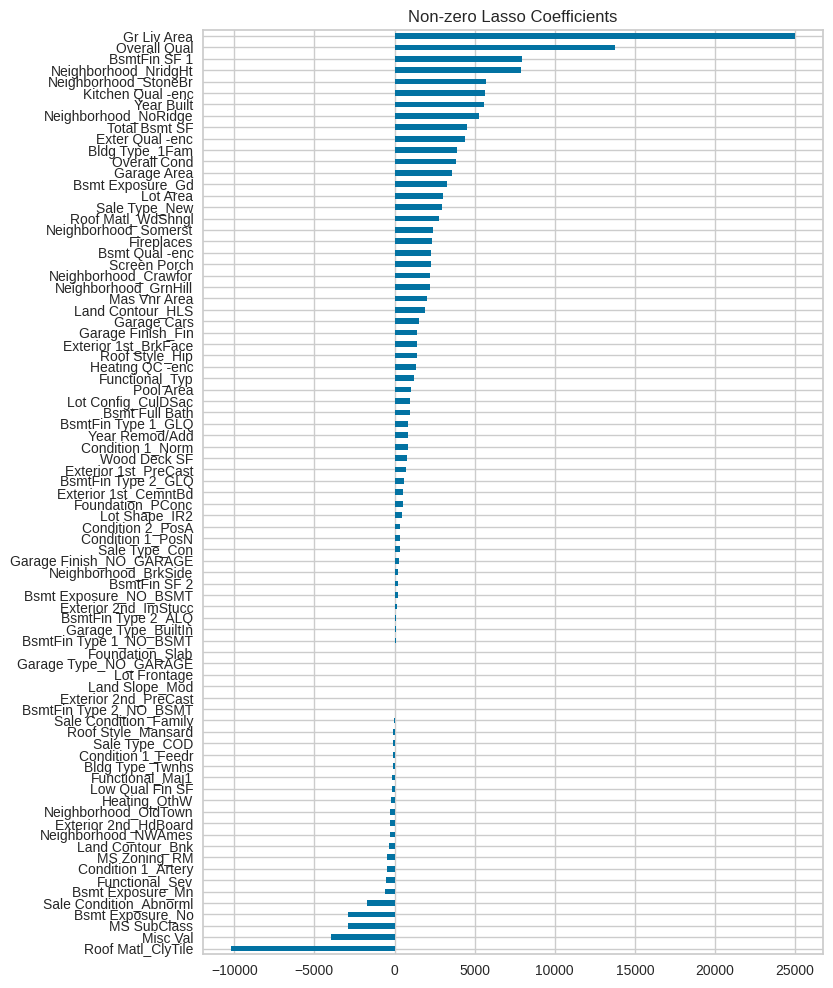

In [ ]:
# Get coefficients as a Series with feature names
coef = pd.Series(lasso_model.coef_, index=X_train.columns)

# Filter only non-zero coefficients
used_features = coef[coef != 0].sort_values()

# Plot coefficients used
used_features.plot(kind='barh', figsize=(8,12))
plt.title("Non-zero Lasso Coefficients")
plt.show()

In [ ]:
# Print nmumber of features used
print("Number of features used:", len(used_features))

Number of features used: 81


## Model 2 Elastic Net

In [ ]:
# Define parameters
elastic_net_parameters = {
    'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1_000, 10_000, 100_000]
}

# Create test model
elastic_net_test_model = ElasticNet(random_state=RANDOM_STATE)

# Set up grid search
search_results = GridSearchCV(
    elastic_net_test_model,
    elastic_net_parameters,
    scoring='neg_mean_squared_error',
    cv=cv_regression)

# Fit grid search
search_results.fit(X_train, y_train)

# Save results
save_gs_results(search_results)

Model                         Scoring metric                                              Mean ± Std                         Chosen Hyperparameters                            
ElasticNet                    neg_mean_squared_error                                      -826088723.8971 ± 248510699.2507   {'alpha': 1, 'l1_ratio': 0.7}                     


In [ ]:
# Create ElasticNetCV model
elastic_model = ElasticNet(alpha=1, l1_ratio=0.7, random_state=RANDOM_STATE)

# Fit model
elastic_model.fit(X_train, y_train)

# Get predictions
elastic_pred = lasso_model.predict(X_test)

In [ ]:
# Calculate MSE
mse = mean_squared_error(y_test, elastic_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

# Print RMSE
print(f"RMSE: {rmse:.2f}")

# Calculate MAE
mae = mean_absolute_error(y_test, elastic_pred)

# Print MAE
print("MAE:", mae)

# Print R2
print('R²:', elastic_model.score(X_test, y_test))

RMSE: 30627.61
MAE: 17847.792992102502
R²: 0.8808597492701581


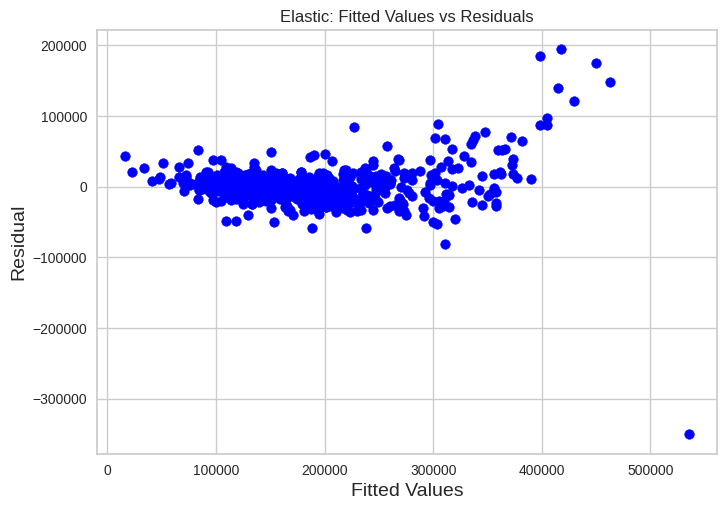

In [ ]:
# Residuals plot for test data

# Find predicted values
yPredicted = elastic_model.predict(X_test)

# Find residuals
residuals = y_test.flatten() - yPredicted.flatten()

# Plot
plt.scatter(yPredicted, residuals, color='blue')
plt.xlabel('Fitted Values', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title('Elastic: Fitted Values vs Residuals')
plt.show()

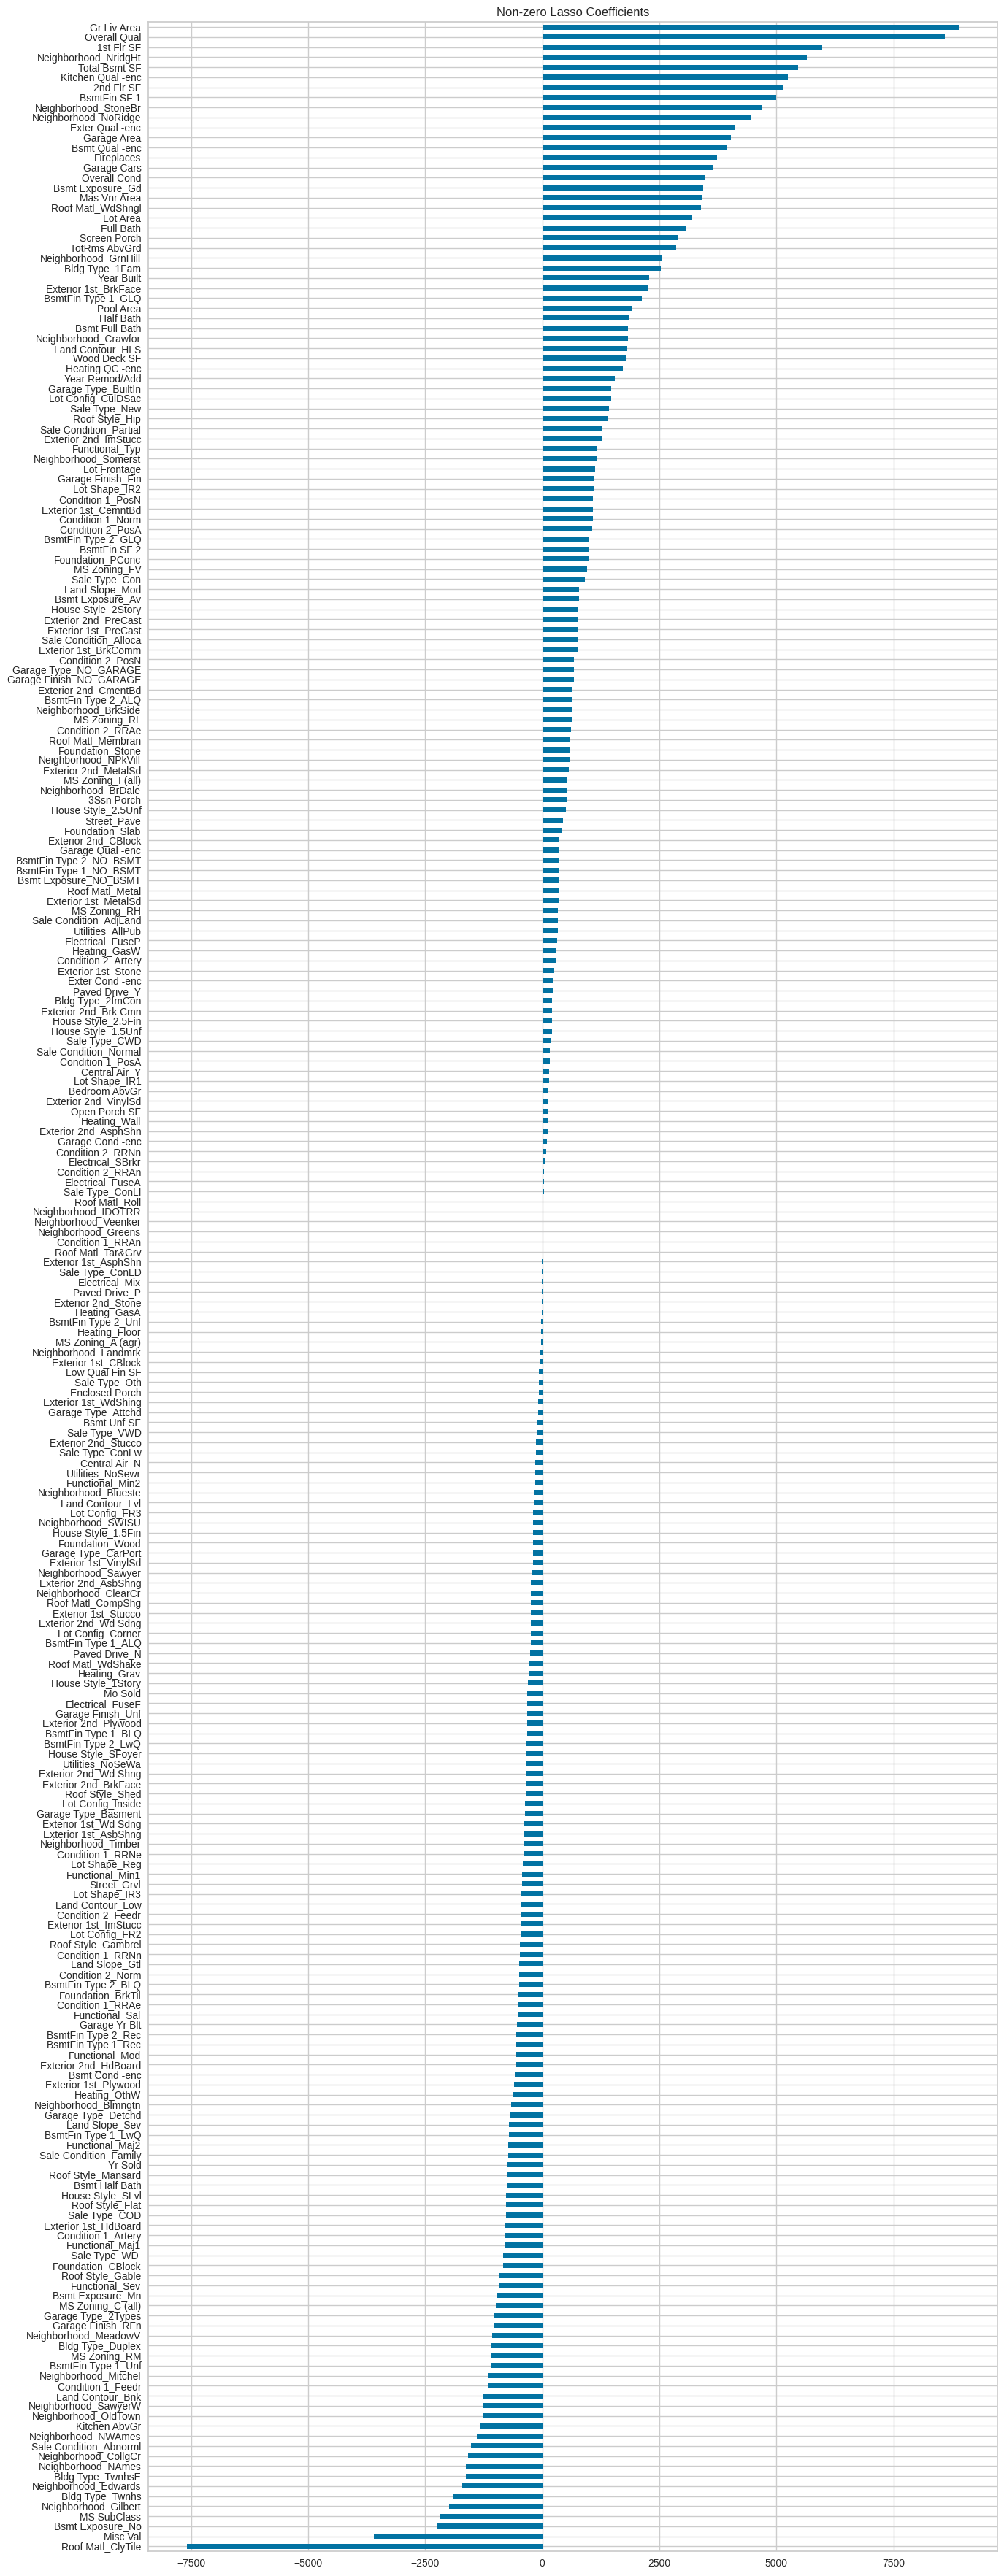

In [ ]:
# Get coefficients as a Series with feature names
coef = pd.Series(elastic_model.coef_, index=X_train.columns)

# Filter only non-zero coefficients
used_features = coef[coef != 0].sort_values()

# Plot coefficients used
used_features.plot(kind='barh', figsize=(15, 45))
plt.title("Non-zero Lasso Coefficients")
plt.show()

In [ ]:
# Print nmumber of features used
print("Number of features used:", len(used_features))

Number of features used: 252


# Clustering

In [ ]:
# Combine test and train data
full_dataset = pd.concat([scaled_train_data, scaled_test_data], axis=0)

In [ ]:
# See SF features
sf_features = [col for col in full_dataset.columns if 'SF' in col.upper()]
sf_features

['1st Flr SF',
 '2nd Flr SF',
 'Bsmt Unf SF',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'House Style_SFoyer',
 'Low Qual Fin SF',
 'Open Porch SF',
 'Total Bsmt SF',
 'Wood Deck SF']

In [ ]:
# combine test and train data
full_dataset['Total Flr SF'] = full_dataset['1st Flr SF'] + full_dataset['2nd Flr SF'] + full_dataset['Total Bsmt SF']

In [ ]:
# Select X features
X_cols = ['SalePrice', 'Total Flr SF']

In [ ]:
# Set X features
X = full_dataset[X_cols]

Text(0.5, 1.0, 'Total Flr SF vs Sale Price')

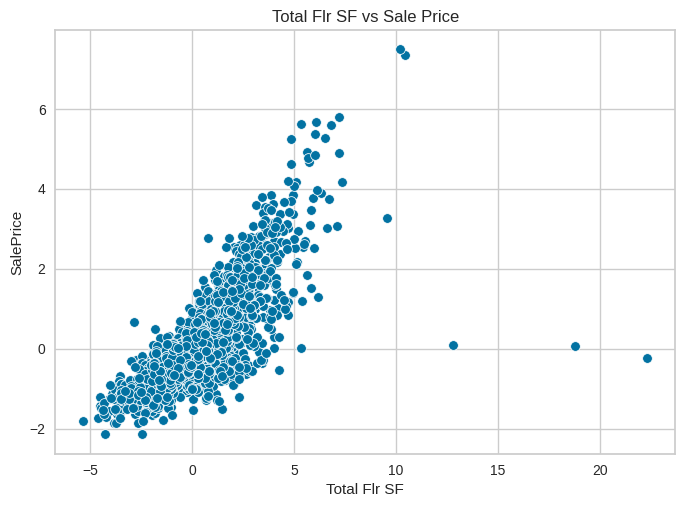

In [ ]:
# Plot X features
p = sns.scatterplot(data=X, x='Total Flr SF', y='SalePrice')
p.set_title('Total Flr SF vs Sale Price')

## Model 1 K-Means

Text(0, 0.5, 'Inertia Value')

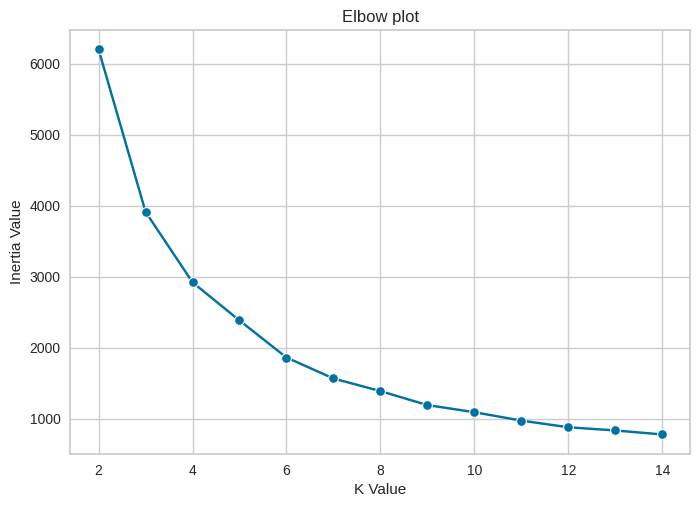

In [ ]:
# ID optimal number of clusters

# Set up lists
models = []
inertia_values = []
silhouette_scores = []

range_list = range(2, 15)

for k in range_list:
  # Create and fit model
  model = KMeans(n_clusters=k, random_state=RANDOM_STATE)
  model.fit(X)

  # Add model and data to lists
  models.append(model)
  inertia_values.append(model.inertia_)
  silhouette_scores.append(silhouette_score(X, model.labels_))

# Elbow plot
p = sns.lineplot(x=range_list, y=inertia_values, marker='o')
p.set_title('Elbow plot')
p.set_xlabel('K Value')
p.set_ylabel('Inertia Value')

(-1.0, 1.0)

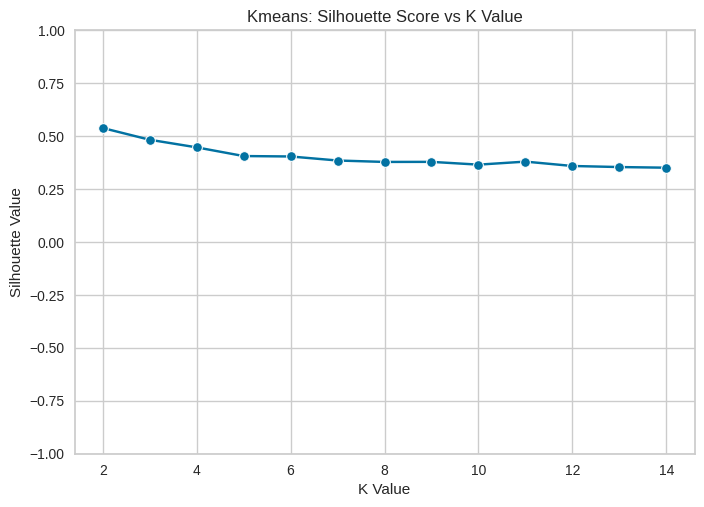

In [ ]:
# Silhouette-vs-k figure
p = sns.lineplot(x=range_list, y=silhouette_scores, marker='o')
p.set_title('Kmeans: Silhouette Score vs K Value')
p.set_xlabel('K Value')
p.set_ylabel('Silhouette Value')
p.set_ylim(-1, 1)

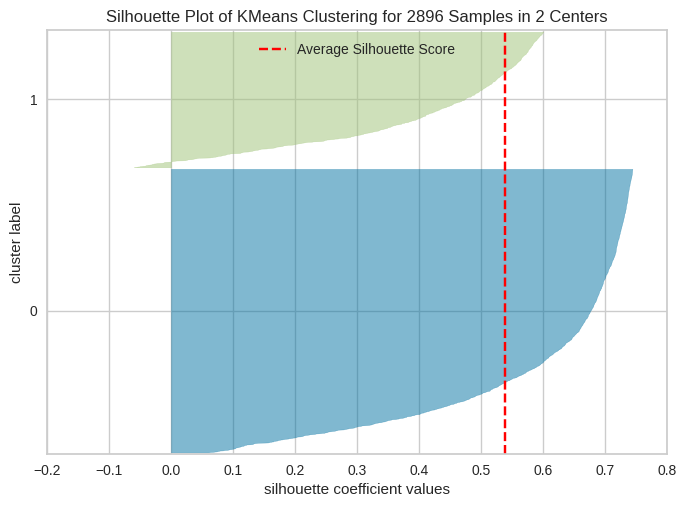

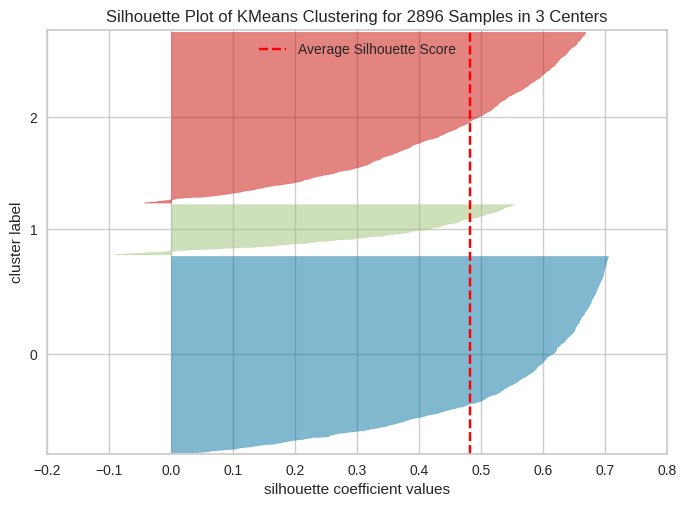

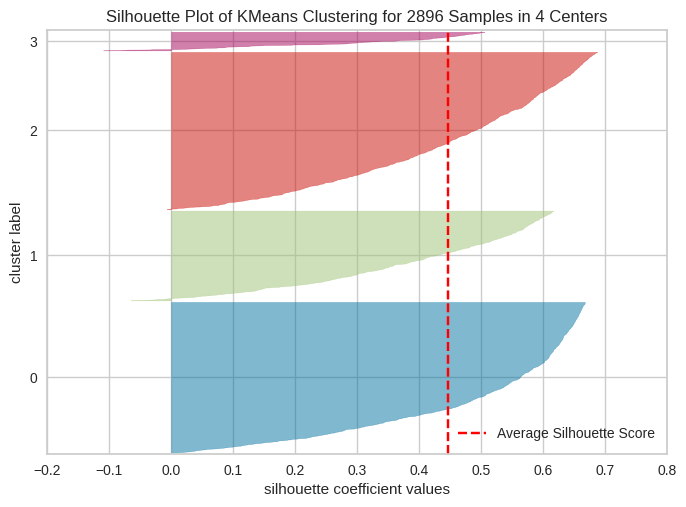

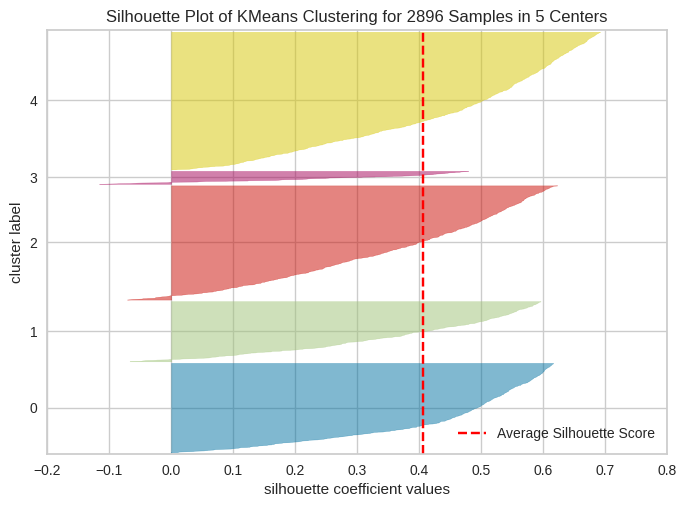

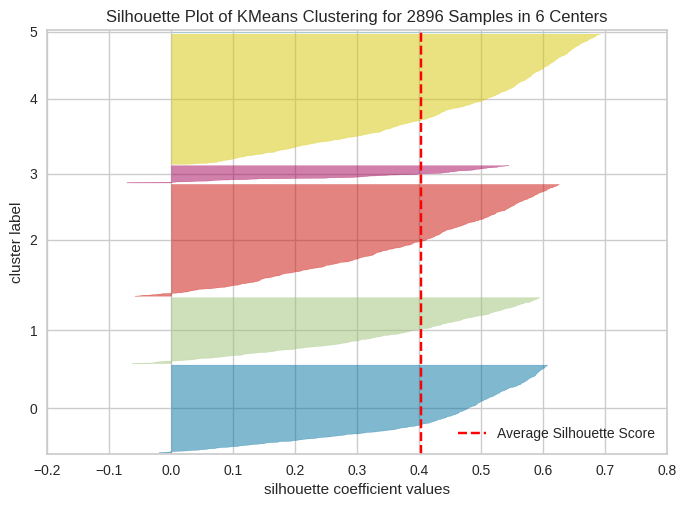

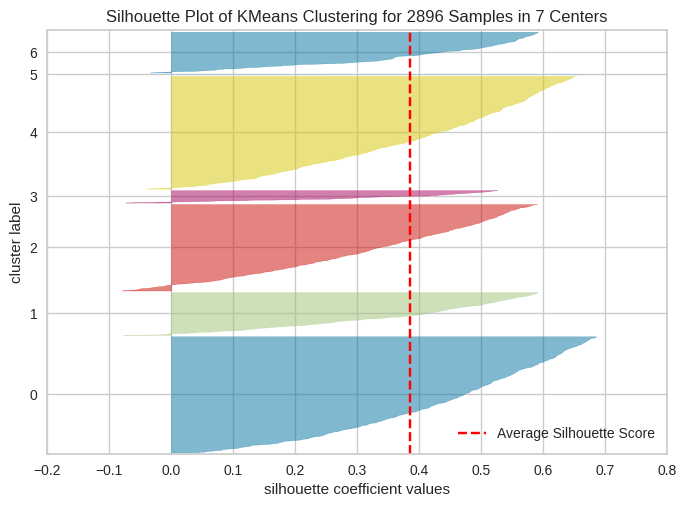

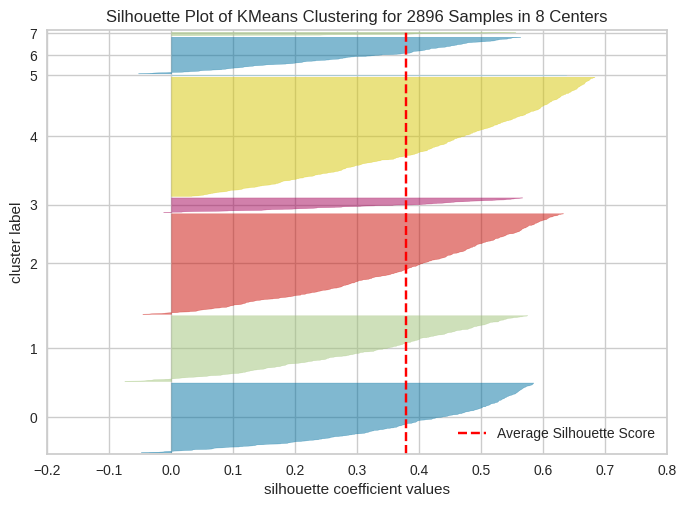

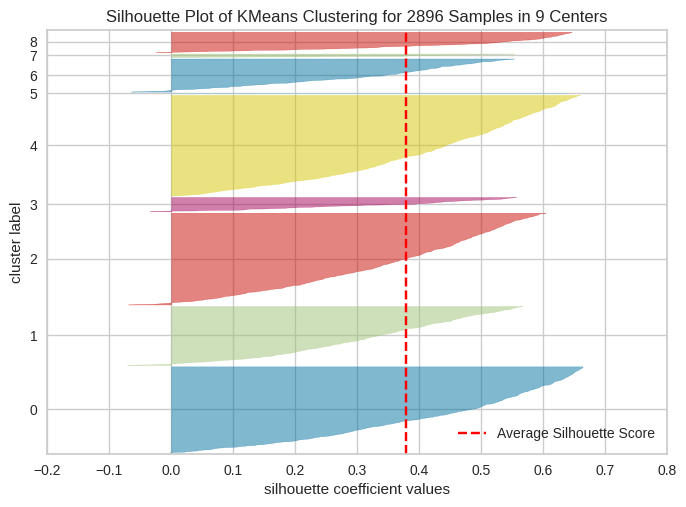

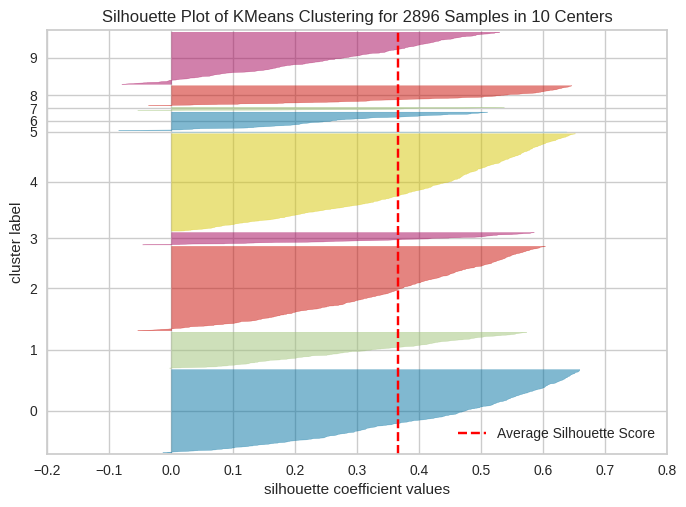

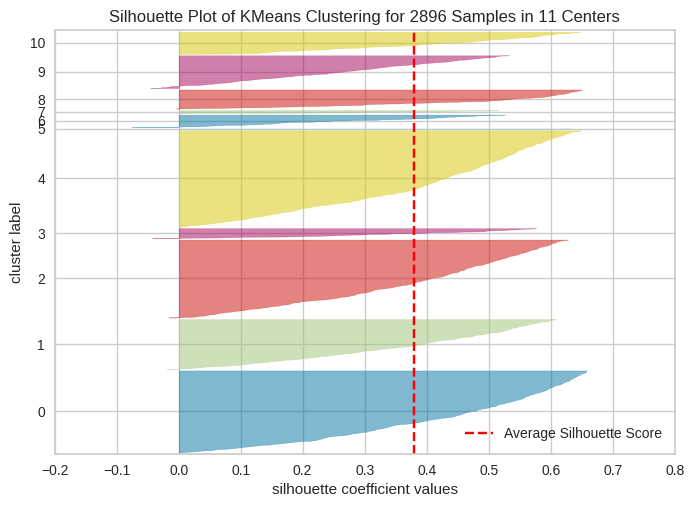

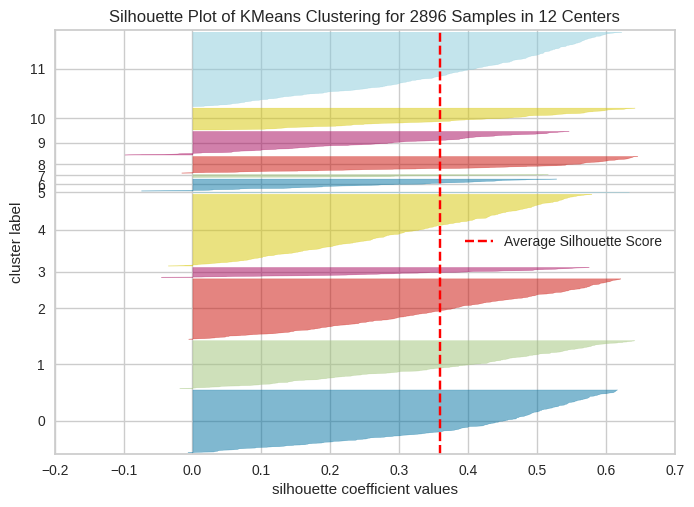

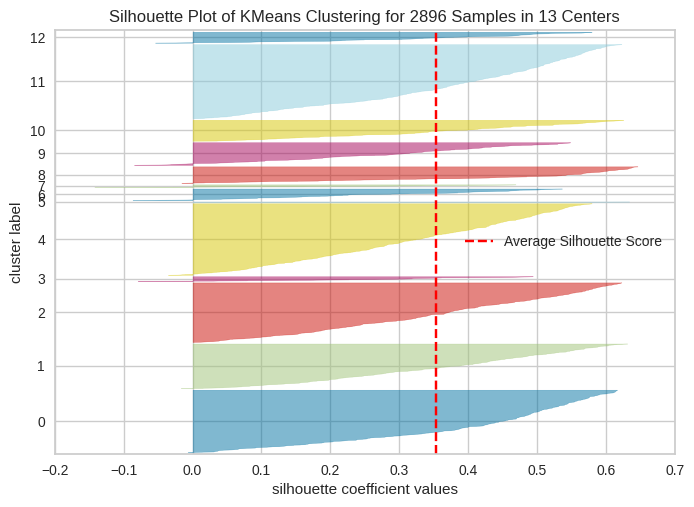

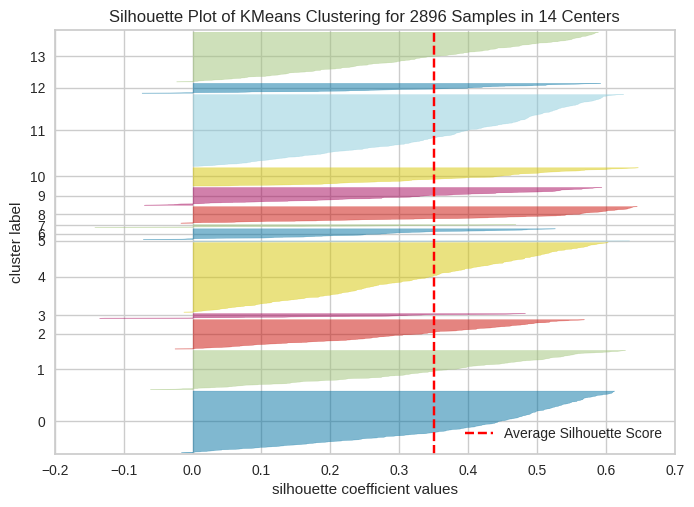

In [ ]:
# Silhouette plots
for model in models:
  visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
  visualizer.fit(X)
  visualizer.show()

In [ ]:
# Define Parameters
kmeans_parameters = {
    'n_clusters': range_list
    }

kmeans_test_model = KMeans(random_state=RANDOM_STATE)

# Define a scoring function (silhouette_score)
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# Set scorer
scorer = make_scorer(silhouette_scorer)

# Grid search
search_results = GridSearchCV(
    kmeans_test_model,
    kmeans_parameters,
    scoring=scorer
    )
search_results.fit(X)

# Save results
save_gs_results(search_results)

Model                         Scoring metric                                              Mean ± Std                         Chosen Hyperparameters                            
KMeans                        make_scorer(silhouette_scorer, response_method='predict')   nan ± nan                          {'n_clusters': 2}                                 


In [ ]:
# Create and fit model
kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE)
kmeans.fit(X)

KMeans(n_clusters=2, random_state=42)

In [ ]:
# Copy data
X_kmeans = X.copy()

# Add labels to dataset
X_kmeans['clusters'] = kmeans.labels_

X_kmeans.head()

SalePrice  Total Flr SF  clusters
381   -0.339280     -0.113899         0
834    0.089049      1.425590         1
1898  -0.990860     -3.003404         0
678   -1.144020     -3.482063         0
700   -1.084962     -0.536255         0

In [ ]:
# Create and print cluster profile table
knn_cluster_profile = X_kmeans.groupby('clusters')[['Total Flr SF', 'SalePrice']].agg(['mean', 'median'])
print(knn_cluster_profile)

         Total Flr SF           SalePrice          
                 mean    median      mean    median
clusters                                           
0           -1.001835 -0.945275 -0.470021 -0.495036
1            2.178984  1.790933  1.071940  0.872372


- Cluster 0: Lower cost smaller size standard homes
- Cluster 1: Higher cost larger homes

In [ ]:
# Set maping for clusters and labels
kmeans_cluster_labels = {
    0: 'Standard',
    1: 'High-end / Luxury'
}

In [ ]:
# Map labels to names
X_kmeans['cluster_labels'] = X_kmeans['clusters'].map(kmeans_cluster_labels)

# Show head
X_kmeans.head()

SalePrice  Total Flr SF  clusters     cluster_labels
381   -0.339280     -0.113899         0           Standard
834    0.089049      1.425590         1  High-end / Luxury
1898  -0.990860     -3.003404         0           Standard
678   -1.144020     -3.482063         0           Standard
700   -1.084962     -0.536255         0           Standard

In [ ]:
# Print model report
print("Inertia:", kmeans.inertia_)

score = silhouette_score(X, X_kmeans['clusters'])
print("Silhouette Score:", score)

print('Number of clusters detected', kmeans.n_clusters)

Inertia: 6202.605996616921
Silhouette Score: 0.5382134865696907
Number of clusters detected 2


In [ ]:
# Print counts for cluster labels
X_kmeans['cluster_labels'].value_counts()

cluster_labels
Standard             1959
High-end / Luxury     937
Name: count, dtype: int64

Text(0.5, 1.0, 'K_Means clusters: Total Flr SF vs Sale Price')

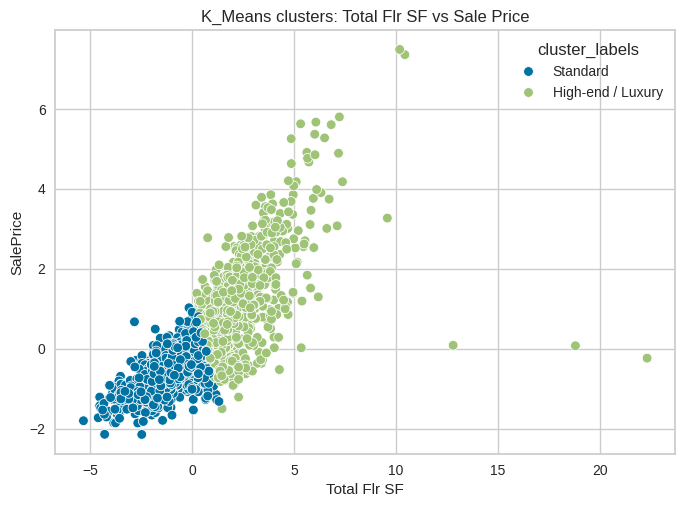

In [ ]:
# Show clusters plot
p = sns.scatterplot(data=X_kmeans, x='Total Flr SF', y='SalePrice', hue='cluster_labels')
p.set_title('K_Means clusters: Total Flr SF vs Sale Price')

## Model 2 Agglomerative

In [ ]:
# Calculate distances
distances = pdist(X)
distances = squareform(distances)

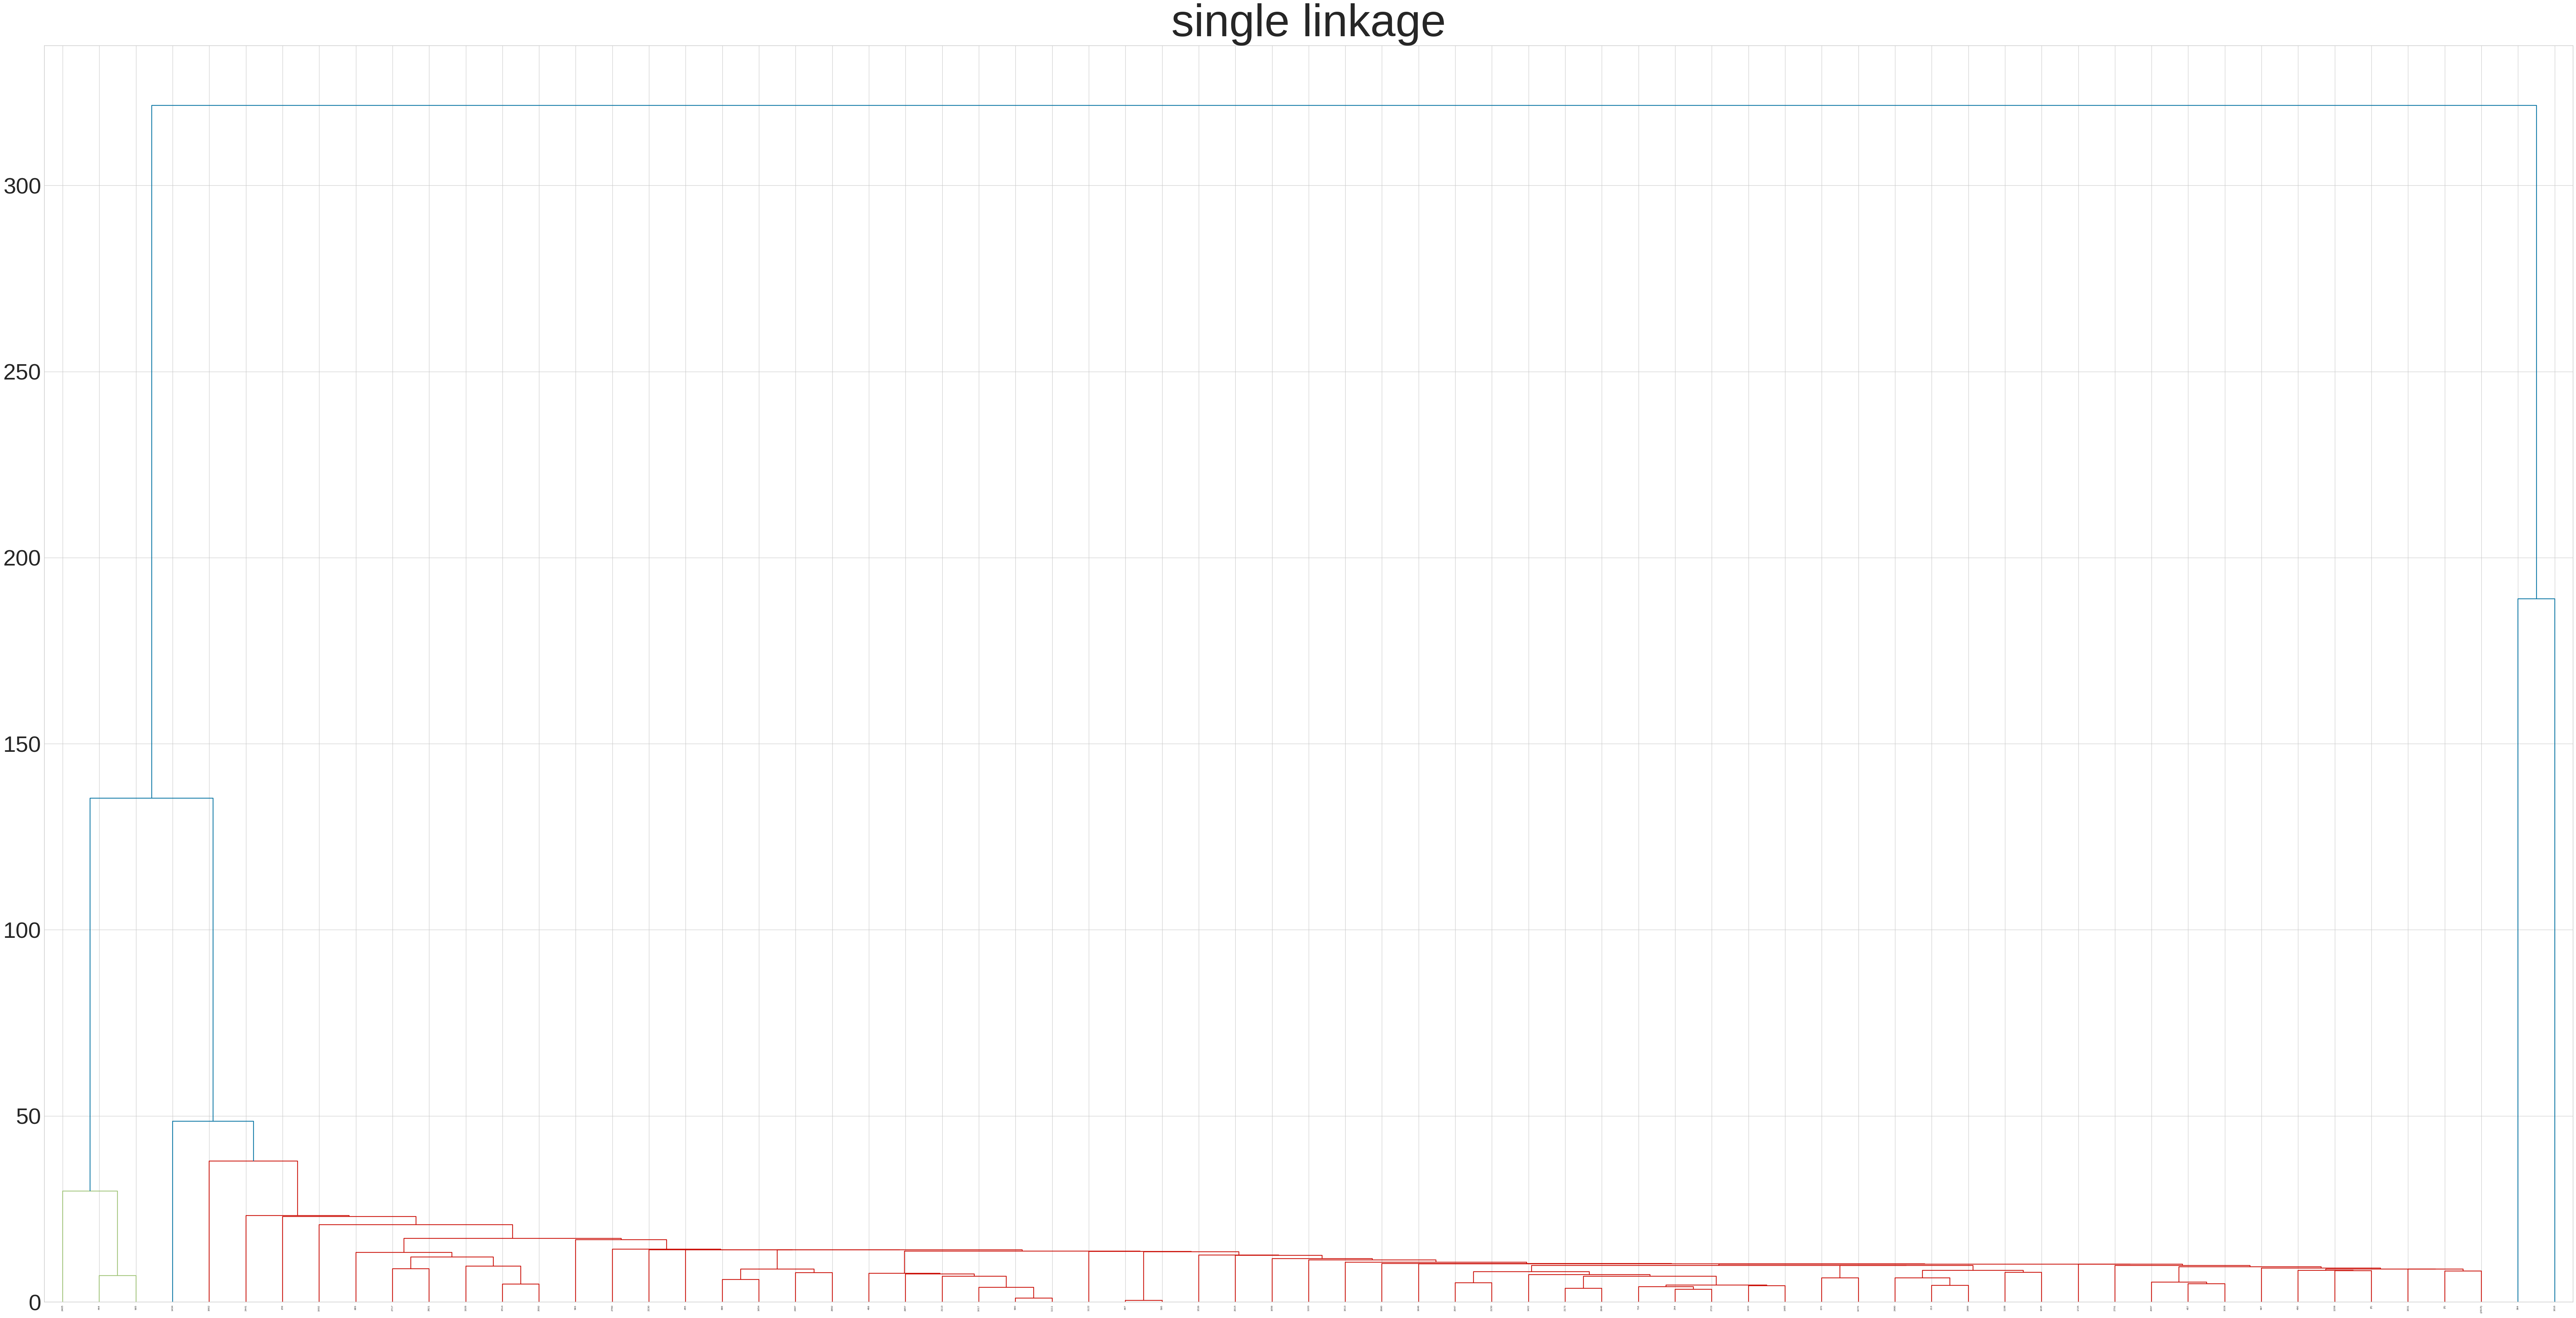

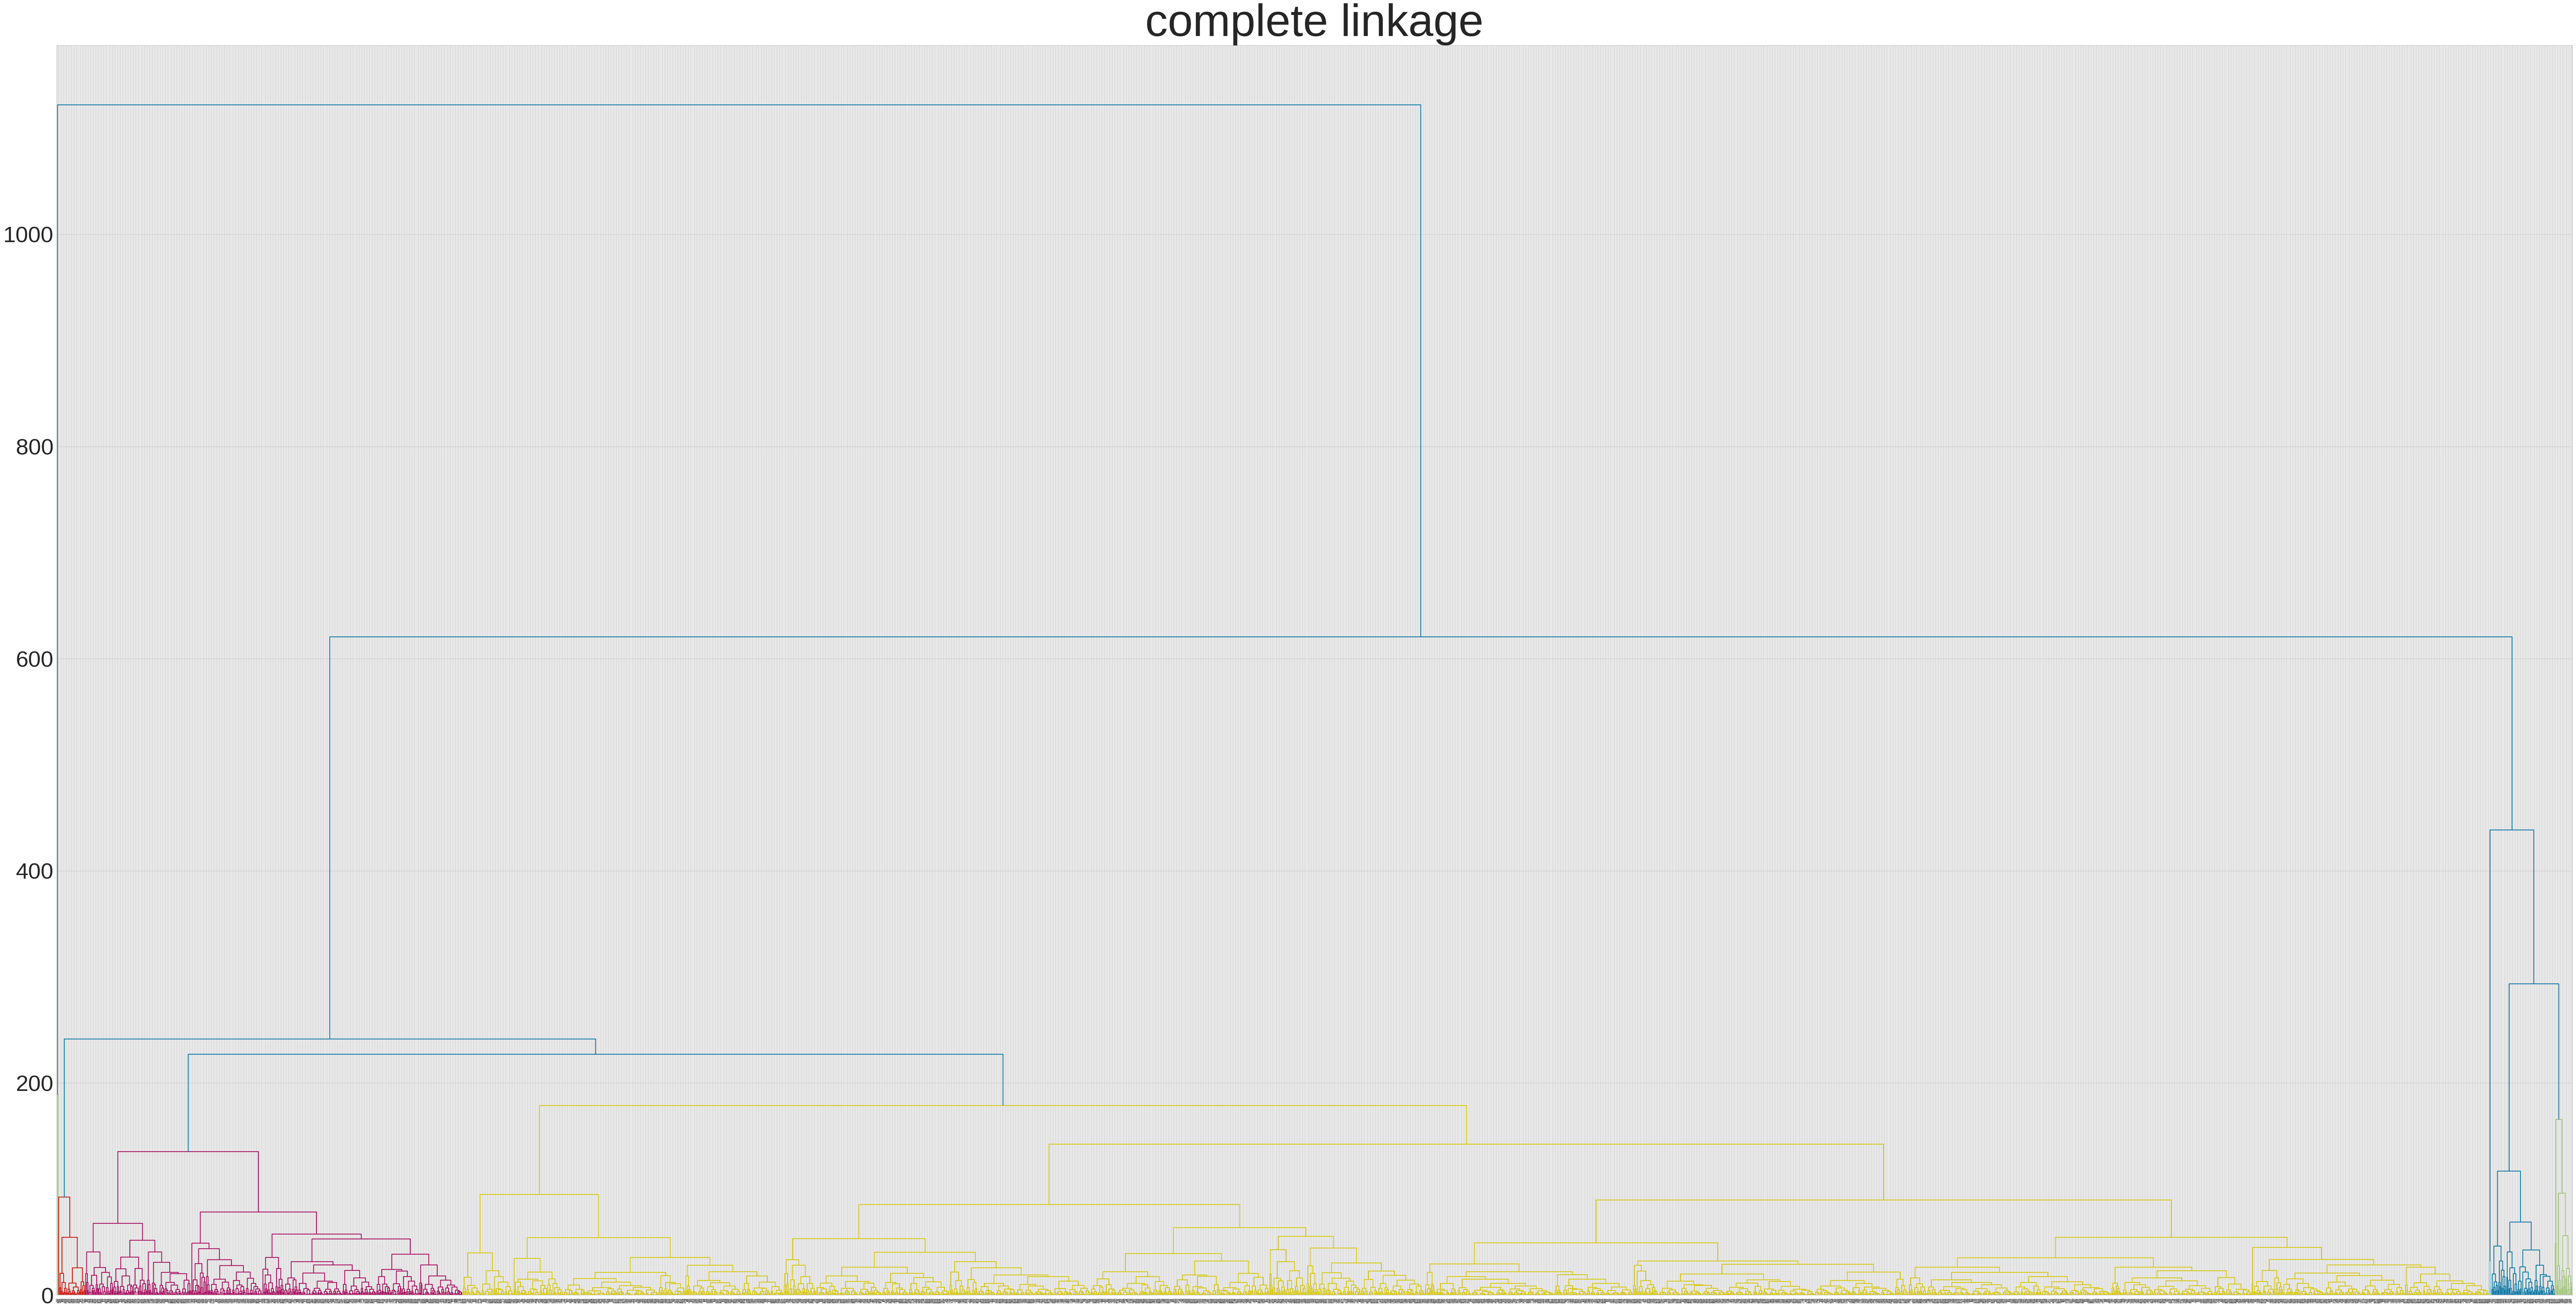

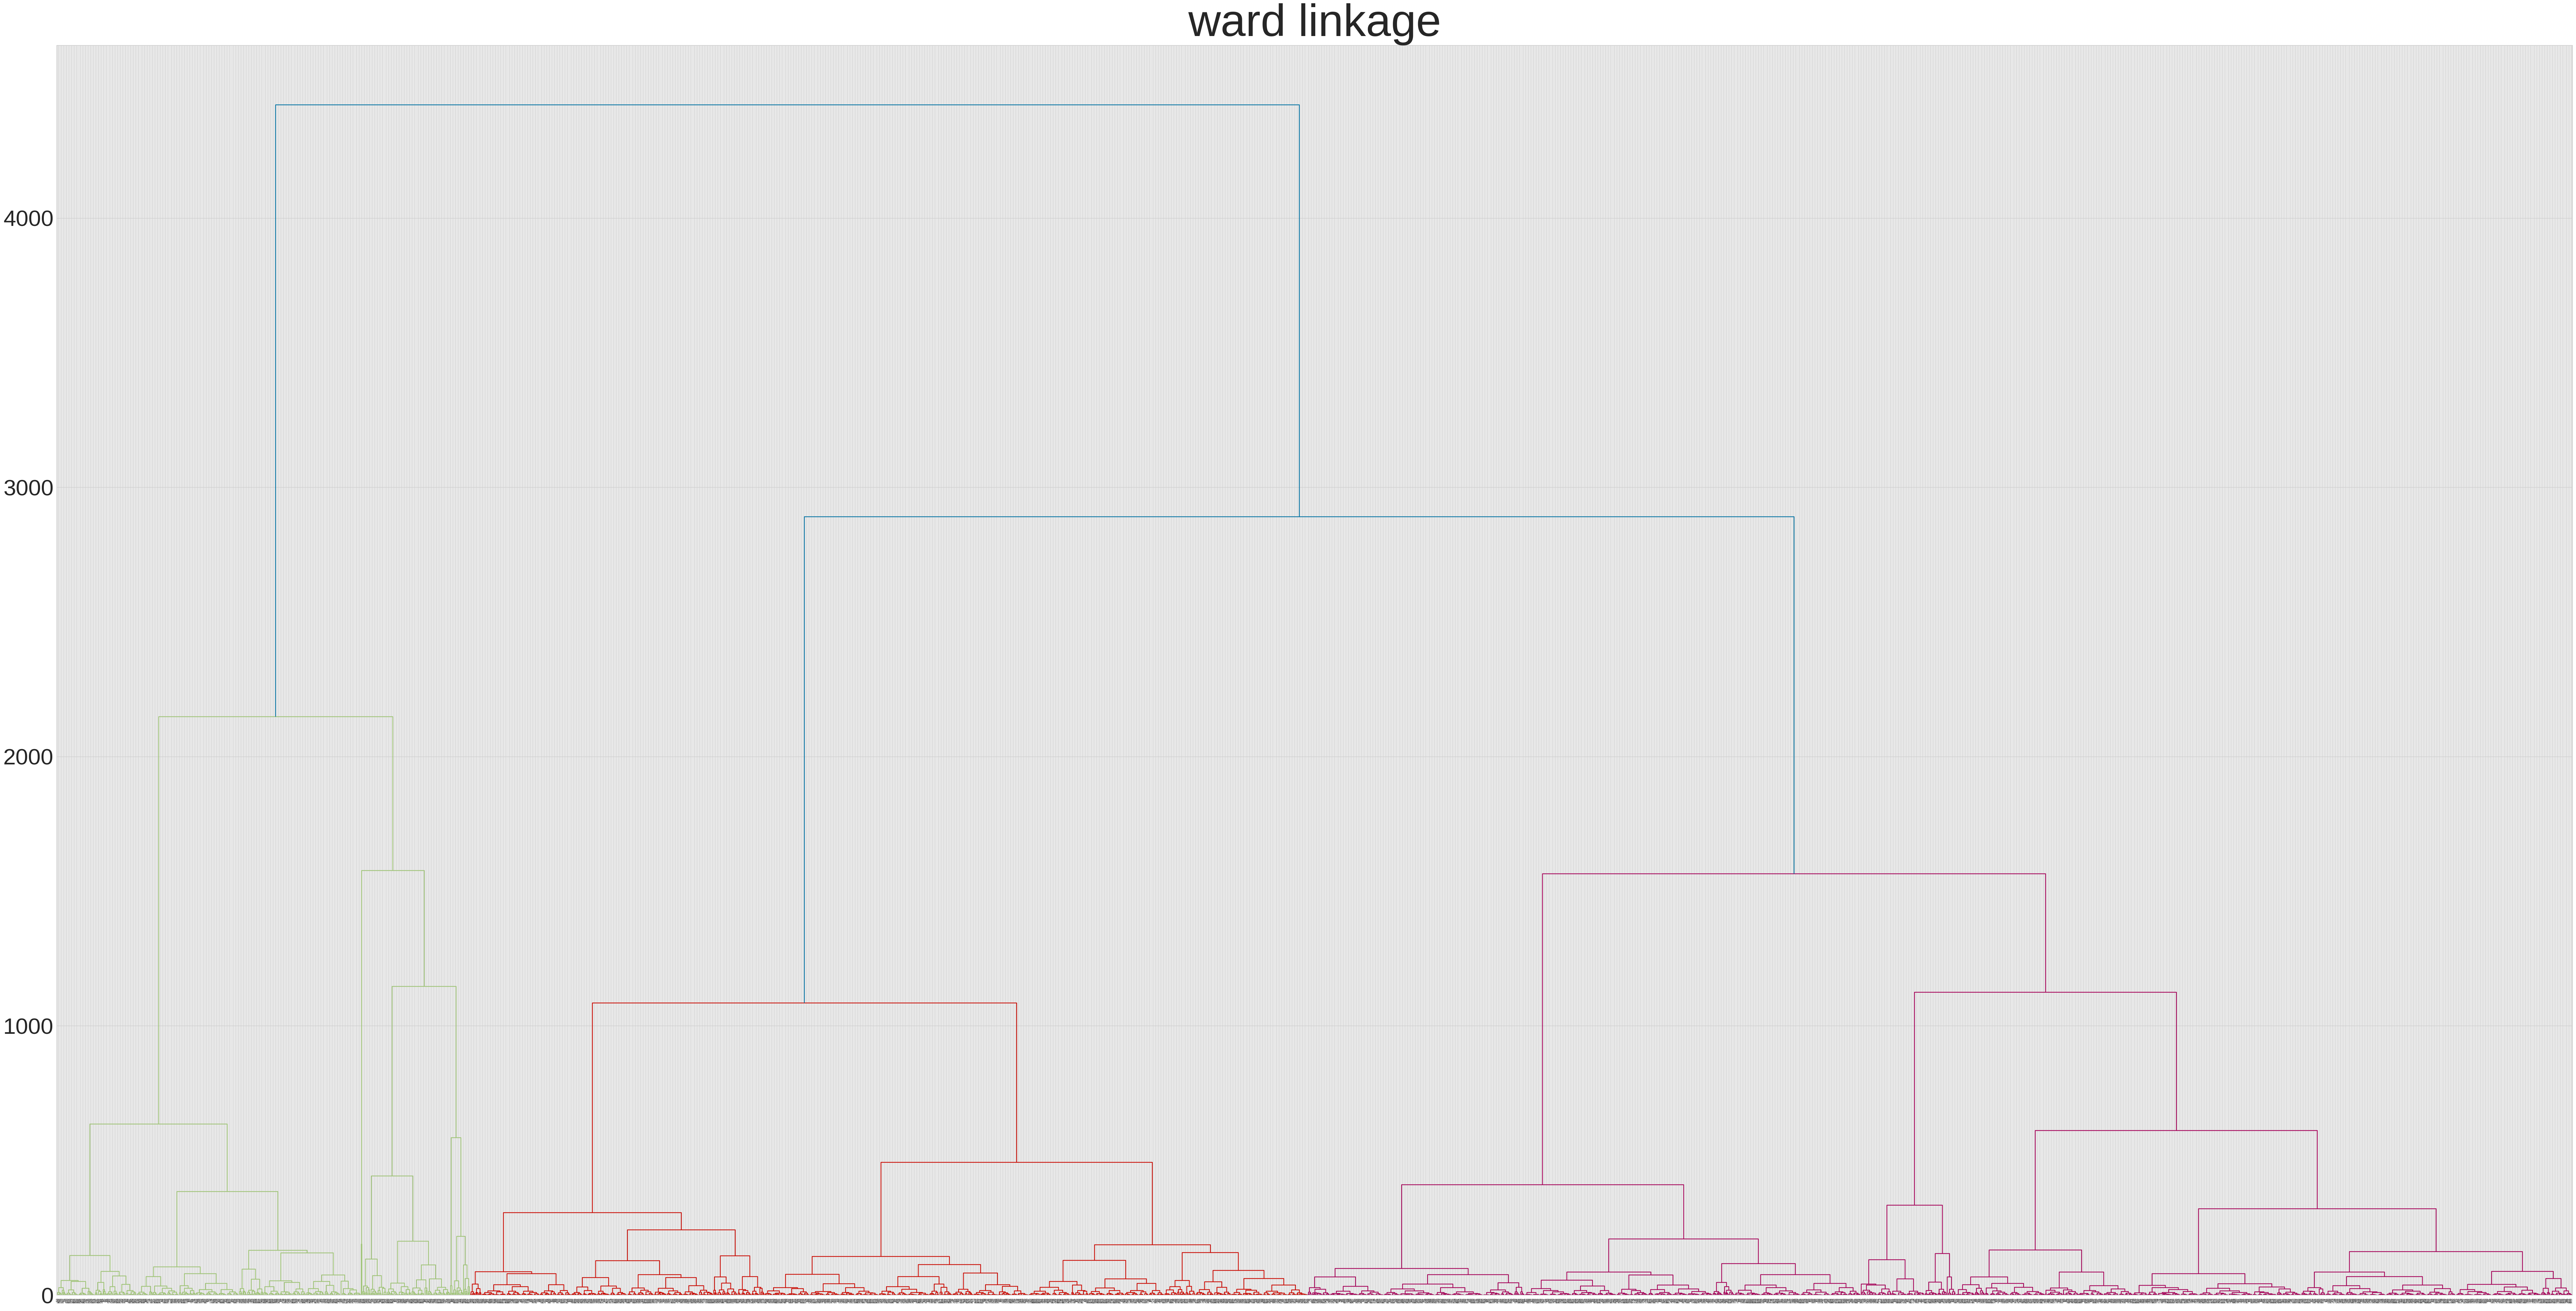

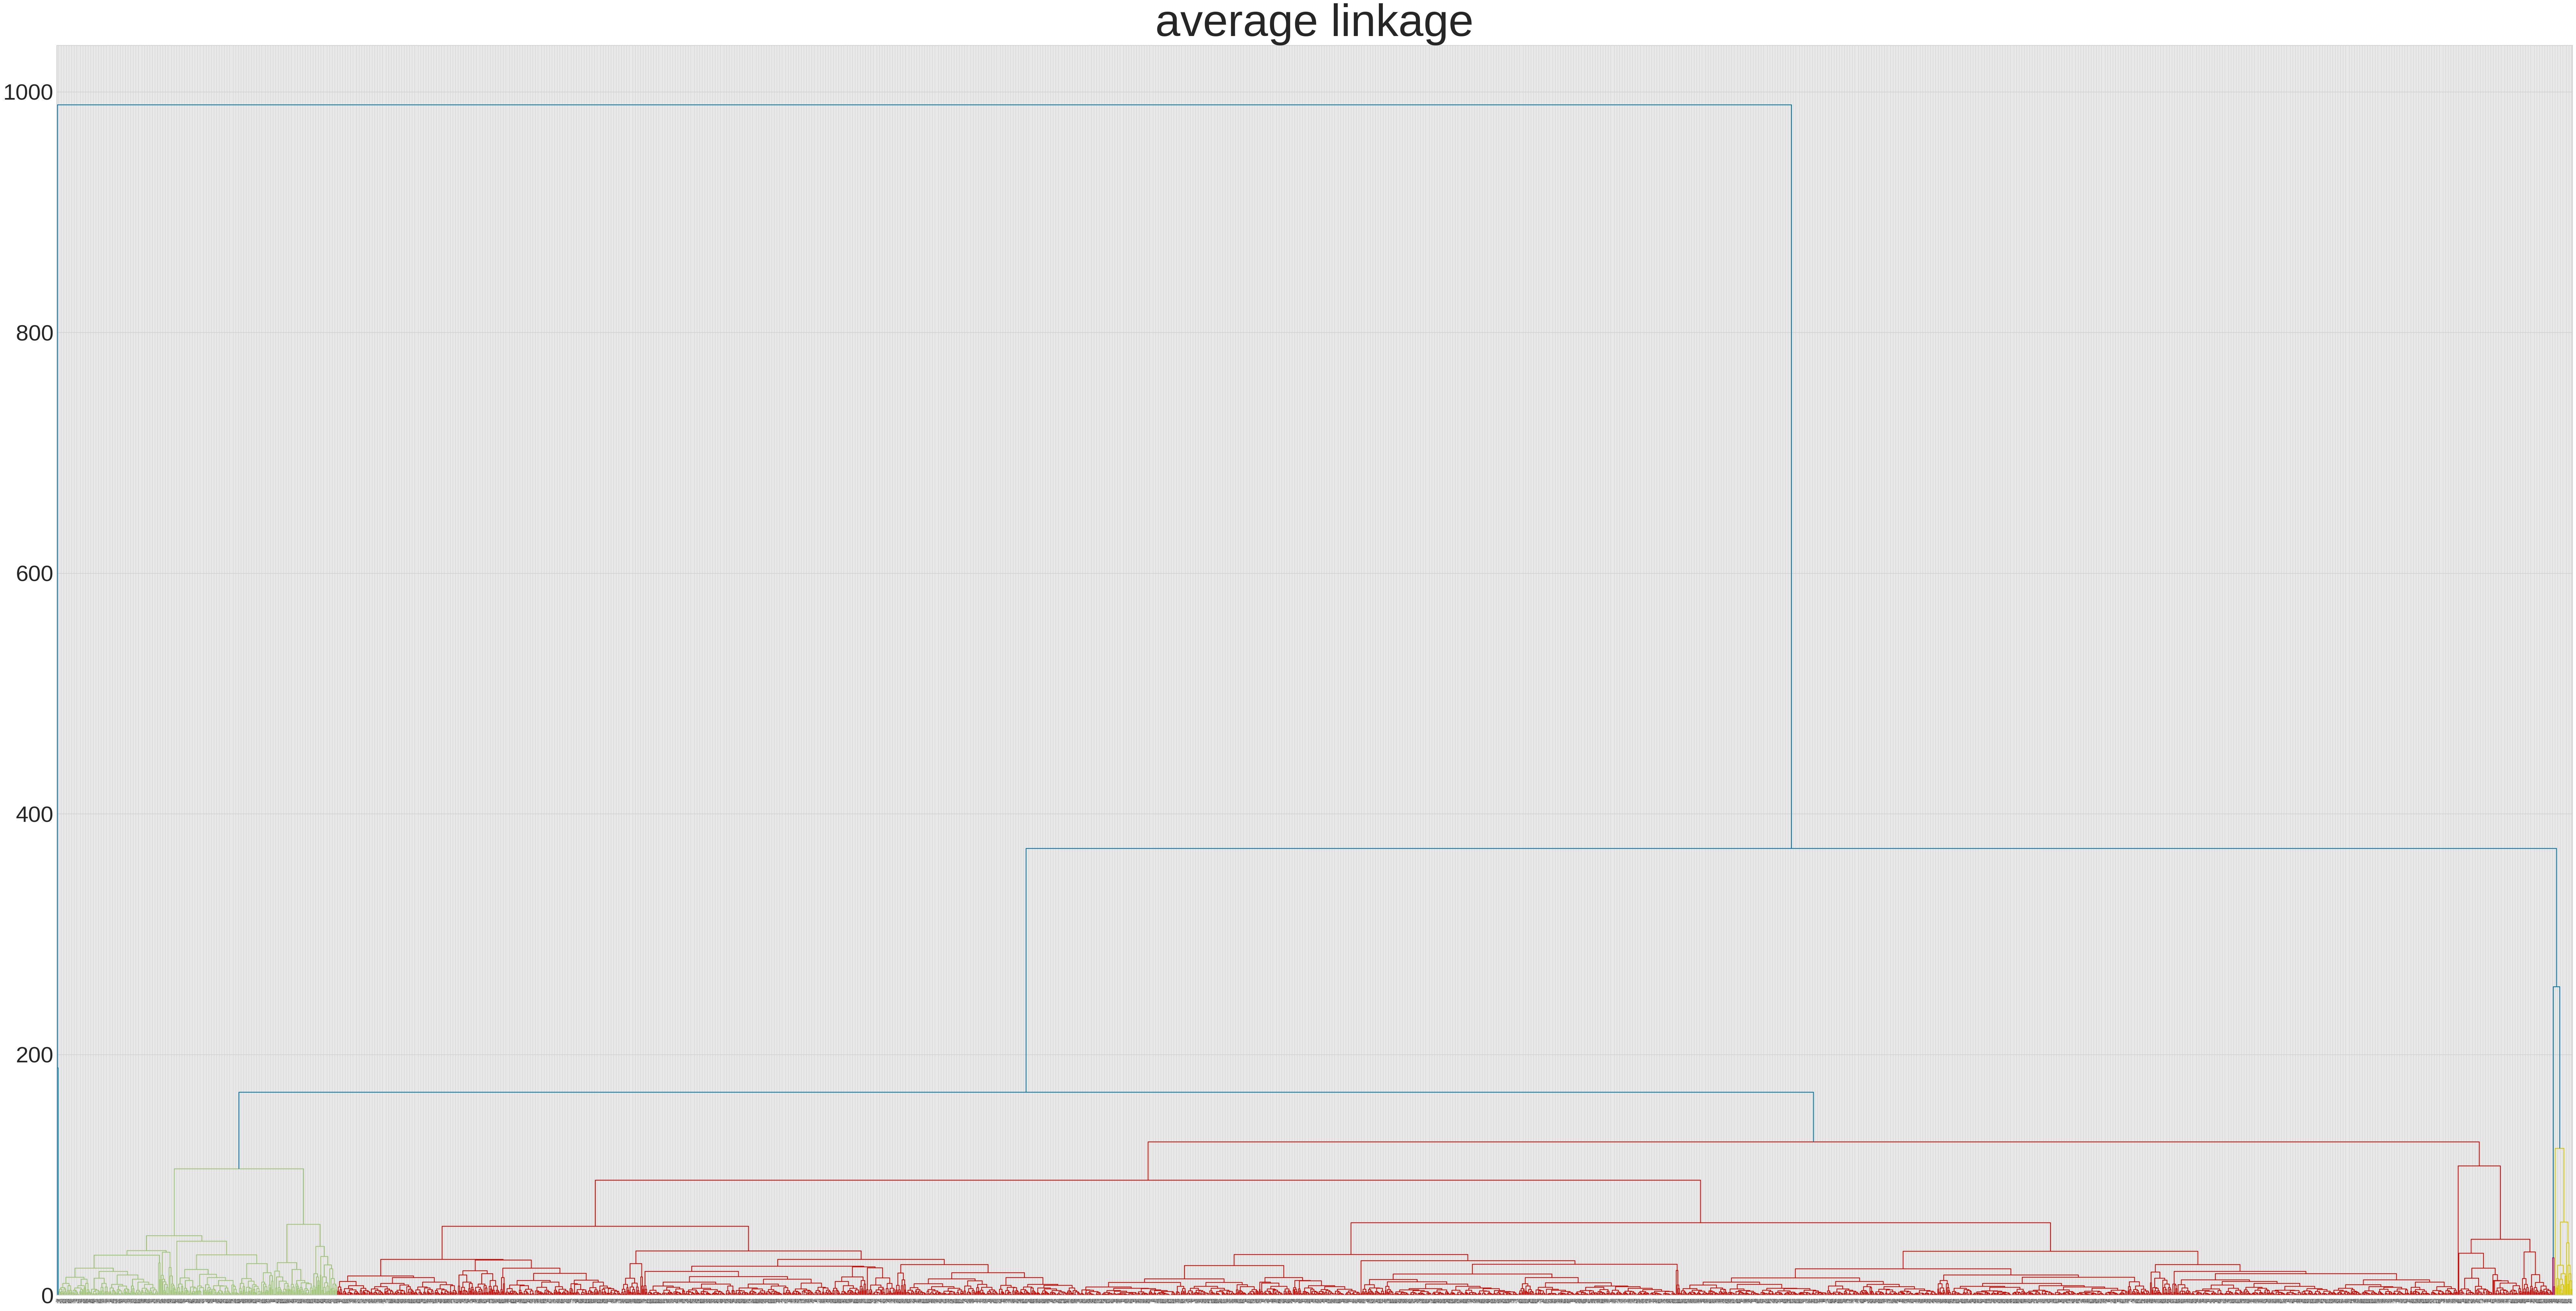

In [ ]:
# Setup linkages and thresholds
linkage_methods = {
    'single': 40,
    'complete': 200,
    'ward': 2500,
    'average': 160
    }

# Loop through all linage methods and show plots
for linkage_method, color_threshold in linkage_methods.items():
  model = linkage(distances, method=linkage_method)
  plt.figure(figsize=(100,50))
  dendrogram(model, p=30, truncate_mode='level', color_threshold=color_threshold);
  plt.title(f'{linkage_method} linkage', fontsize=100)
  plt.yticks(fontsize=50)
  plt.show()
  print()

(-1.0, 1.0)

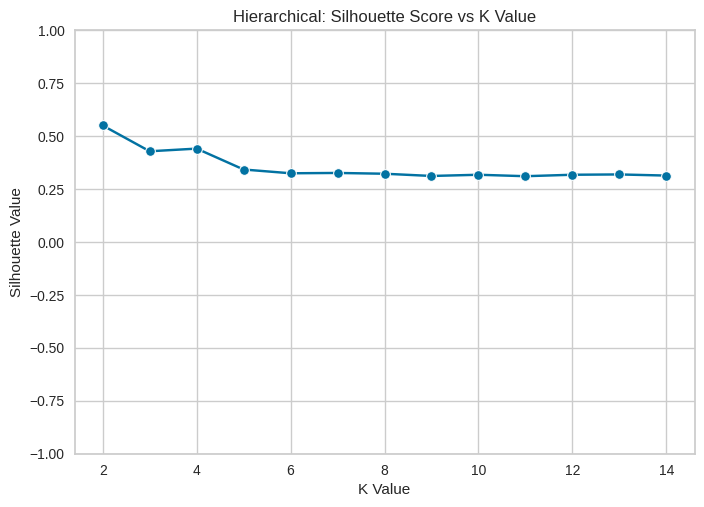

In [ ]:
# ID optimal number of clusters

# Set up lists
models = []
silhouette_scores = []

range_list = range(2, 15)

for k in range_list:
  # Create and fit model
  model = AgglomerativeClustering(n_clusters=k)
  model.fit(X)

  # Add model and data to lists
  models.append(model)
  silhouette_scores.append(silhouette_score(X, model.labels_))

# Silhouette-vs-k figure
p = sns.lineplot(x=range_list, y=silhouette_scores, marker='o')
p.set_title('Hierarchical: Silhouette Score vs K Value')
p.set_xlabel('K Value')
p.set_ylabel('Silhouette Value')
p.set_ylim(-1, 1)

In [ ]:
# Set parameters
h_parameter = {
    'n_clusters': range_list,
    'linkage': ['ward', 'complete', 'average', 'single'],
    'metric': ['euclidean', 'l1', 'l2', 'manhattan']
}

h_test_model = AgglomerativeClustering()

# Define a scoring function (silhouette_score)
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# Set scorer
scorer = make_scorer(silhouette_scorer)

# Grid search
search_results = GridSearchCV(
    h_test_model,
    h_parameter,
    scoring=scorer
    )
search_results.fit(X)

# Save results
save_gs_results(search_results)

Model                         Scoring metric                                              Mean ± Std                         Chosen Hyperparameters                            
AgglomerativeClustering       make_scorer(silhouette_scorer, response_method='predict')   nan ± nan                          {'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 2}


In [ ]:
# Create and fit model
h_model = AgglomerativeClustering(
    n_clusters=2,
    linkage='ward',
    metric='euclidean'
).fit(X)

In [ ]:
# Copy data
X_h = X.copy()

# Add clusters to data
X_h['clusters'] = h_model.labels_

In [ ]:
# Create and print cluster profile table
h_cluster_profile = X_h.groupby('clusters')[['Total Flr SF', 'SalePrice']].agg(['mean', 'median'])
print(h_cluster_profile)

         Total Flr SF           SalePrice          
                 mean    median      mean    median
clusters                                           
0           -0.737926 -0.716915  -0.37047 -0.423648
1            2.714018  2.286385   1.43096  1.257024


- Cluster 0: Lower cost smaller size standard homes
- Cluster 1: Higher cost larger homes

In [ ]:
# Set maping for clusters and labels
h_cluster_labels = {
    0: 'Standard',
    1: 'High-end / Luxury'
}

In [ ]:
# Map cluster labels to data
X_h['cluster_labels'] = X_h['clusters'].map(h_cluster_labels)

In [ ]:
# Print model report
print("Inertia is not available for AgglomerativeClustering because it does not use centroids.")

score = silhouette_score(X, X_h['clusters'])
print("Silhouette Score:", score)

print('Number of clusters detected', h_model.n_clusters)

Inertia is not available for AgglomerativeClustering because it does not use centroids.
Silhouette Score: 0.5501013773985445
Number of clusters detected 2


In [ ]:
# Print counts for cluster labels
X_h['cluster_labels'].value_counts()

cluster_labels
Standard             2254
High-end / Luxury     642
Name: count, dtype: int64

Text(0.5, 1.0, 'Agglomerative clusters: Total Flr SF vs Sale Price')

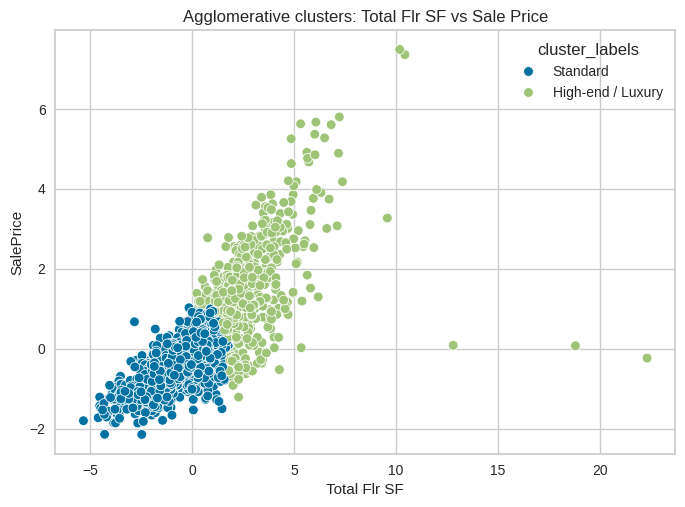

In [ ]:
# Show clusters plot
p = sns.scatterplot(data=X_h, x='Total Flr SF', y='SalePrice', hue='cluster_labels')
p.set_title('Agglomerative clusters: Total Flr SF vs Sale Price')

# Summary Table

In [ ]:
# Print summary table
print_gs_table()

Model                         Scoring metric                                              Mean ± Std                         Chosen Hyperparameters                            
KNeighborsClassifier          accuracy                                                    0.9322 ± 0.0049                    {'metric': 'manhattan', 'n_neighbors': 5}         
LinearDiscriminantAnalysis    accuracy                                                    0.9102 ± 0.0089                    {'shrinkage': 0.9, 'solver': 'lsqr'}              
Lasso                         neg_mean_squared_error                                      -844313203.2492 ± 286898504.6398   {'alpha': 1000}                                   
ElasticNet                    neg_mean_squared_error                                      -826088723.8971 ± 248510699.2507   {'alpha': 1, 'l1_ratio': 0.7}                     
KMeans                        make_scorer(silhouette_scorer, response_method='predict')   nan ± nan                     